# Install neccessary packages 

In [1]:
""" %pip install pandas 
%pip install numpy  
%pip install ipywidgets  
%pip install matplotlib 
%pip install seaborn  
%pip install sklearn 
%pip install pyarrow
 """

' %pip install pandas \n%pip install numpy  \n%pip install ipywidgets  \n%pip install matplotlib \n%pip install seaborn  \n%pip install sklearn \n%pip install pyarrow\n '

## Import necessary packages

In [2]:
from urllib import request as rq
import pandas as pd
import os
import pyarrow as pa # this is needed for the parquet file
import numpy as np
import ipywidgets
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, VBox
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

## Functions go here 

In [3]:
# Function to load the Dublin bus gz files 
def load_Files(direc, files, comtype):
    columns = ['Timestamp', 'LineID', 'Direction', 'JourneyPatternID', 'TimeFrame', 'VehicleJourneyID', 'Operator', 'Congestion', 'LonWGS84', 'LatWGS84', 'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']
    for f in files:
        print(f)
        yield pd.read_csv(direc + f, compression=comtype, delimiter=',', header=0, names=columns, parse_dates=True, low_memory=True)

def crackit_open(busFile):
    import zipfile as zip
    # Zip creates its own folders - no need to check for folder existence
    with zip.ZipFile(busFile,  mode='r') as arc: 
        arc.extractall('./Data/Bus/Gz/')  
    files = os.listdir('./Data/Bus/Gz/')
    DBfiles = [f for f in files if f.endswith('.gz')]
    df = pd.concat(load_Files('./Data/Bus/Gz/', DBfiles, 'gzip'), copy = False)
    return df

def dropcols_func(df,ColumnsToExclude):
# Data is loaded - now needs to be cleaned, there is an argument to be made to include this in the above cell 
# but I have added it here so that I can add more columns to be excluded as I go rather than load the raw data each time
    for c in ColumnsToExclude:
        if c in df.columns:  # type: ignore
            df = df.drop(c, axis=1)  # type: ignore
        else:
            print('Columns already dropped')
    return df

def shapiro_test(x):
    p_val = stats.shapiro(x)[1]
    status = 'passed'
    color = 'blue'
    if p_val < 0.05:
        status = 'failed'
        color = 'red'
    return status, color, p_val

def custom_scatterplot(df1, col1=''):
    df1 = df1[df1["LineID"]==col1]
    f = plt.figure()
    f, ax = plt.subplots(figsize=(11.5, 11.5))
    ax = f.add_subplot(projection='3d')
    ax.scatter(df1['LonWGS84'], df1['LatWGS84'], df1['Hour'], alpha=0.6, color=df1['Colour'])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Hour')
    
    
def custom_barplot(df1, col1=''):
    if len(df1[col1]) > 5000: # added this to the function because of warnings about the size of data being used with shapiro test
            sampleSize = 5000
    else:
        sampleSize = len(df1[col1])
    df1 = df1.sample(sampleSize) #shapiro test is unreliable over 5000 https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test and performance reasons
    f, ax = plt.subplots(2,2, figsize=(11.5, 11.5))
    ax = ax.reshape(-1)
    df1[col1].plot(ax=ax[0], kind='hist')
    ax[0].set_title('Histogram of {}'.format(col1))
    df1[col1].plot(ax=ax[1], kind='kde')
    ax[1].set_title('Density Plot of {}'.format(col1))
    ax3 = plt.subplot(223)
    stats.probplot(df[col1], plot=plt)
    ax[2].set_title('QQ Plot of {}'.format(col1))
    df1[col1].plot(ax=ax[3], kind='box')
    ax[3].set_title('Box Plot of {}'.format(col1))
    status, color, p_val = shapiro_test(df1[col1]) 
    f.suptitle('Normality test for {} {} (p_value = {})'.format(col1, status, p_val), color=color, fontsize=12)

def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))


def load_csv_Files(direc, files):

    for f in files:
        # need to get number of rows to skip 
        temp=pd.read_csv(direc + f,sep='^',header=None,prefix='X')
        temp2=temp.X0.str.split(',',expand=True)
        del temp['X0']
        temp=pd.concat([temp,temp2],axis=1)
        cols = list(range(0,temp.shape[1]))

        print(f)
        yield pd.read_csv(direc + f,  delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, usecols=cols, na_values='NAN')

## Ensure that the folder structure is present in the workspace

In [4]:
if os.path.exists('./Data'):
    print('Data folder exists')

if os.path.exists('./Data/Bus'):
    print('Bus Data folder exists')
else:
    os.makedirs('./Data/Bus')

if os.path.exists('./Data/MetEirrean/'):
    print('Weather data folder exists')
else:
    os.makedirs('./Data/MetEirrean/')

if os.path.exists('./Zips/MetEirrean'):
    print('Weather folder exisits')
else:
    os.makedirs('./Zips/MetEirrean/')



Data folder exists
Bus Data folder exists
Weather data folder exists
Weather folder exisits


## Download the Dublin Bus data 
    from https://data.gov.ie/organization/dublin-city-council?tags=Transport+and+Infrastructure
    Decompress the zip file into the zips/Bus folder
    Use a generator to load the data into pandas data frame https://pandasninja.com/2019/04/how-to-read-lots-of-csv-files-easily-into-pandas/#:~:text=How%20to%20read%20lots%20of%20csv%20files%20easily,need%20...%204%204.%20Leverage%20regular%20expressions%20

## Loop through the gz files and decompress them in to the Data/Bus folder

In [5]:
# Check parquet file existence before downloading - iof starting from afresh this takes a long time
if os.path.exists('./Data/CleanedBusData.parquet'):
    print("Parquest file exists, means the Bus data has been downloaded already ")
    df = pd.read_parquet('./Data/CleanedBusData.parquet')
    if os.path.exists('./Data/WeatherandBusData.parquet'):
        print('Weather and bus data combined exists')
        mdf = pd.read_parquet('./Data/WeatherandBusData.parquet')
elif os.path.exists('./Zips/Bus/DublinBusdata.zip'):
    print("Zip file exists, we have already downloaded the Dublin Bus Zip data, crack it open")
    df = crackit_open('./Zips/Bus/DublinBusdata.zip')
else:
    os.makedirs('./Zips/Bus/', exist_ok = True)
    url = "https://opendata.dublincity.ie/TrafficOpenData/sir010113-310113.zip"
    busFile = rq.urlretrieve(url, './Zips/Bus/DublinBusdata.zip' )  
    df = crackit_open('./Zips/Bus/DublinBusdata.zip')


### Read the Bus data in to a Pandas dataframe - done

Zip file exists, we have already downloaded the Dublin Bus Zip data, crack it open
siri.20130101.csv.gz
siri.20130102.csv.gz
siri.20130103.csv.gz
siri.20130104.csv.gz
siri.20130105.csv.gz
siri.20130106.csv.gz
siri.20130107.csv.gz
siri.20130108.csv.gz
siri.20130109.csv.gz
siri.20130110.csv.gz
siri.20130111.csv.gz
siri.20130112.csv.gz
siri.20130113.csv.gz
siri.20130114.csv.gz
siri.20130115.csv.gz
siri.20130116.csv.gz
siri.20130117.csv.gz
siri.20130118.csv.gz
siri.20130119.csv.gz
siri.20130120.csv.gz
siri.20130121.csv.gz
siri.20130122.csv.gz
siri.20130123.csv.gz
siri.20130124.csv.gz
siri.20130125.csv.gz
siri.20130126.csv.gz
siri.20130127.csv.gz
siri.20130128.csv.gz
siri.20130129.csv.gz
siri.20130130.csv.gz
siri.20130131.csv.gz


### Check for missing and have a brief look at the data 

In [6]:
temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore

display(temp_df)

display(missing_df)

count          mean           std           min  \
Timestamp         44455102.0  1.358318e+15  7.394928e+11  1.356998e+15   
LineID            44453044.0  7.796879e+01  1.146419e+02  1.000000e+00   
Direction         44455102.0  0.000000e+00  0.000000e+00  0.000000e+00   
VehicleJourneyID  44455102.0  9.417122e+03  6.159844e+04  1.000000e+00   
Congestion        44455102.0  1.163261e-02  1.072254e-01  0.000000e+00   
LonWGS84          44455102.0 -6.272803e+00  8.389025e-02 -6.617517e+00   
LatWGS84          44455102.0  5.334513e+01  5.488354e-02  5.306802e+01   
Delay             44455102.0 -2.816513e+01  4.729678e+02 -1.504500e+04   
BlockID           44455102.0  1.092438e+05  1.921244e+05  3.900000e+02   
VehicleID         44455102.0  3.542925e+04  3.281093e+03  2.804700e+04   
StopID            41952926.0  2.791465e+03  2.204841e+03  2.000000e+00   
AtStop            44455102.0  2.335773e-01  4.231063e-01  0.000000e+00   

                           25%           50%           75%           max  
Timestamp         1.357679e+15  1.358327e+15  1.358955e+15  1.359633e+15  
LineID            2.500000e+01  4.000000e+01  8.300000e+01  7.470000e+02  
Direction         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
VehicleJourneyID  2.536000e+03  4.718000e+03  6.769000e+03  9.998560e+05  
Congestion        0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
LonWGS84         -6.308650e+00 -6.261600e+00 -6.233166e+00 -6.052917e+00  
LatWGS84          5.332005e+01  5.334645e+01  5.337533e+01  5.360873e+01  
Delay            -2.090000e+02  0.000000e+00  1.040000e+02  1.161220e+05  
BlockID           1.602000e+04  4.020500e+04  8.400400e+04  8.350020e+05  
VehicleID         3.330800e+04  3.352500e+04  3.802500e+04  4.307800e+04  
StopID            8.450000e+02  2.159000e+03  4.465000e+03  7.552000e+03  
AtStop            0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00

missing
Timestamp               0
LineID               2058
Direction               0
JourneyPatternID  6649915
TimeFrame               0
VehicleJourneyID        0
Operator                0
Congestion              0
LonWGS84                0
LatWGS84                0
Delay                   0
BlockID                 0
VehicleID               0
StopID            2502176
AtStop                  0

## Remove unwanted columns 
At this stage we will drop JourneyPatternID, StopID as they have a lot of missing values and we will drop Direction as it has only value 0

In [7]:
ColumnsToExclude = ('JourneyPatternID', 'StopID', 'Direction') # droping Journery Pattern ID and Stop ID as there are too many missing values
df = dropcols_func(df, ColumnsToExclude)


In [8]:

temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore

display(temp_df)

display(missing_df)

count          mean           std           min  \
Timestamp         44455102.0  1.358318e+15  7.394928e+11  1.356998e+15   
LineID            44453044.0  7.796879e+01  1.146419e+02  1.000000e+00   
VehicleJourneyID  44455102.0  9.417122e+03  6.159844e+04  1.000000e+00   
Congestion        44455102.0  1.163261e-02  1.072254e-01  0.000000e+00   
LonWGS84          44455102.0 -6.272803e+00  8.389025e-02 -6.617517e+00   
LatWGS84          44455102.0  5.334513e+01  5.488354e-02  5.306802e+01   
Delay             44455102.0 -2.816513e+01  4.729678e+02 -1.504500e+04   
BlockID           44455102.0  1.092438e+05  1.921244e+05  3.900000e+02   
VehicleID         44455102.0  3.542925e+04  3.281093e+03  2.804700e+04   
AtStop            44455102.0  2.335773e-01  4.231063e-01  0.000000e+00   

                           25%           50%           75%           max  
Timestamp         1.357679e+15  1.358327e+15  1.358955e+15  1.359633e+15  
LineID            2.500000e+01  4.000000e+01  8.300000e+01  7.470000e+02  
VehicleJourneyID  2.536000e+03  4.718000e+03  6.769000e+03  9.998560e+05  
Congestion        0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
LonWGS84         -6.308650e+00 -6.261600e+00 -6.233166e+00 -6.052917e+00  
LatWGS84          5.332005e+01  5.334645e+01  5.337533e+01  5.360873e+01  
Delay            -2.090000e+02  0.000000e+00  1.040000e+02  1.161220e+05  
BlockID           1.602000e+04  4.020500e+04  8.400400e+04  8.350020e+05  
VehicleID         3.330800e+04  3.352500e+04  3.802500e+04  4.307800e+04  
AtStop            0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00

missing
Timestamp               0
LineID               2058
TimeFrame               0
VehicleJourneyID        0
Operator                0
Congestion              0
LonWGS84                0
LatWGS84                0
Delay                   0
BlockID                 0
VehicleID               0
AtStop                  0

### Drop nas and duplicates - there are no duplicates but there are na's 

In [9]:
df = df.dropna() # this drops the rows with empty LineID values
df = df.drop_duplicates()

temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore

display(temp_df)

display(missing_df)



count          mean           std           min  \
Timestamp         44452253.0  1.358318e+15  7.394880e+11  1.356998e+15   
LineID            44452253.0  7.796882e+01  1.146420e+02  1.000000e+00   
VehicleJourneyID  44452253.0  9.417418e+03  6.160025e+04  1.000000e+00   
Congestion        44452253.0  1.163325e-02  1.072283e-01  0.000000e+00   
LonWGS84          44452253.0 -6.272804e+00  8.389083e-02 -6.617517e+00   
LatWGS84          44452253.0  5.334513e+01  5.488333e-02  5.306802e+01   
Delay             44452253.0 -2.816554e+01  4.729786e+02 -1.504500e+04   
BlockID           44452253.0  1.092381e+05  1.921186e+05  3.900000e+02   
VehicleID         44452253.0  3.542929e+04  3.281127e+03  2.804700e+04   
AtStop            44452253.0  2.335883e-01  4.231132e-01  0.000000e+00   

                           25%           50%           75%           max  
Timestamp         1.357679e+15  1.358327e+15  1.358955e+15  1.359633e+15  
LineID            2.500000e+01  4.000000e+01  8.300000e+01  7.470000e+02  
VehicleJourneyID  2.536000e+03  4.718000e+03  6.769000e+03  9.998560e+05  
Congestion        0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
LonWGS84         -6.308651e+00 -6.261600e+00 -6.233166e+00 -6.052917e+00  
LatWGS84          5.332005e+01  5.334645e+01  5.337532e+01  5.360873e+01  
Delay            -2.090000e+02  0.000000e+00  1.040000e+02  1.161220e+05  
BlockID           1.602000e+04  4.020500e+04  8.400400e+04  8.350020e+05  
VehicleID         3.330800e+04  3.352500e+04  3.802500e+04  4.307800e+04  
AtStop            0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00

missing
Timestamp               0
LineID                  0
TimeFrame               0
VehicleJourneyID        0
Operator                0
Congestion              0
LonWGS84                0
LatWGS84                0
Delay                   0
BlockID                 0
VehicleID               0
AtStop                  0

# Do exploratory data analysis on the Bus Data

## Display the shape and types of data in the Bus data frame

In [10]:
print ('The data has {} Rows and {} columns'.format(df.shape[0],df.shape[1]))
print("The types of columns are:")
display(df.dtypes)

The data has 44452253 Rows and 12 columns
The types of columns are:


Timestamp             int64
LineID              float64
TimeFrame            object
VehicleJourneyID      int64
Operator             object
Congestion            int64
LonWGS84            float64
LatWGS84            float64
Delay                 int64
BlockID               int64
VehicleID             int64
AtStop                int64
dtype: object

### Describe the numerical data in the Bus data set

In [11]:
unq_df = pd.DataFrame(df.apply(num_unique, axis=0))
unq_df.columns = ['unique']  # type: ignore
types_df = pd.DataFrame(df.dtypes)
types_df.columns = ['DataType'] # type: ignore

In [12]:
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)


### Display the summary Data about the Numerical columns

In [13]:
display(summary_df) # Numerical Data

# save work done so far 
df.to_parquet('./Data/CleanedBusData.parquet')

count          mean           std           min  \
Timestamp         44452253.0  1.358318e+15  7.394880e+11  1.356998e+15   
LineID            44452253.0  7.796882e+01  1.146420e+02  1.000000e+00   
VehicleJourneyID  44452253.0  9.417418e+03  6.160025e+04  1.000000e+00   
Congestion        44452253.0  1.163325e-02  1.072283e-01  0.000000e+00   
LonWGS84          44452253.0 -6.272804e+00  8.389083e-02 -6.617517e+00   
LatWGS84          44452253.0  5.334513e+01  5.488333e-02  5.306802e+01   
Delay             44452253.0 -2.816554e+01  4.729786e+02 -1.504500e+04   
BlockID           44452253.0  1.092381e+05  1.921186e+05  3.900000e+02   
VehicleID         44452253.0  3.542929e+04  3.281127e+03  2.804700e+04   
AtStop            44452253.0  2.335883e-01  4.231132e-01  0.000000e+00   

                           25%           50%           75%           max  \
Timestamp         1.357679e+15  1.358327e+15  1.358955e+15  1.359633e+15   
LineID            2.500000e+01  4.000000e+01  8.300000e+01  7.470000e+02   
VehicleJourneyID  2.536000e+03  4.718000e+03  6.769000e+03  9.998560e+05   
Congestion        0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
LonWGS84         -6.308651e+00 -6.261600e+00 -6.233166e+00 -6.052917e+00   
LatWGS84          5.332005e+01  5.334645e+01  5.337532e+01  5.360873e+01   
Delay            -2.090000e+02  0.000000e+00  1.040000e+02  1.161220e+05   
BlockID           1.602000e+04  4.020500e+04  8.400400e+04  8.350020e+05   
VehicleID         3.330800e+04  3.352500e+04  3.802500e+04  4.307800e+04   
AtStop            0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   

                  missing  unique DataType  
Timestamp               0  813102    int64  
LineID                  0      66  float64  
VehicleJourneyID        0   18614    int64  
Congestion              0       2    int64  
LonWGS84                0  456755  float64  
LatWGS84                0  131327  float64  
Delay                   0   12638    int64  
BlockID                 0    1228    int64  
VehicleID               0     911    int64  
AtStop                  0       2    int64

### Set the Numerical and Categorical columns

In [14]:
# Getting the list of column Types
CategoricalColumns = list(set(['LineID', 'TimeFrame', 'VehicleJourneyID', 'Operator', 'Congestion', 'BlockID', 'VehicleID', 'AtStop']))
NumericalColumns = list(set(list(df.select_dtypes([np.number]).columns)))
#objectTypeColumns = list(set(list(df.select_dtypes([np.object_]).columns)))
DateColumns = list(set(list(df.select_dtypes([np.datetime64]).columns)))
ColumnsToExclude = ('Month', 'Year', 'Direction', 'Congestion', 'AtStop' 'Ontime')
#print(objectTypeColumns)


CategoricalColumns = list(set(CategoricalColumns) - set(ColumnsToExclude)-set(DateColumns))
NumericalColumns = list(set(NumericalColumns)-set(ColumnsToExclude)-set(DateColumns))

print(CategoricalColumns)
print(NumericalColumns)
print(DateColumns)


['LineID', 'BlockID', 'VehicleJourneyID', 'TimeFrame', 'VehicleID', 'AtStop', 'Operator']
['LineID', 'BlockID', 'Delay', 'LatWGS84', 'LonWGS84', 'VehicleJourneyID', 'VehicleID', 'AtStop', 'Timestamp']
[]


b: Describe the categoric data - done

In [15]:
col_names = list(types_df.index)
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index:
    if col_names[i] in CategoricalColumns:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
print(summary_df_cat)

                  missing  unique DataType
LineID                  0      66  float64
TimeFrame               0      32   object
VehicleJourneyID        0   18614    int64
Operator                0       8   object
BlockID                 0    1228    int64
VehicleID               0     911    int64
AtStop                  0       2    int64


## Add time columns to the Bus Data

In [16]:
# Deal with the timestamp and make it human readable and i will use this to merge datasets later
df['datetime'] = pd.to_datetime(df['Timestamp'], unit='us')
df['Time'] = df['datetime'].dt.time
df['Day'] = df['datetime'].dt.day
df['Hour'] = df['datetime'].dt.hour
df['Minute'] = df['datetime'].dt.minute
df['Year'] = df['datetime'].dt.year
df['Month'] = df['datetime'].dt.month
df['DayofWeek'] = df['datetime'].dt.day_of_week

In [17]:
# Check the outcome of adding time and day data
df.head()

Timestamp  LineID   TimeFrame  VehicleJourneyID Operator  \
0  1356998405000000    27.0  2012-12-31              3883       RD   
1  1356998407000000    40.0  2012-12-31              2226       HN   
2  1356998407000000     7.0  2012-12-31              6106       D1   
3  1356998411000000   747.0  2012-12-31              3531       SL   
4  1356998411000000    56.0  2012-12-31              1830       RD   

   Congestion  LonWGS84   LatWGS84  Delay  BlockID  VehicleID  AtStop  \
0           0 -6.233417  53.342232      0    27017      33521       0   
1           0 -6.278250  53.416683      0    40206      33142       0   
2           0 -6.231633  53.317768      0     7019      43004       1   
3           0 -6.254617  53.355484   -454   747007      40039       0   
4           0 -6.233183  53.342201      0    56001      33488       0   

             datetime      Time  Day  Hour  Minute  Year  Month  DayofWeek  
0 2013-01-01 00:00:05  00:00:05    1     0       0  2013      1          1  
1 2013-01-01 00:00:07  00:00:07    1     0       0  2013      1          1  
2 2013-01-01 00:00:07  00:00:07    1     0       0  2013      1          1  
3 2013-01-01 00:00:11  00:00:11    1     0       0  2013      1          1  
4 2013-01-01 00:00:11  00:00:11    1     0       0  2013      1          1

In [18]:

busRoutes = df['LineID'].unique()
busRoutes = sorted(busRoutes)
display(busRoutes)

[1.0,
 4.0,
 7.0,
 9.0,
 11.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 25.0,
 27.0,
 29.0,
 31.0,
 32.0,
 33.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 44.0,
 46.0,
 49.0,
 51.0,
 53.0,
 54.0,
 56.0,
 59.0,
 63.0,
 65.0,
 66.0,
 67.0,
 68.0,
 75.0,
 76.0,
 79.0,
 83.0,
 84.0,
 86.0,
 102.0,
 104.0,
 111.0,
 114.0,
 116.0,
 118.0,
 120.0,
 122.0,
 123.0,
 130.0,
 140.0,
 142.0,
 145.0,
 150.0,
 151.0,
 171.0,
 220.0,
 238.0,
 271.0,
 272.0,
 331.0,
 332.0,
 451.0,
 747.0]

# Display Histograms from the Data set

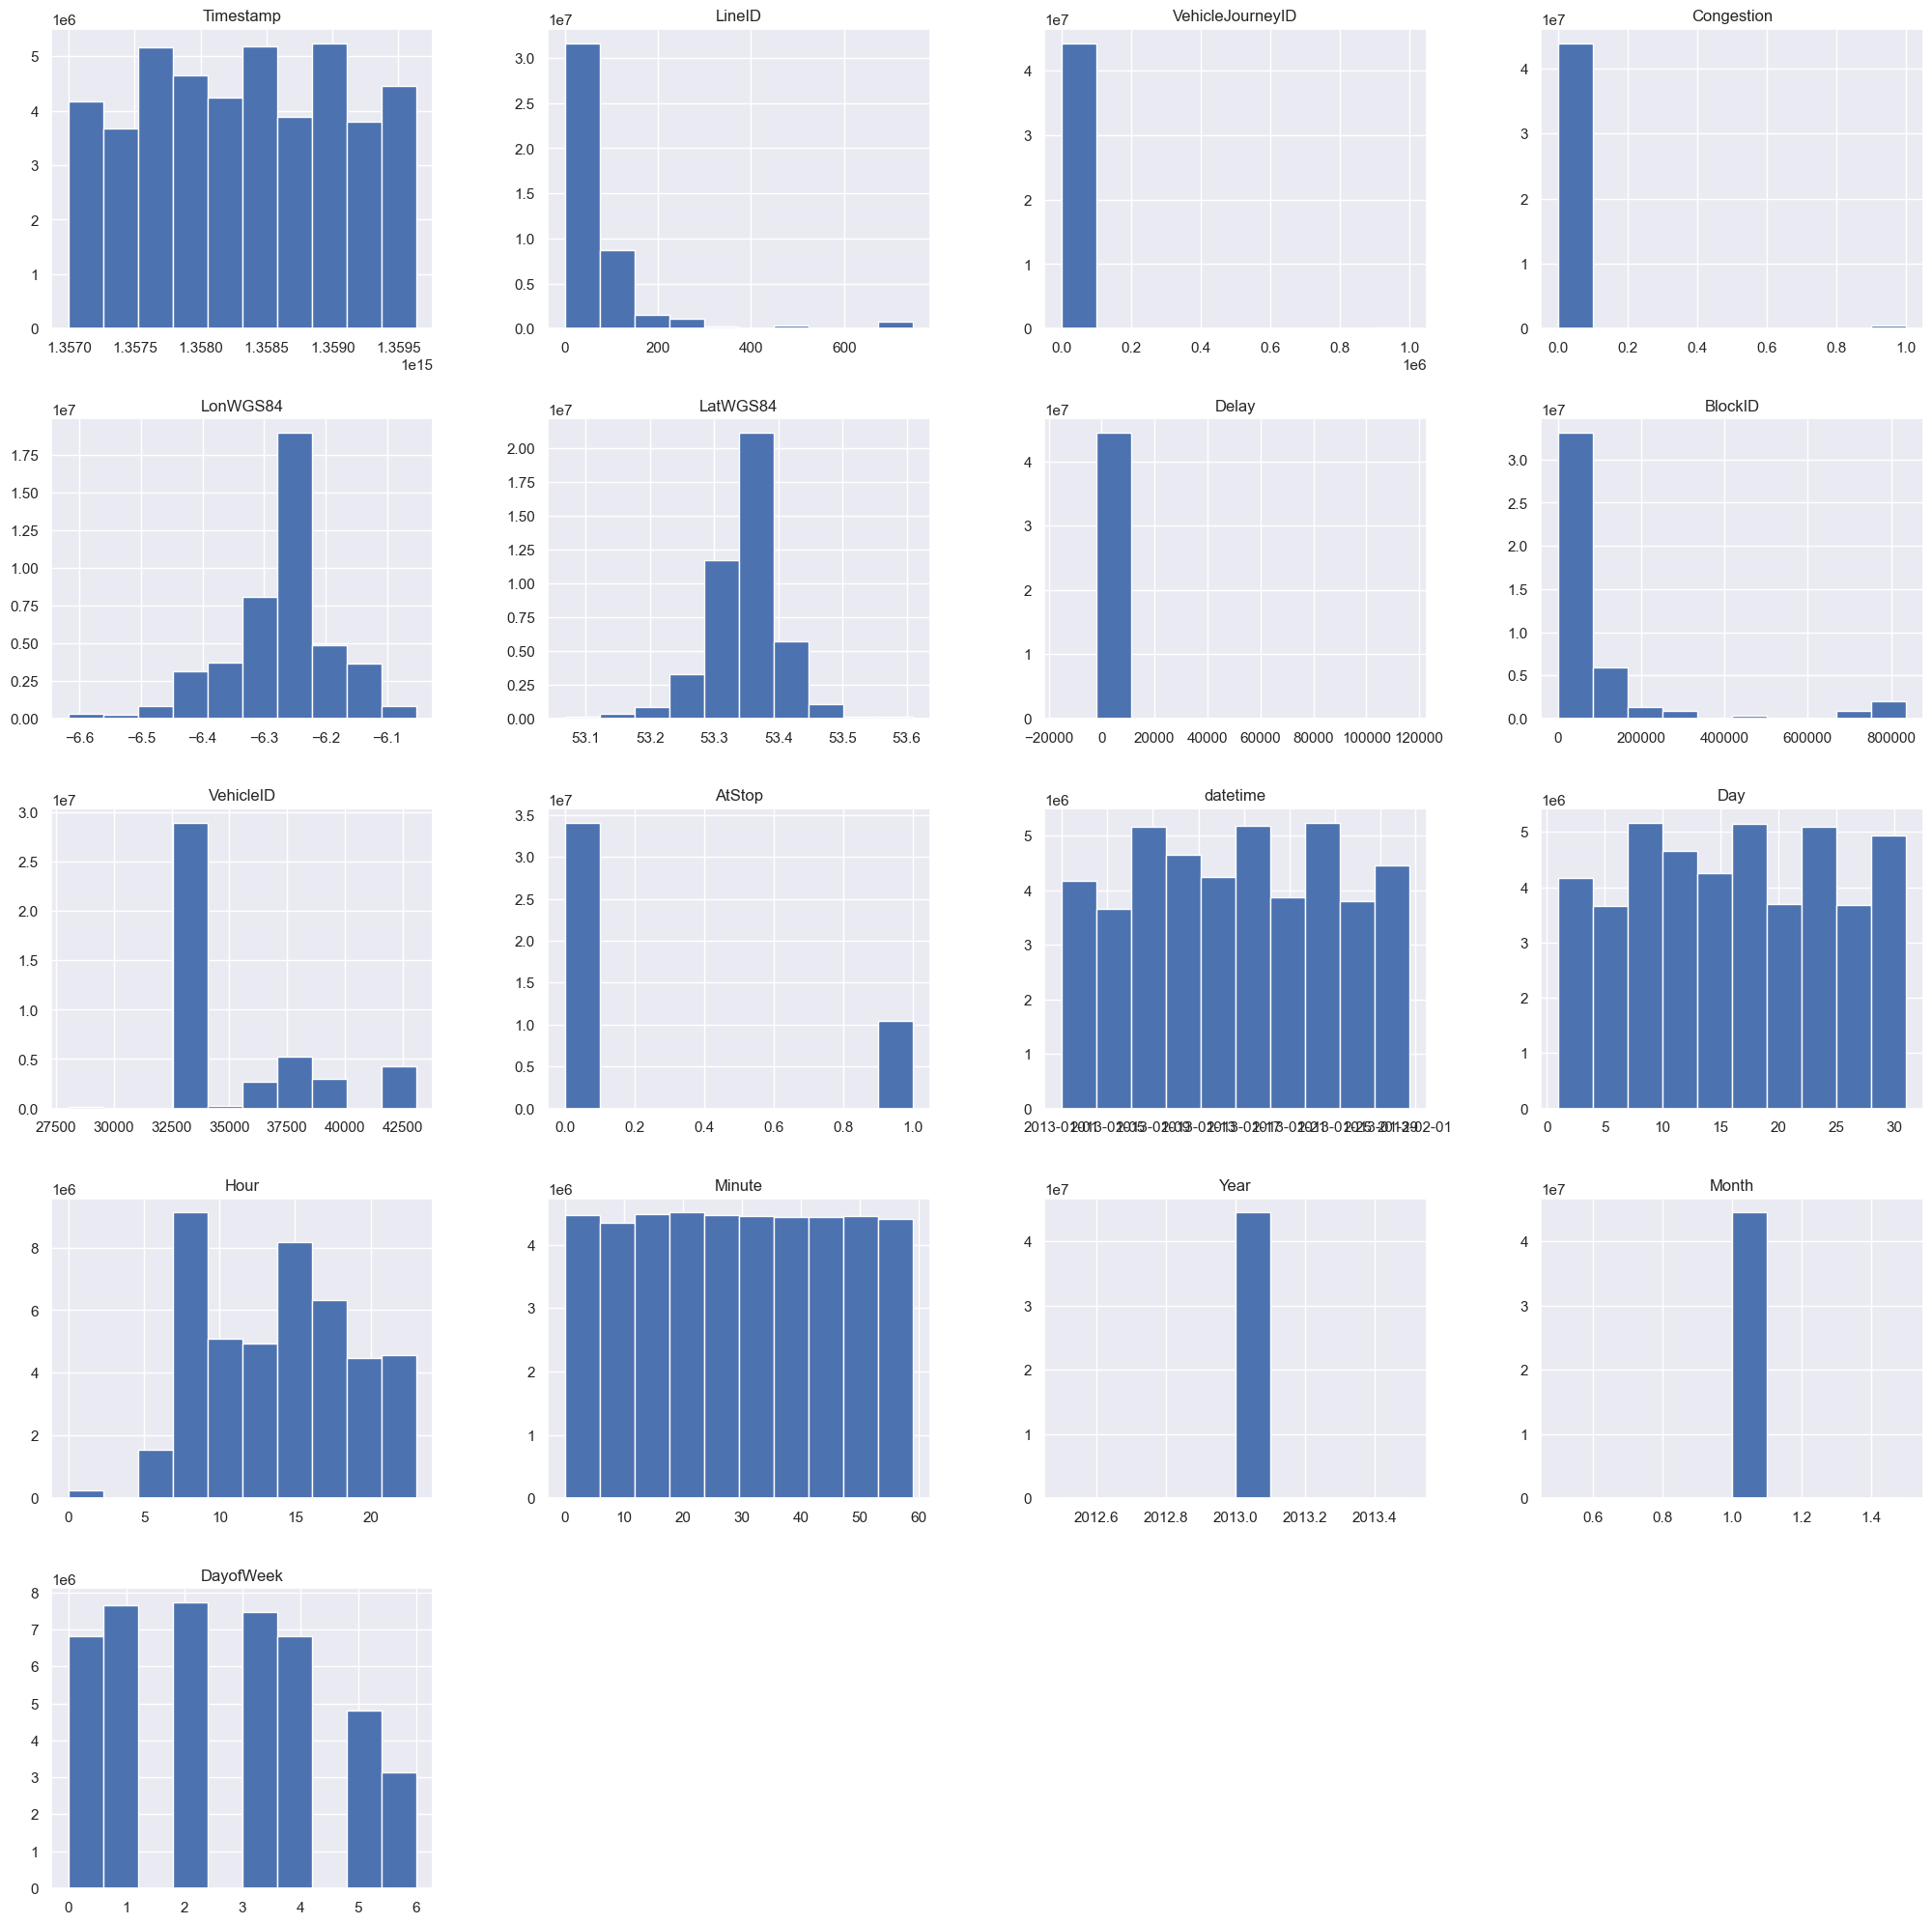

In [19]:
%matplotlib inline
sns.set(color_codes=True)
df.hist(figsize=(25,25));

## Display boxplots of some of the numeric data

Note we have outliers in the Delay value for one bus operator, on a Friday the 11'th of January, these look like a mistake as 120,000 seconds is equal to circa 1.4 days, anything above 20,000 seconds is circa 5.5 hours early, it is hard to fathom that buses in dublin could be that early.  

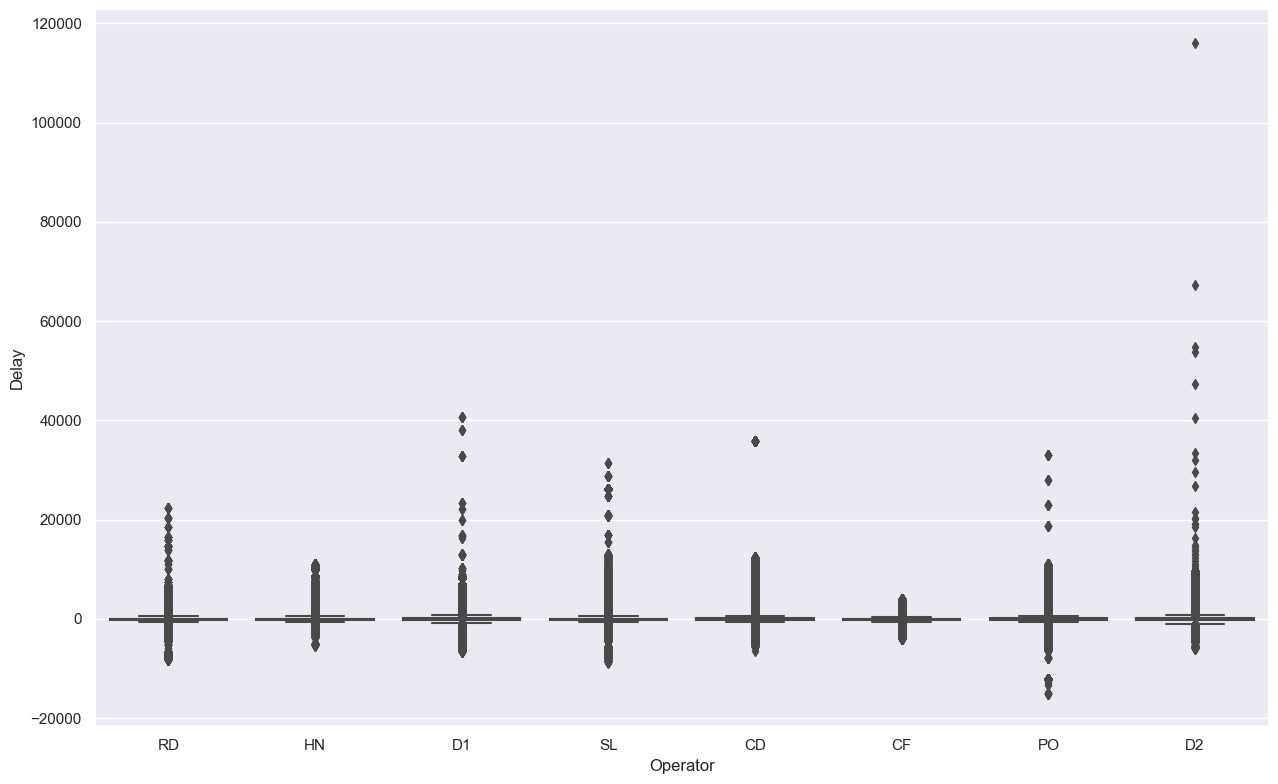

In [20]:

sns.catplot(data=df, x='Operator', y = 'Delay' ,   kind='box', height=8, aspect=1.618)

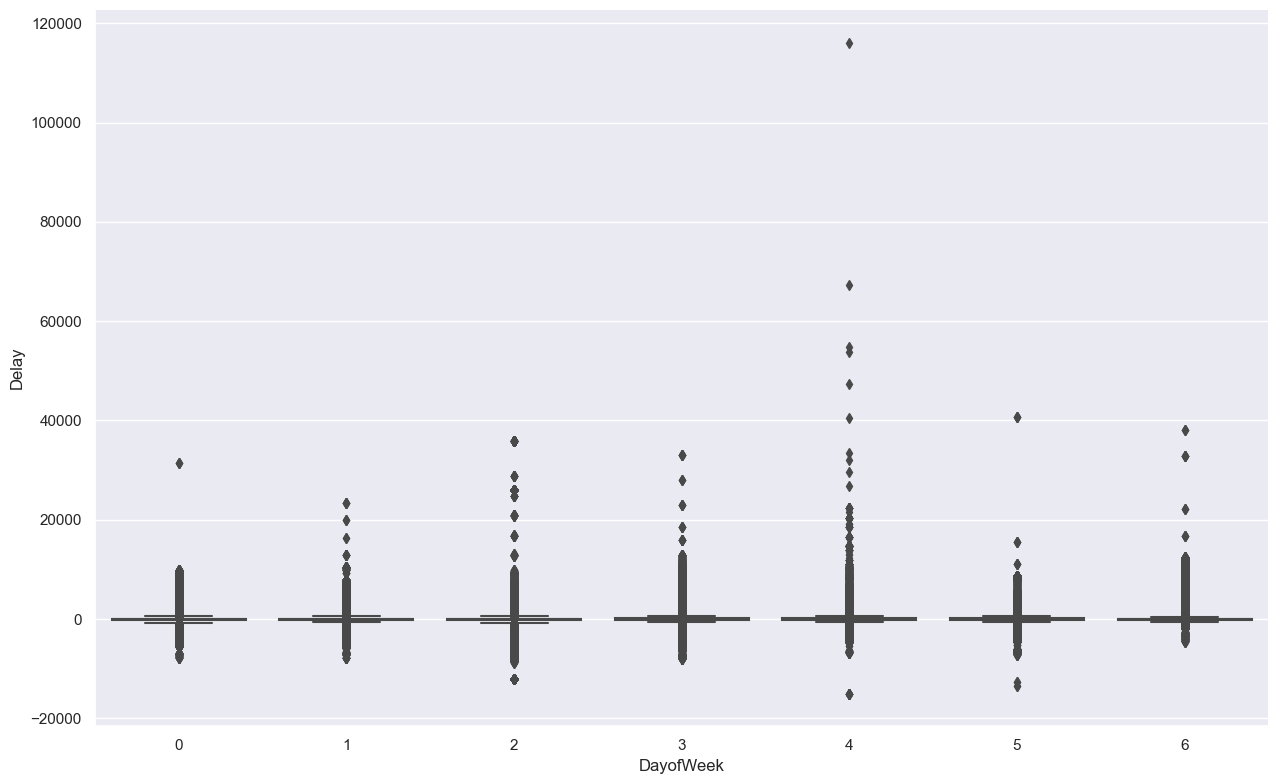

In [21]:
sns.catplot(data=df, x='DayofWeek', y = 'Delay' ,   kind='box', height=8, aspect=1.618)

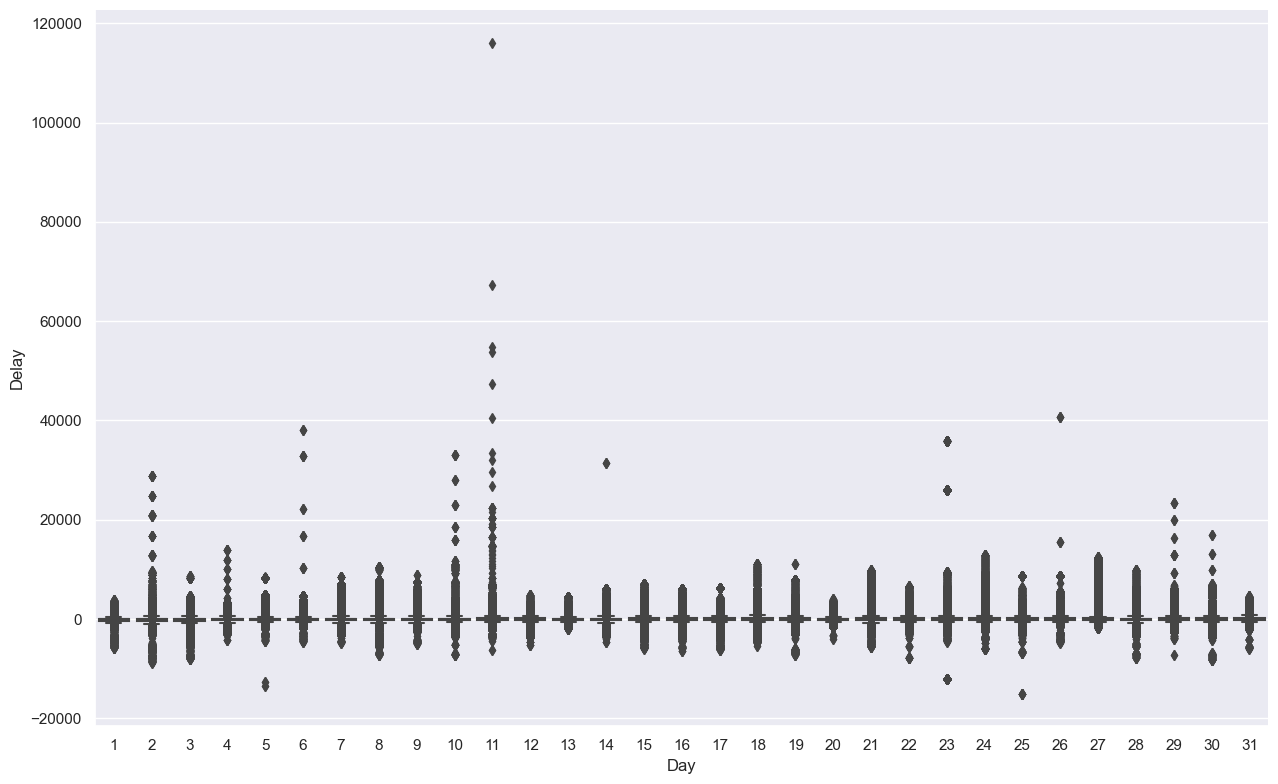

In [22]:
sns.catplot(data=df, x='Day', y = 'Delay' ,   kind='box', height=8, aspect=1.618)

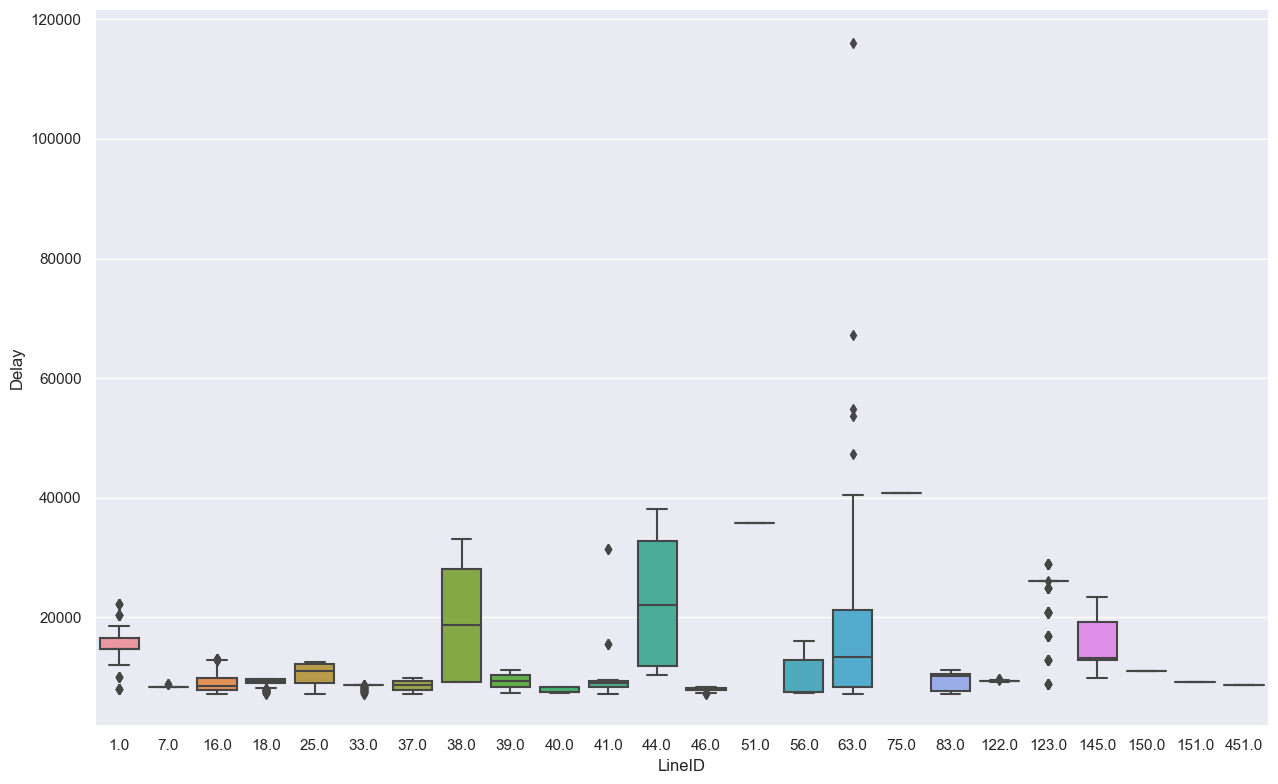

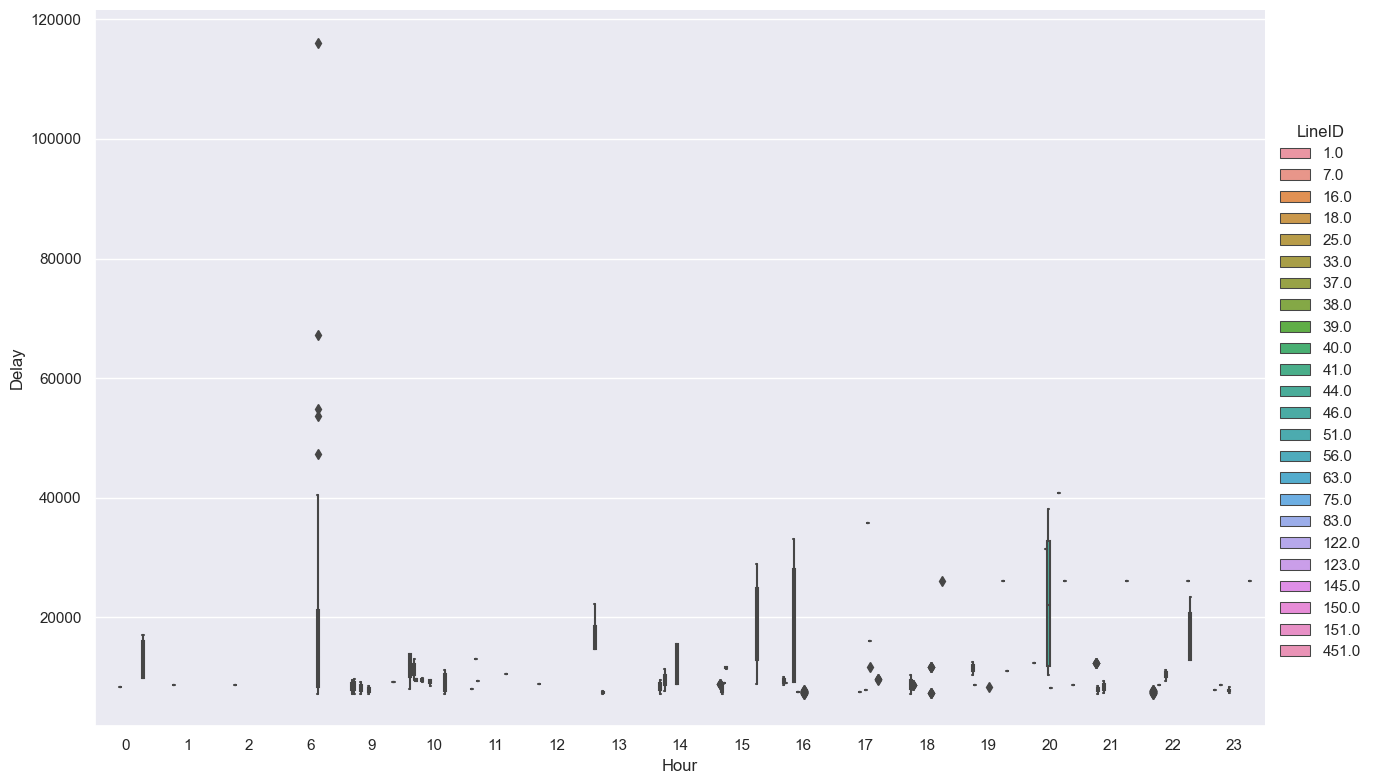

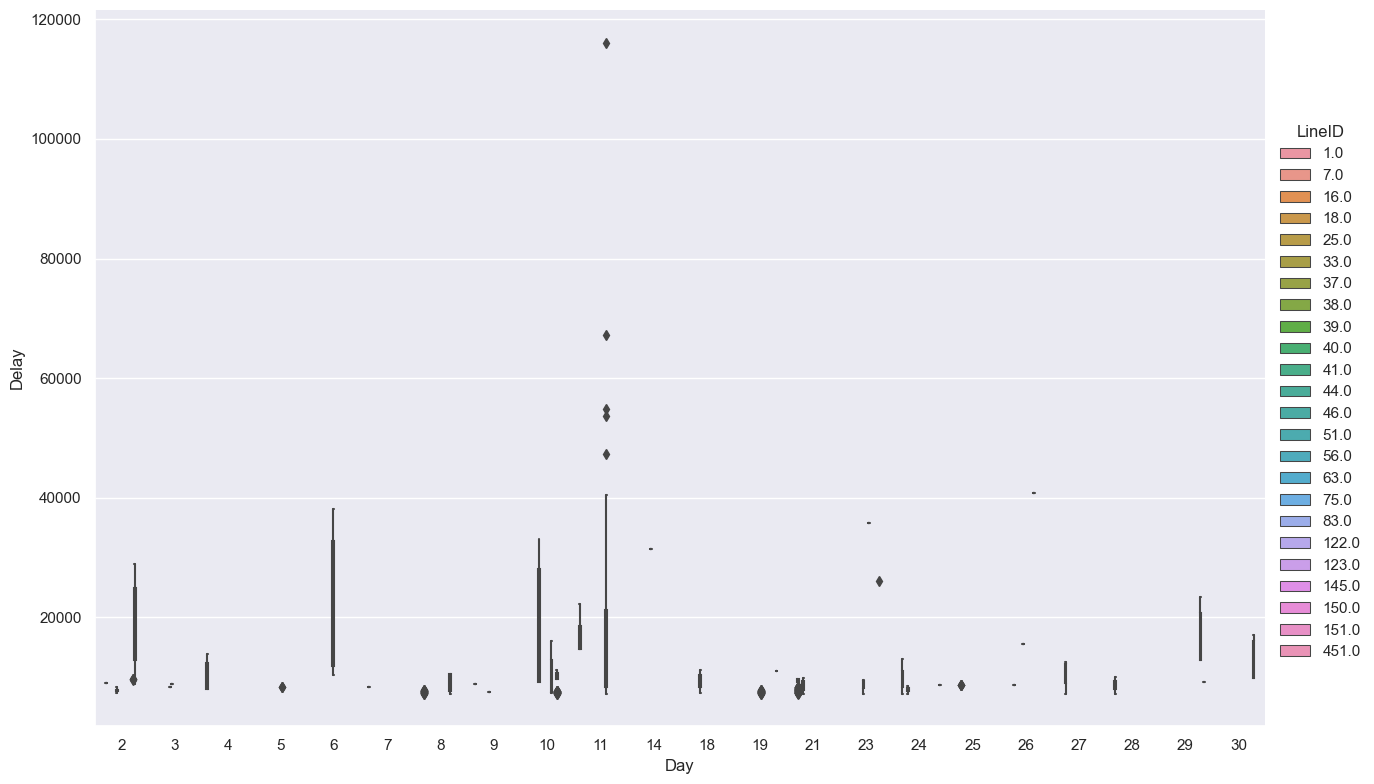

In [34]:
df_early = df[df['Delay'].astype('int64') > 7200] # buses 2 hours early :)

sns.catplot(data=df_early, x='LineID', y = 'Delay' ,   kind='box', height=8, aspect=1.618)
sns.catplot(data=df_early, x='Hour', y = 'Delay' , hue='LineID' , kind='box', height=8, aspect=1.618)
sns.catplot(data=df_early, x='Day', y = 'Delay' , hue='LineID',   kind='box', height=8, aspect=1.618)

### Remove outliers from the Delay 

In [36]:
print("old shape: ", df.shape)
df = df[df['Delay'].astype('int64') <= 7200]
print("New Shape: ", df.shape)

old shape:  (44452253, 20)
New Shape:  (44447445, 20)


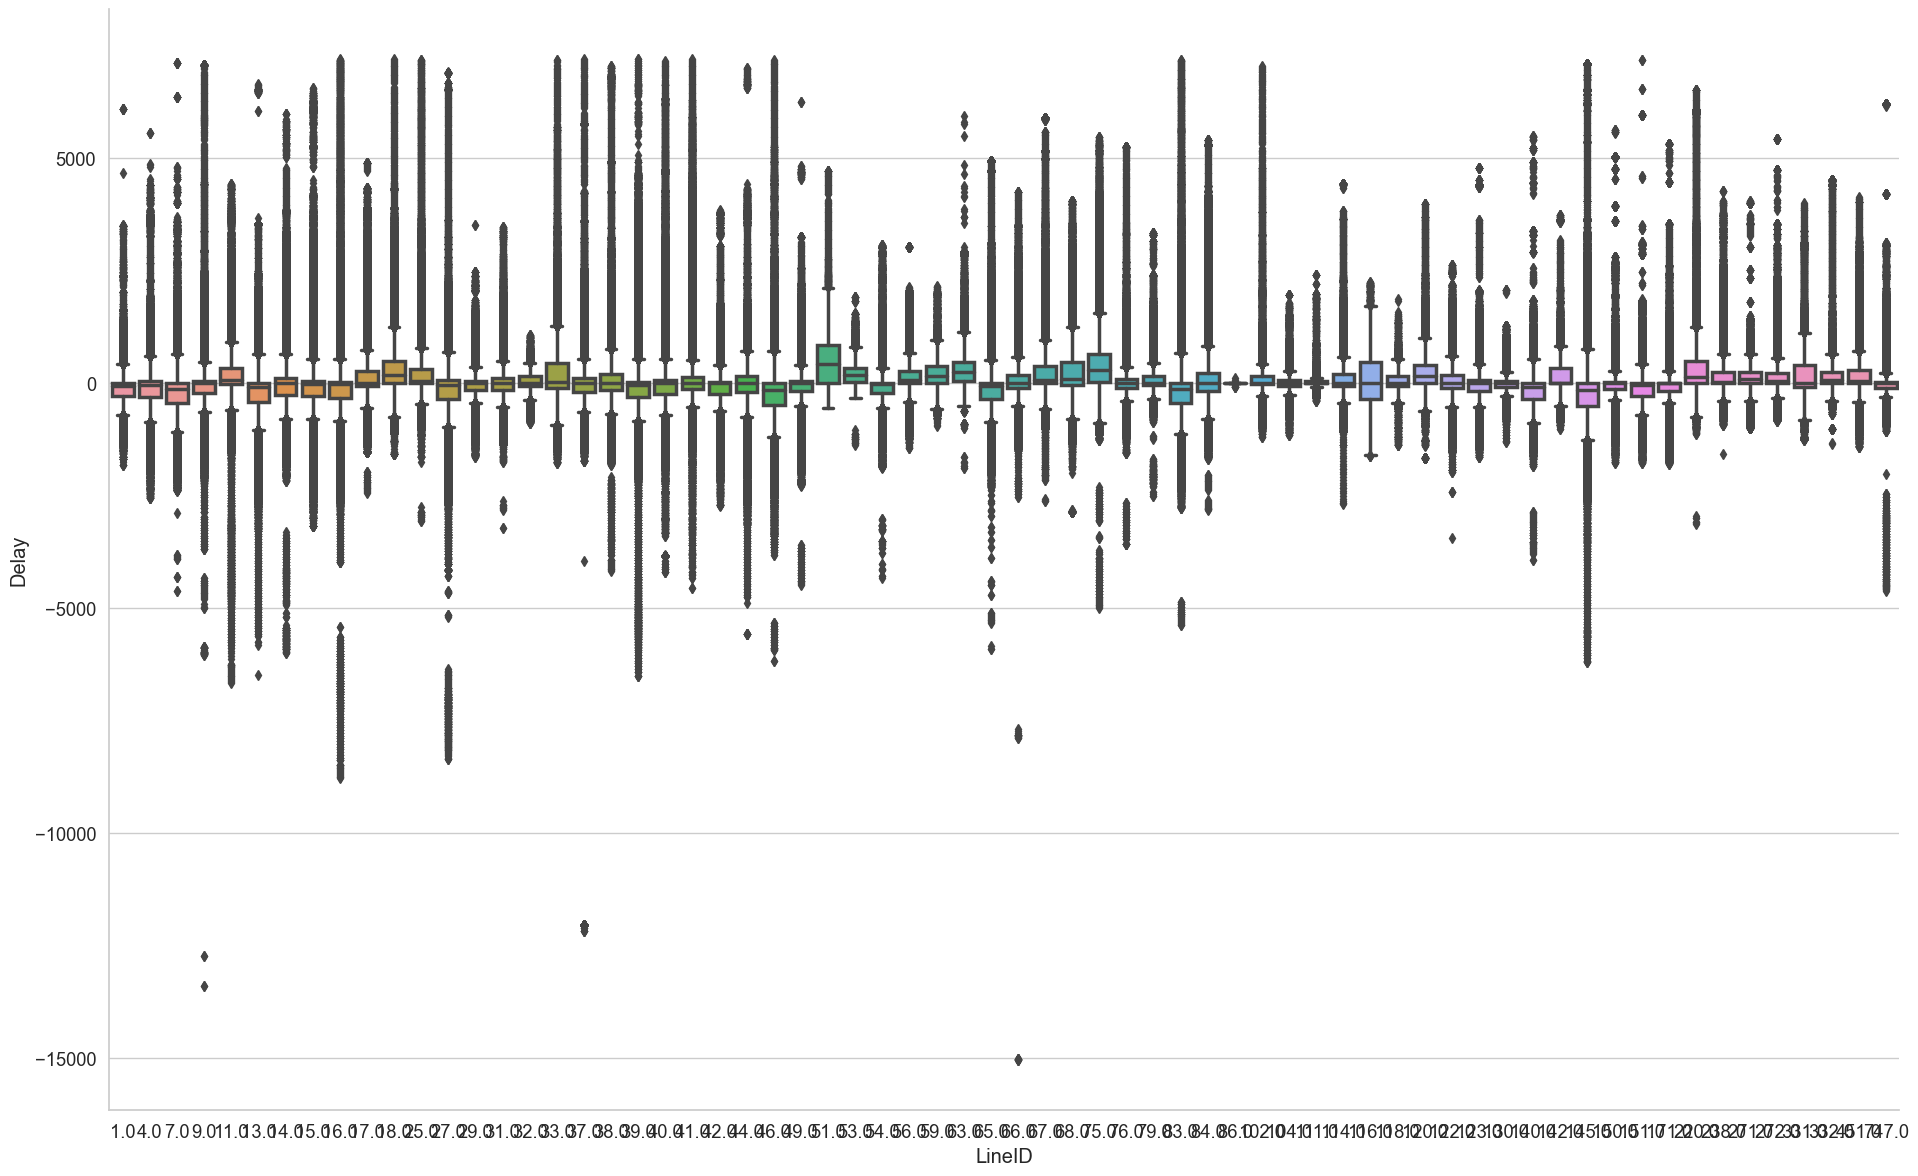

In [81]:
sns.catplot(data=df, x='LineID', y = 'Delay' , kind='box', height=12, aspect=1.618);

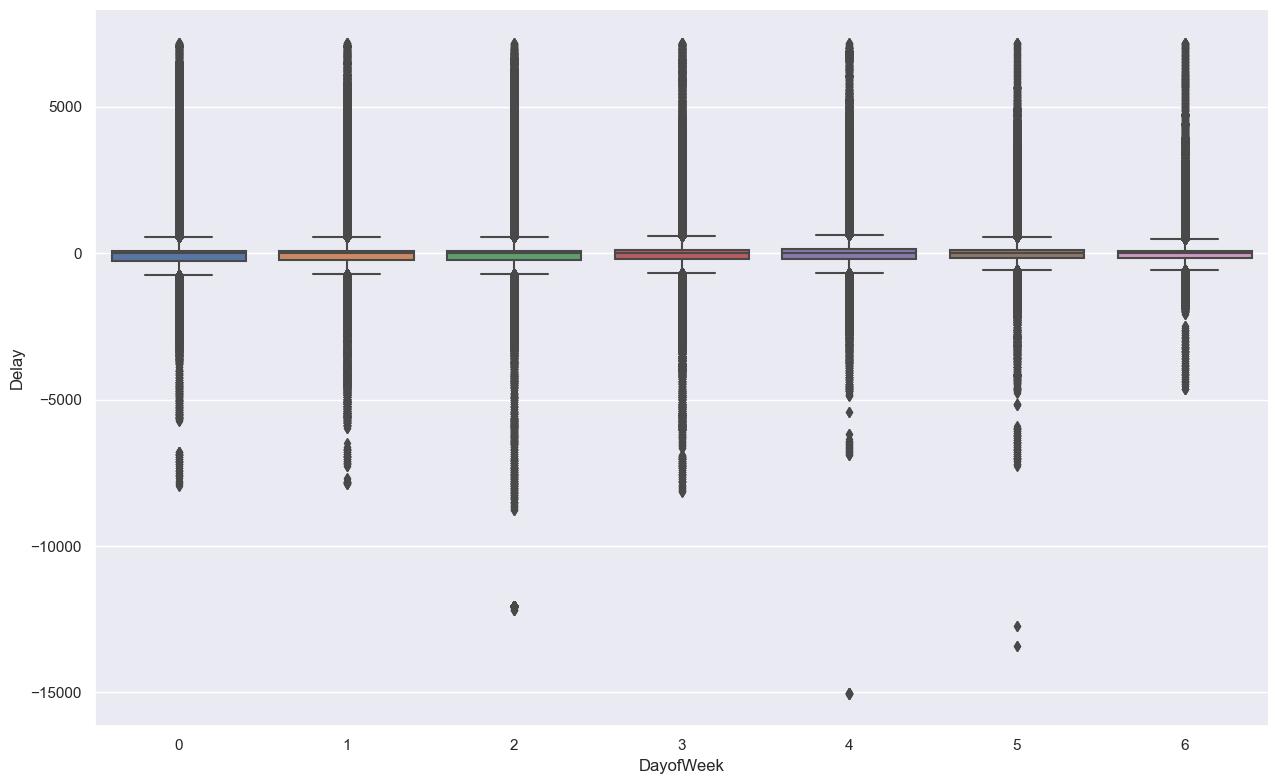

In [41]:
sns.catplot(data=df, x='DayofWeek', y = 'Delay' , kind='box', height=8, aspect=1.618);

We can see from the Correlation matrix that none of the variables in the Bus data is correlated to either Delay or Congestion variables

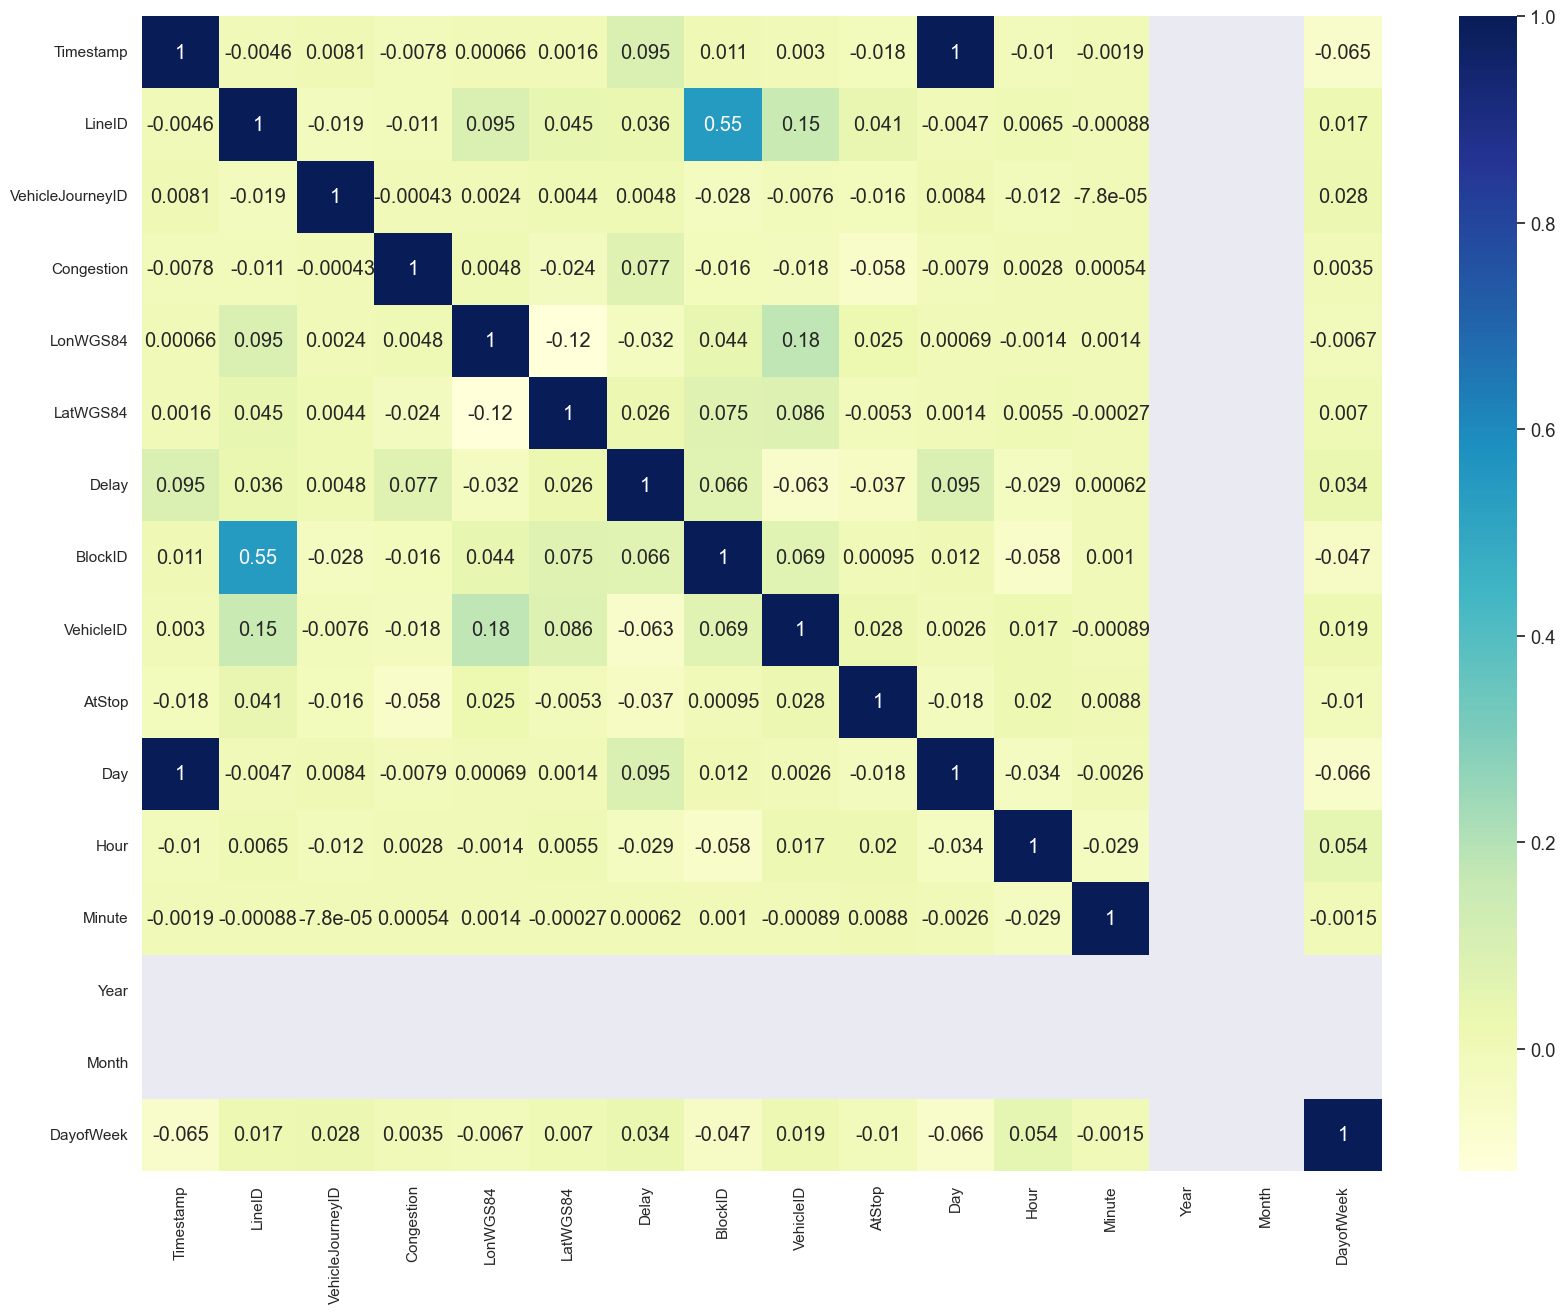

In [42]:
c_df = df.corr('pearson', numeric_only=True)
fig, ax = plt.subplots(figsize=(20,15))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_df, cmap="YlGnBu", annot=True)
plt.show()

## Display Numerical Columns


In [43]:
display(NumericalColumns)

['LineID',
 'BlockID',
 'Delay',
 'LatWGS84',
 'LonWGS84',
 'VehicleJourneyID',
 'VehicleID',
 'AtStop',
 'Timestamp']

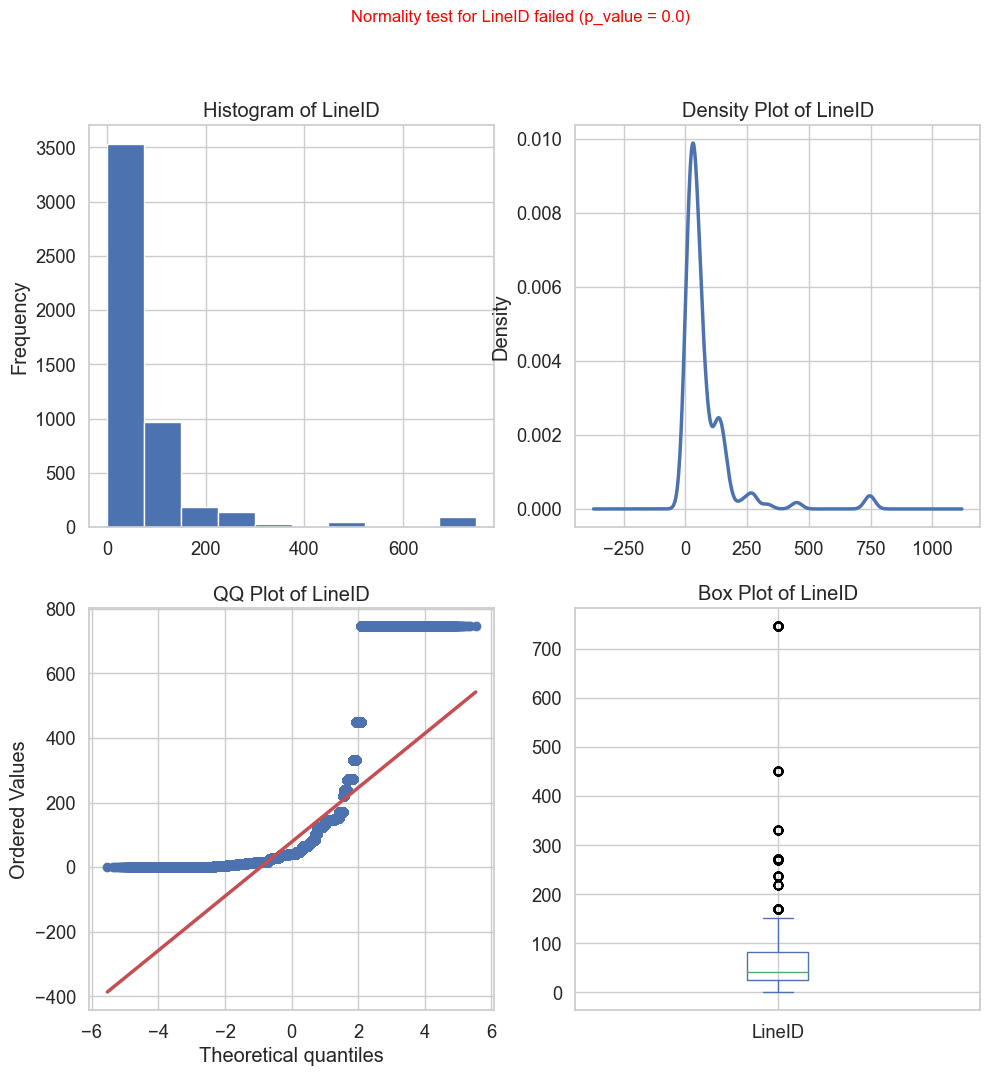

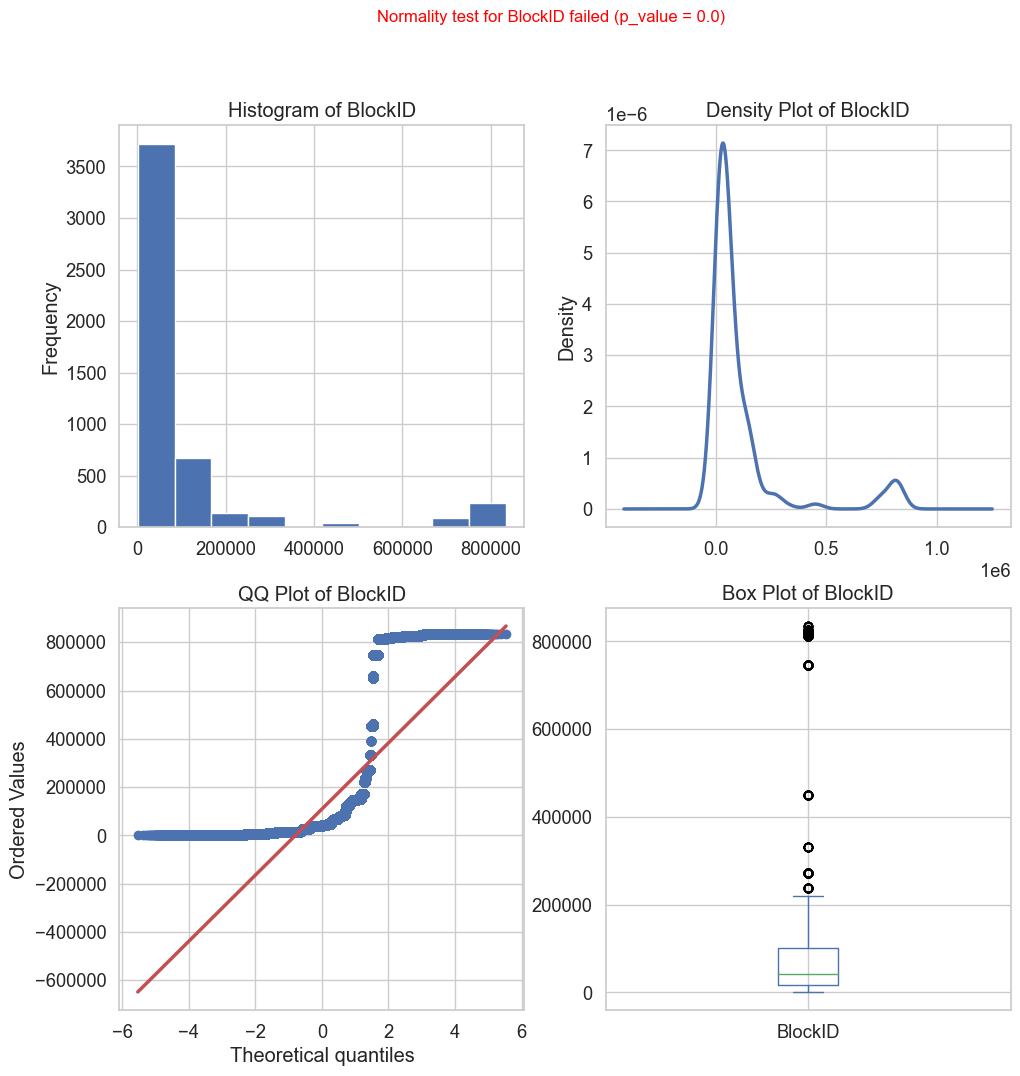

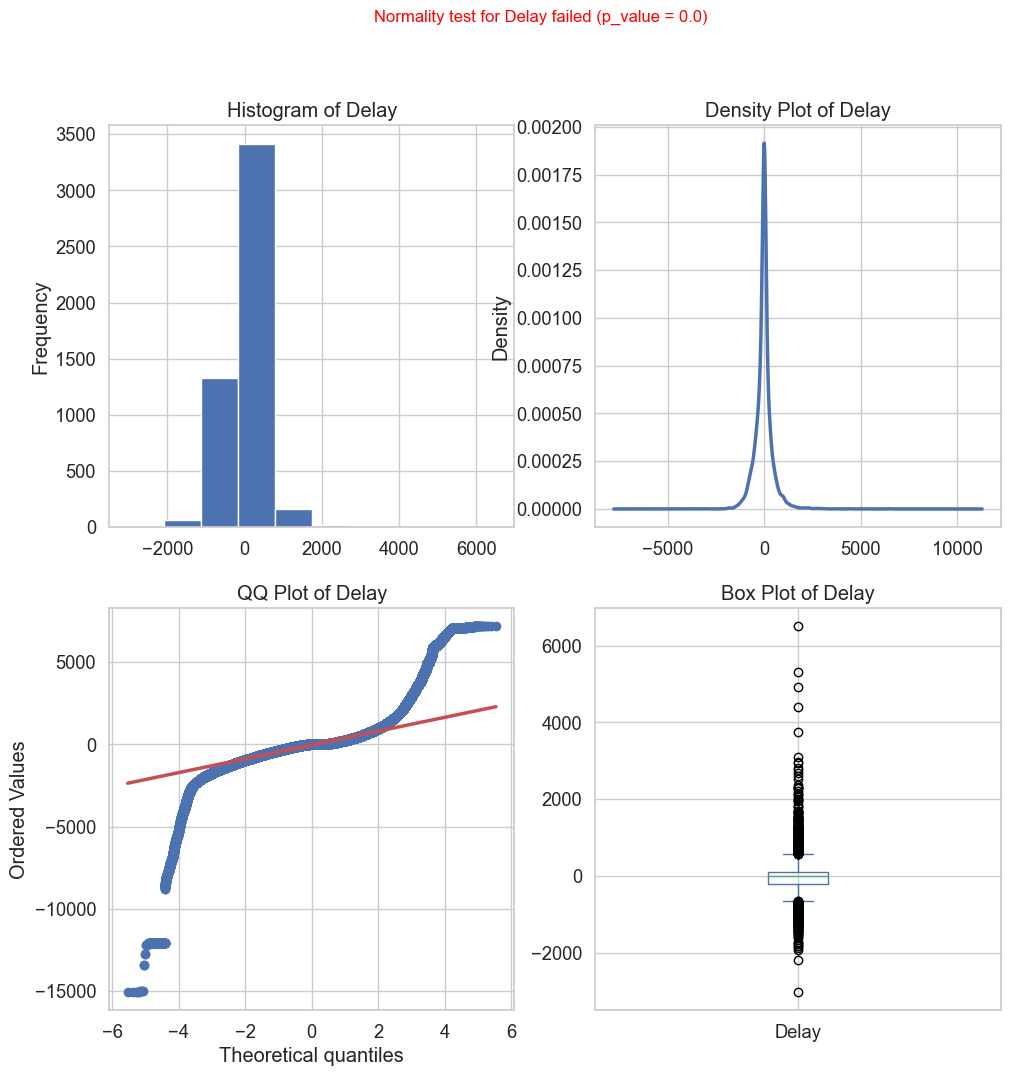

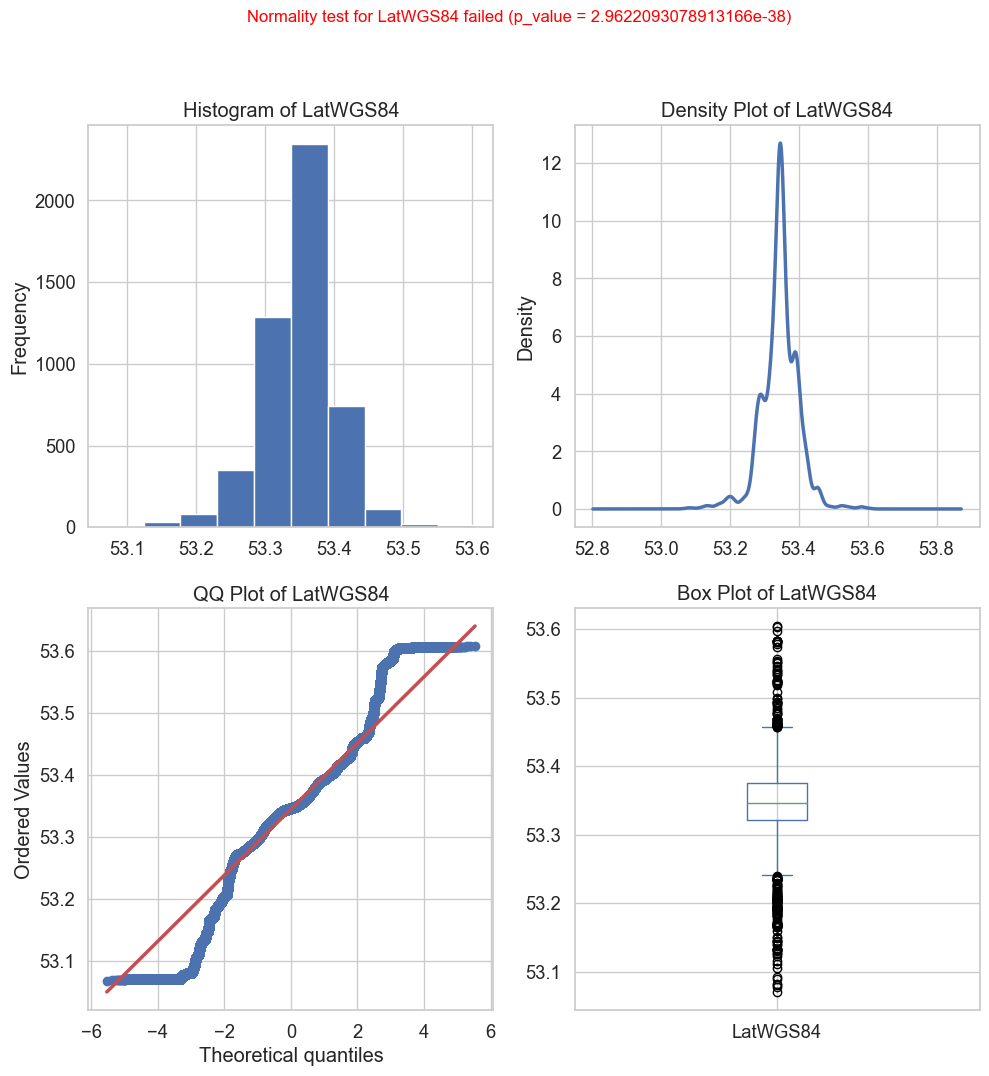

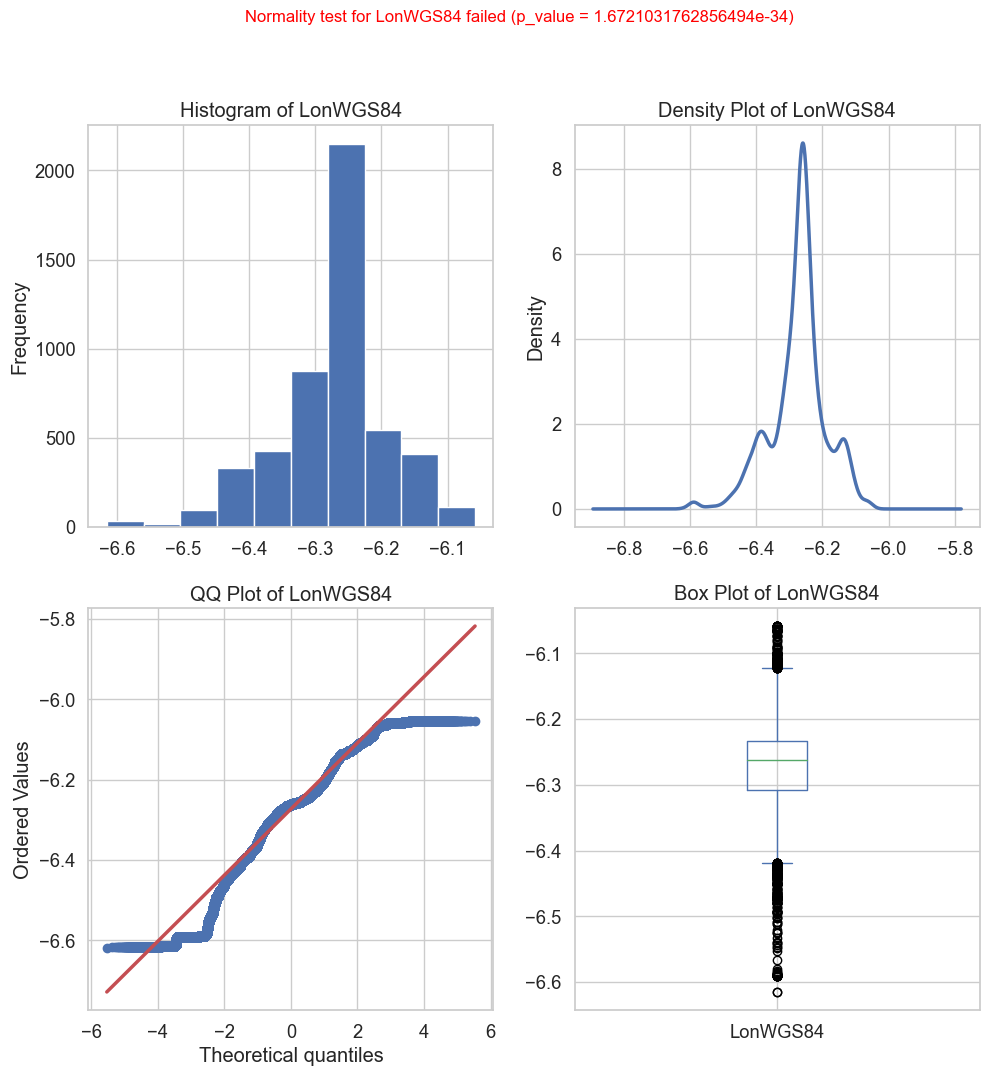

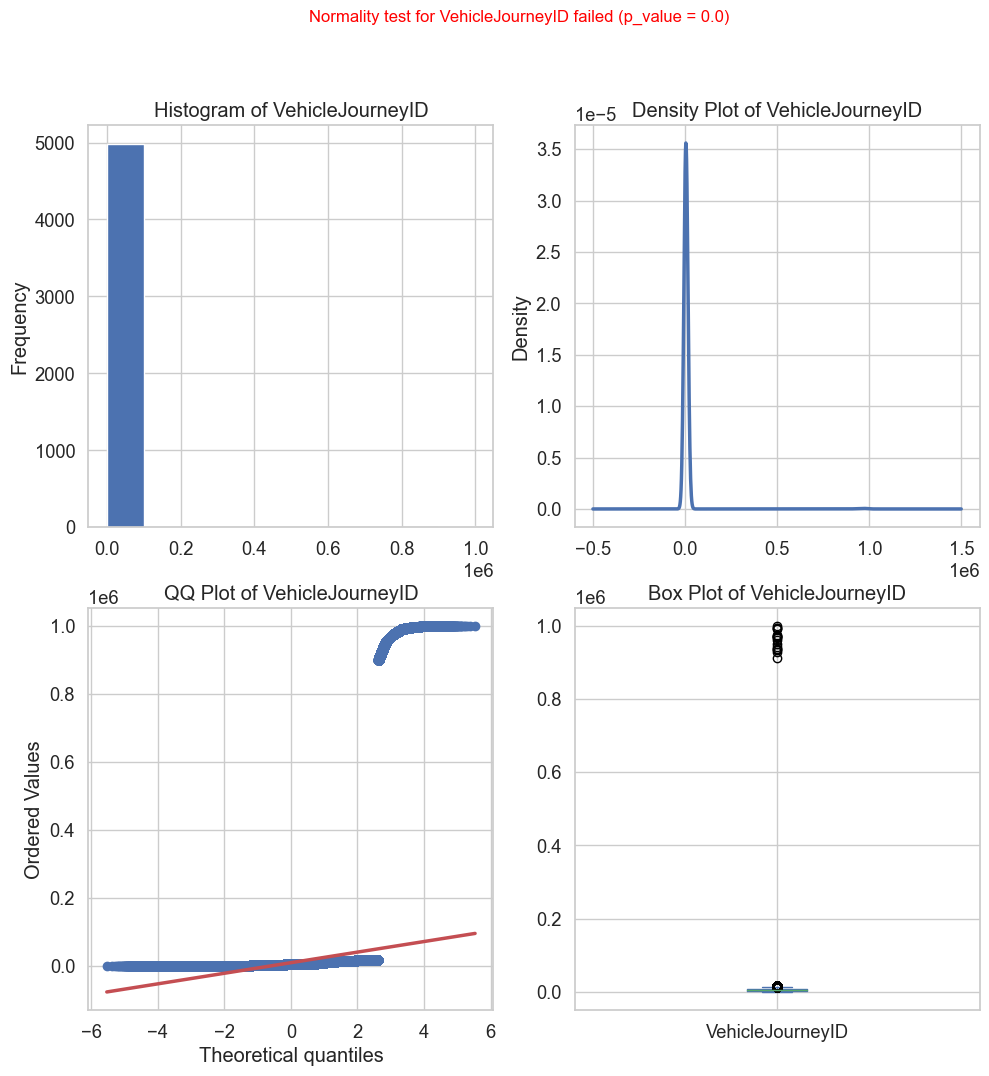

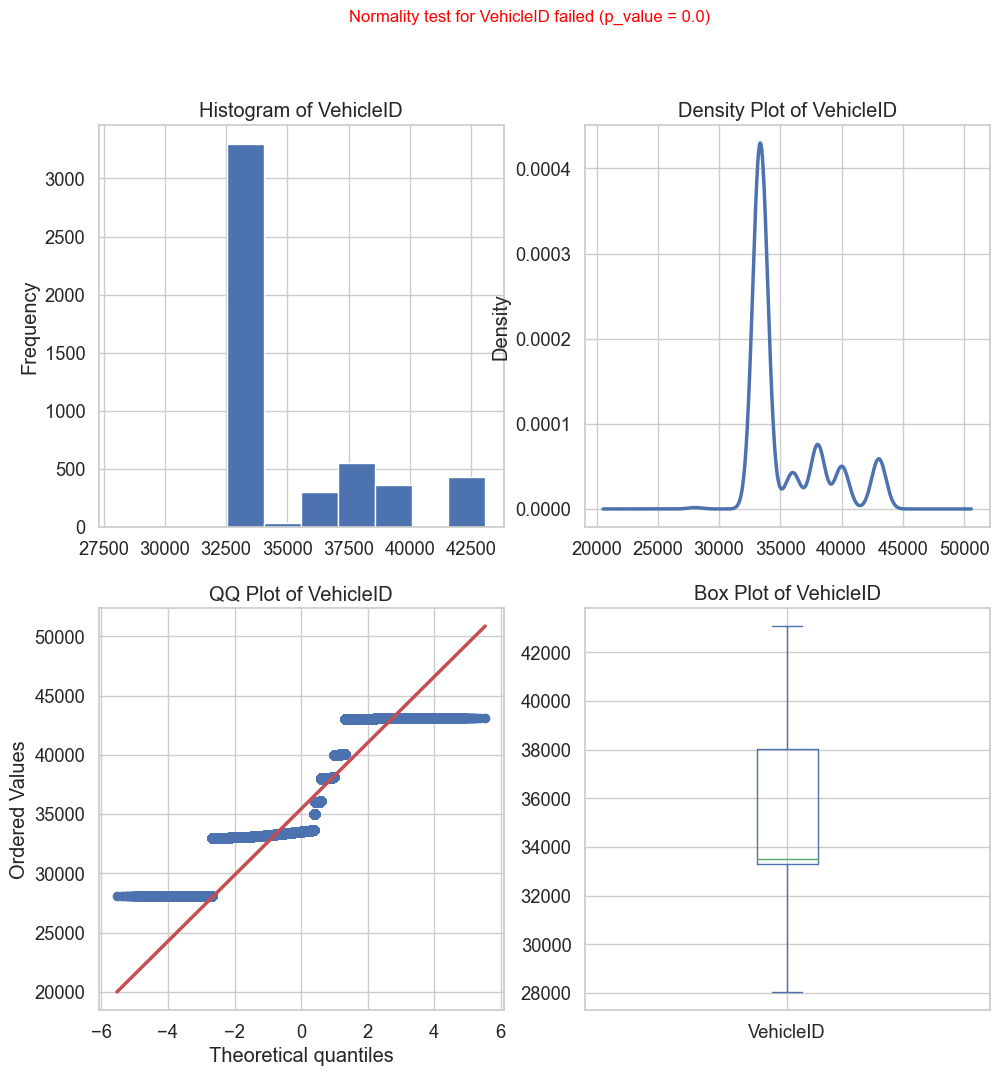

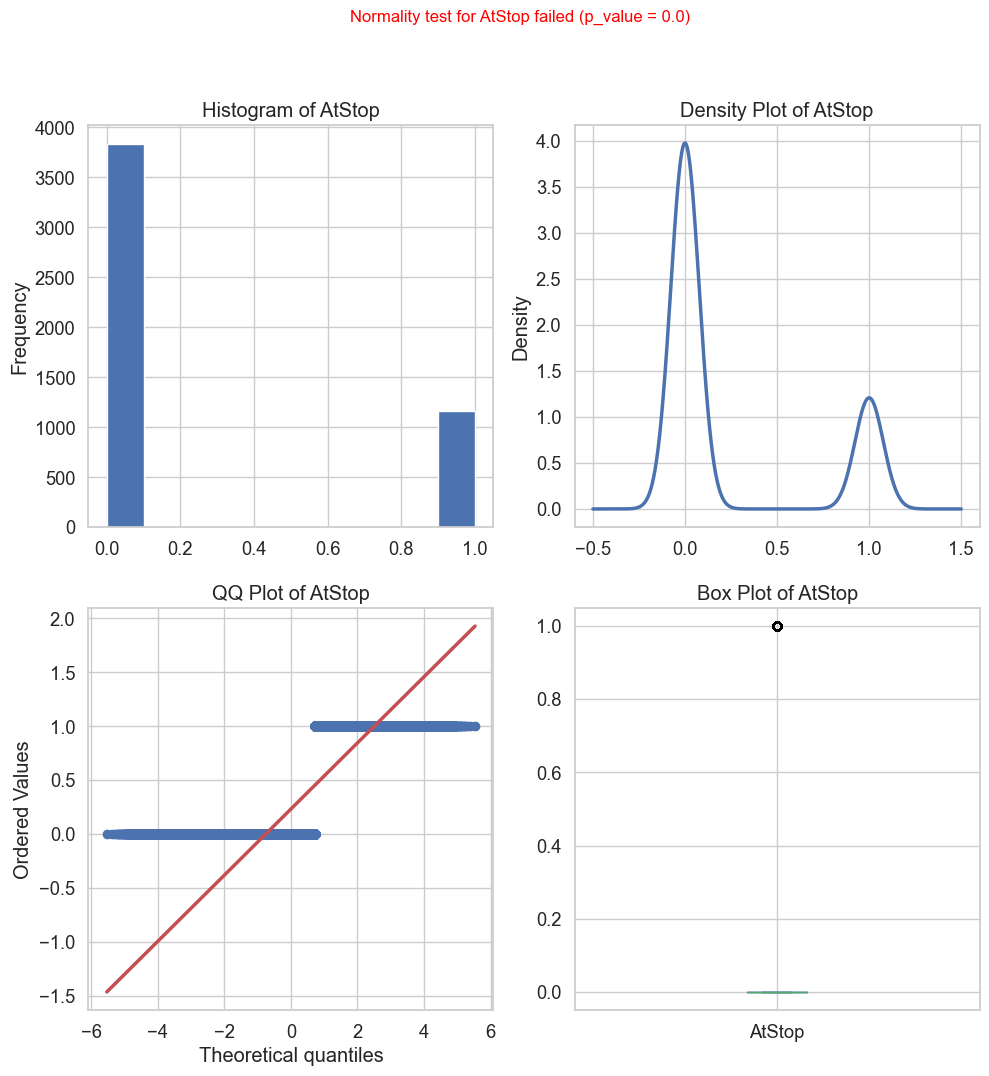

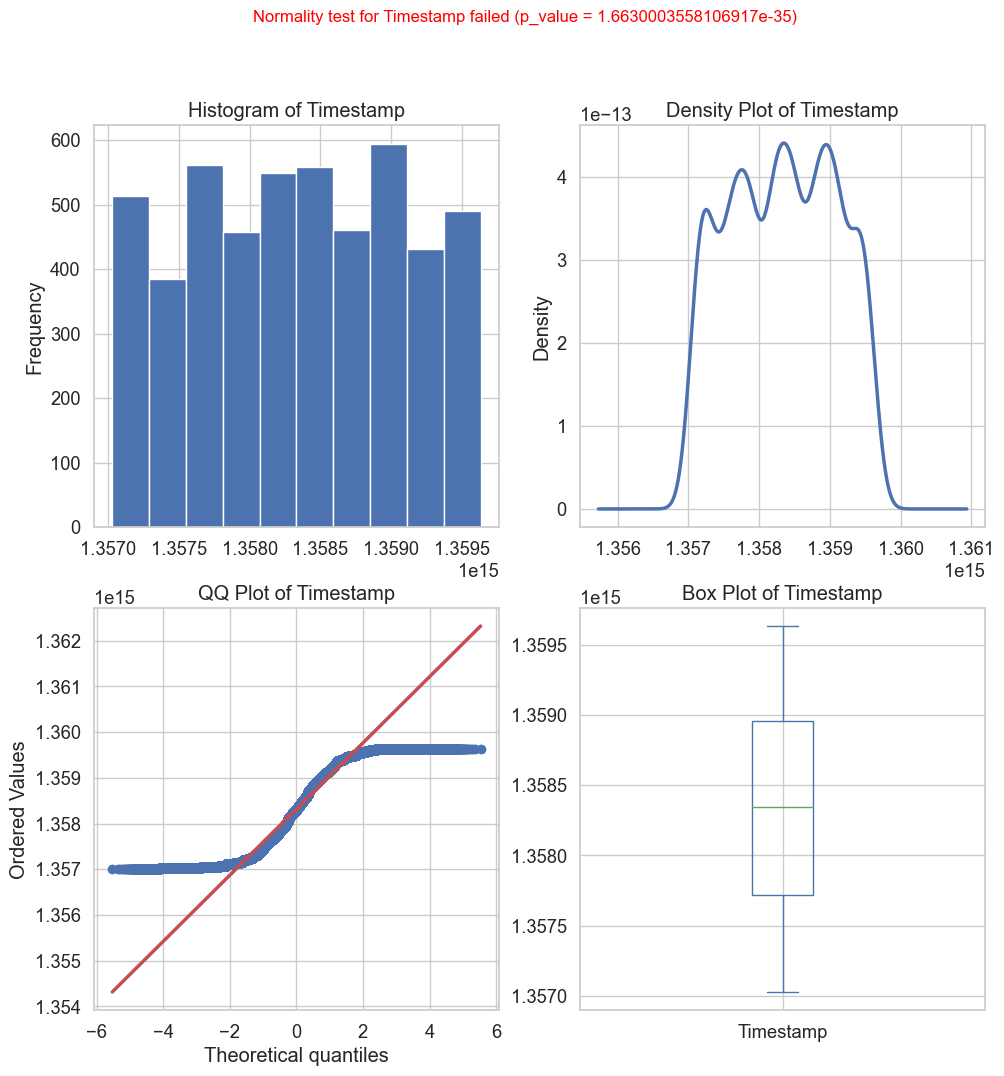

In [44]:
if len(df) > 5000: # limiting the amount of data that is being sent to the function because of memory issues 
    sampleSize = 5000
else:
    sampleSize = len(df)
for f in NumericalColumns:
    custom_barplot( df1=df.sample(sampleSize), col1=f)

In the image below we can see that there seems to be more delayed buses in the center of Dublin than there are in the suburbs

In [45]:
df['Colour'] = df['Delay'].apply(lambda x: 'Black' if (x < -300)  else 'Blue' if  (x > 300)  else 'Yellow')

C:\Users\stehayes\AppData\Local\Temp\ipykernel_20864\2751912548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Colour'] = df['Delay'].apply(lambda x: 'Black' if (x < -300)  else 'Blue' if  (x > 300)  else 'Yellow')


In [46]:
df['Ontime'] = df['Delay'].apply(lambda x: 0 if (x < -300) or (x > 300) else 1)


C:\Users\stehayes\AppData\Local\Temp\ipykernel_20864\1763843117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ontime'] = df['Delay'].apply(lambda x: 0 if (x < -300) or (x > 300) else 1)


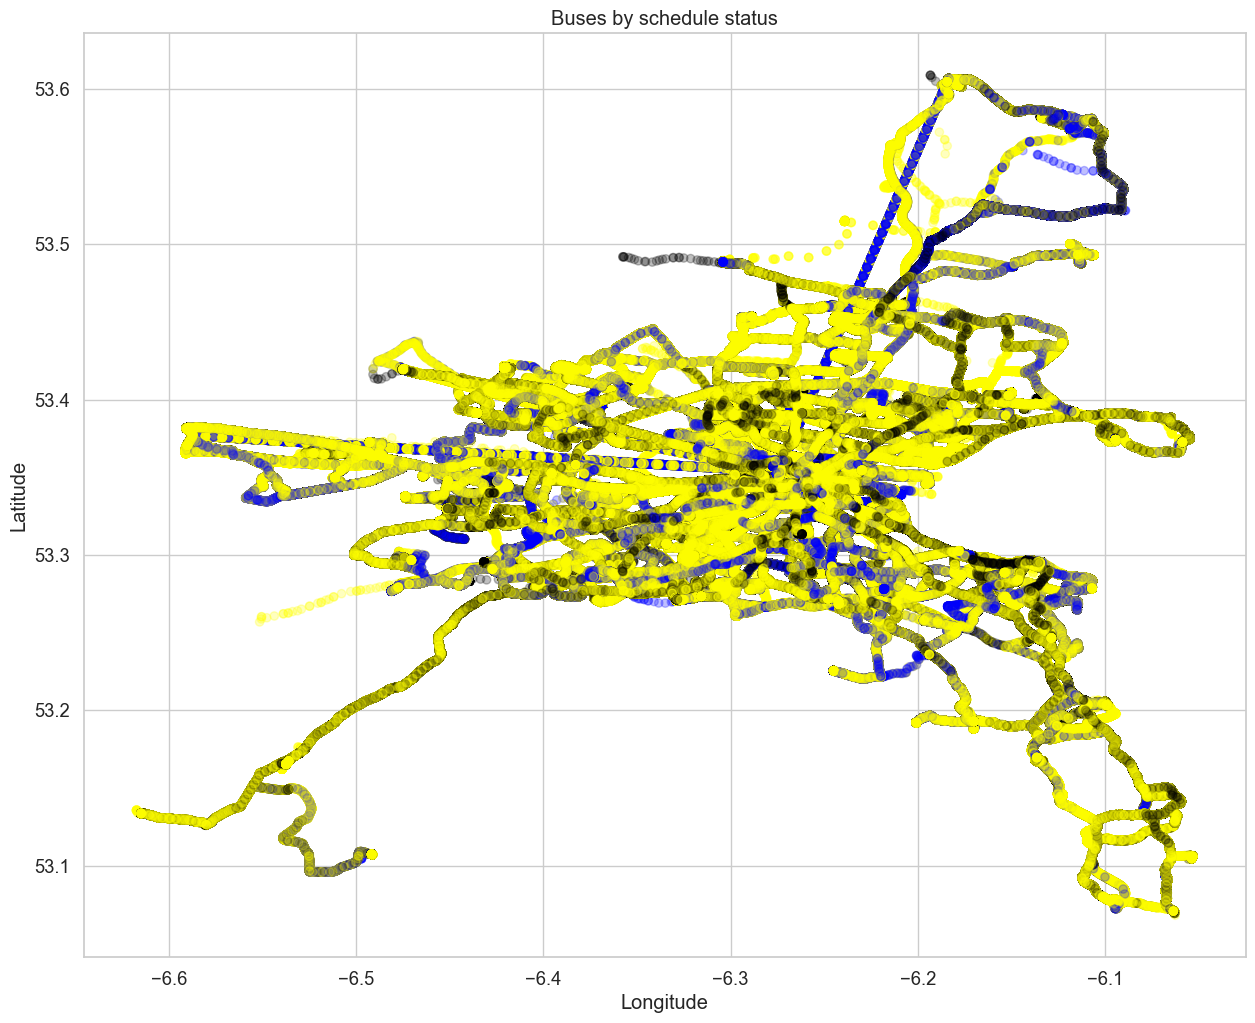

In [47]:
fig, ax = plt.subplots(figsize=(15,12))
plt.scatter(x=df['LonWGS84'], y=df['LatWGS84'], alpha=0.25,  c=df['Colour'] )
plt.title('Buses by schedule status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show();

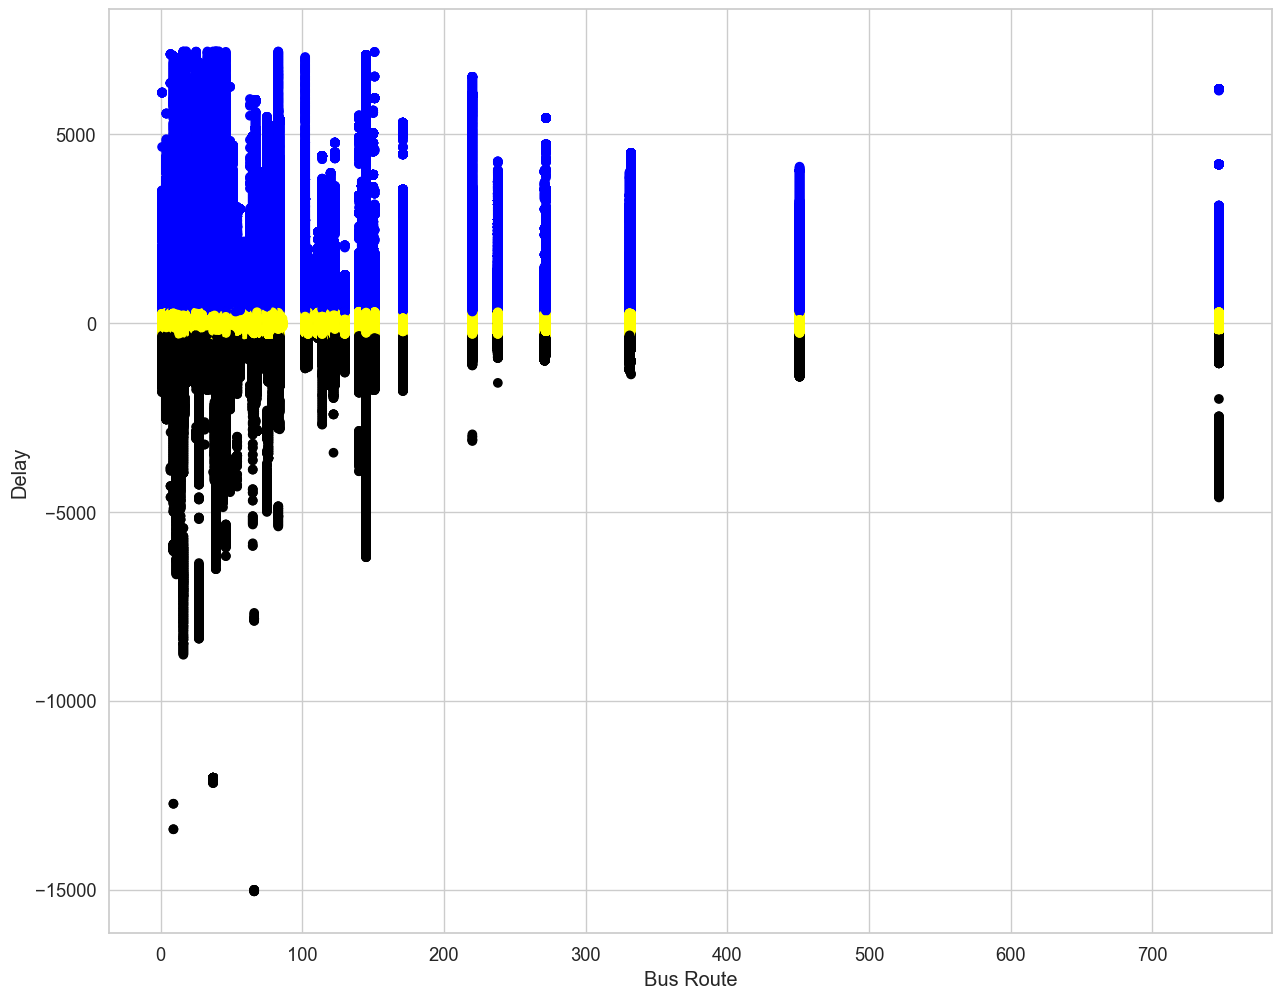

In [48]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['LineID'],df['Delay'], c=df['Colour'])
plt.ylabel('Delay')
plt.xlabel('Bus Route')
plt.show()

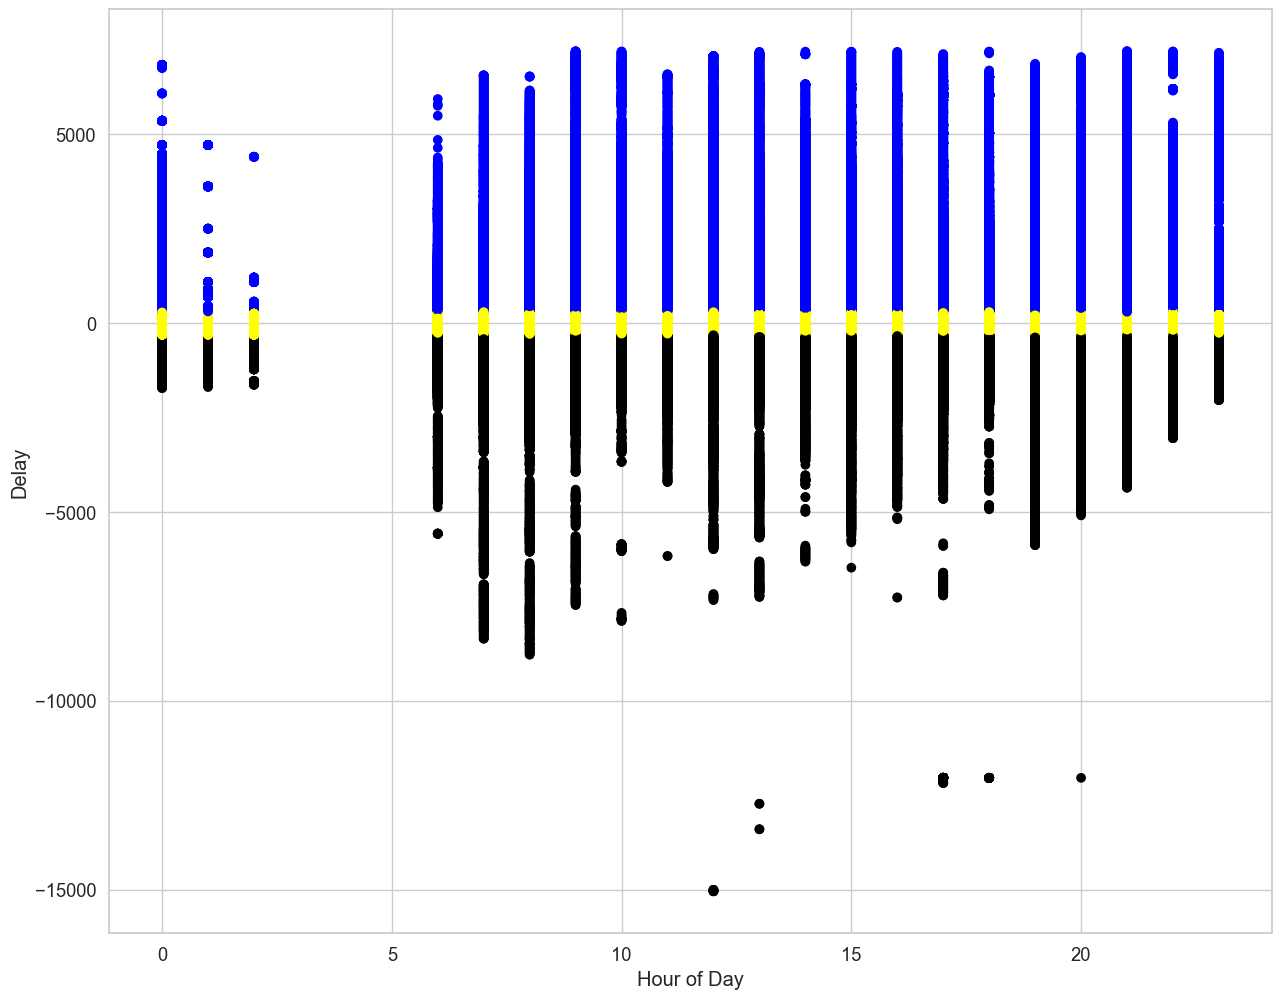

In [49]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['Hour'],df['Delay'], c=df['Colour'])
plt.ylabel('Delay')
plt.xlabel('Hour of Day')
plt.show()


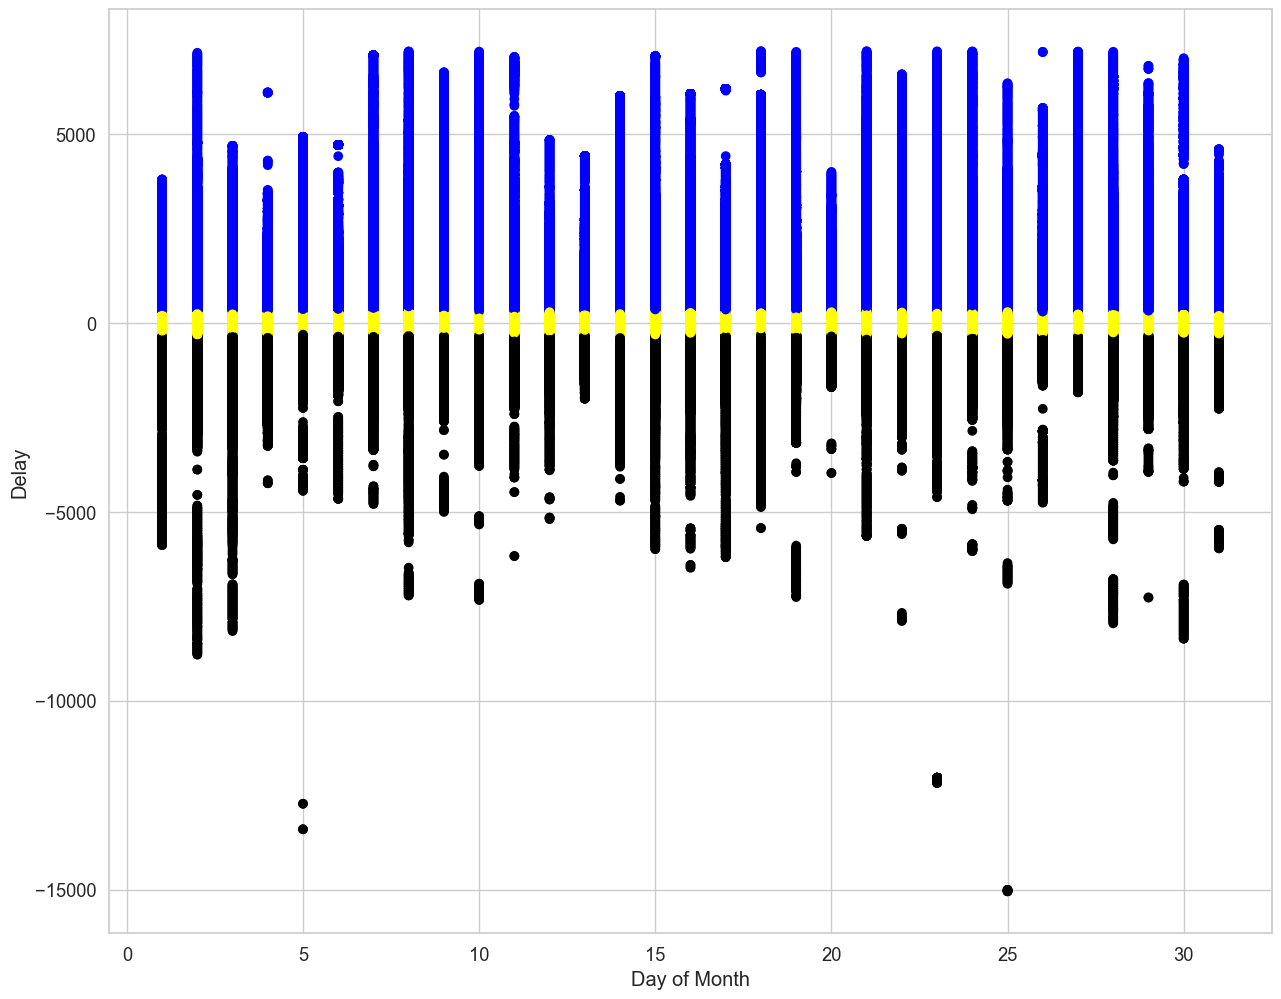

In [50]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['Day'],df['Delay'], c=df['Colour'])
plt.ylabel('Delay')
plt.xlabel('Day of Month')
plt.show()

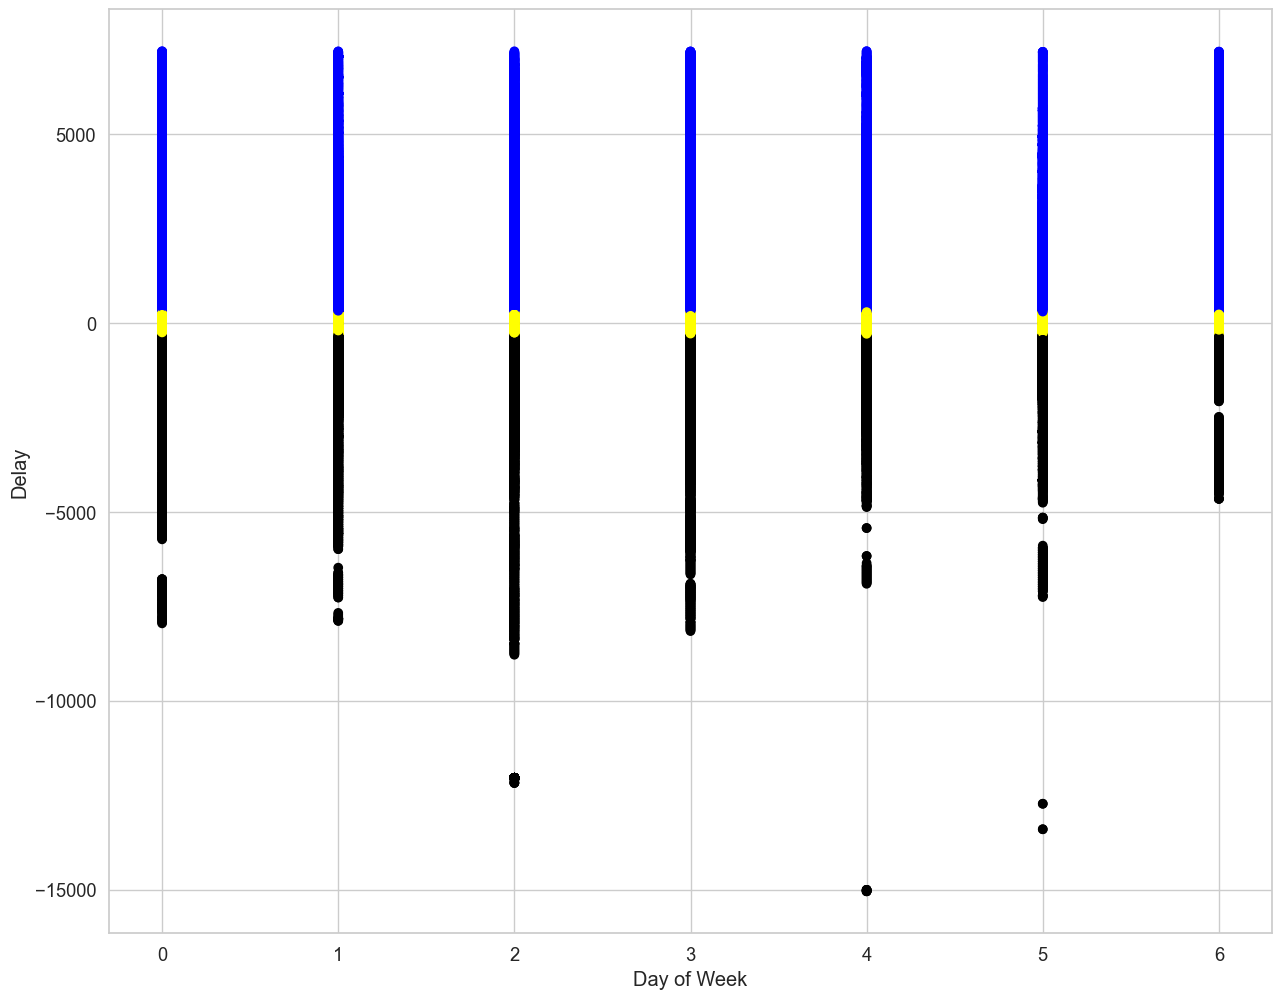

In [51]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['DayofWeek'],df['Delay'], c=df['Colour'])
plt.ylabel('Delay')
plt.xlabel('Day of Week')
plt.show()

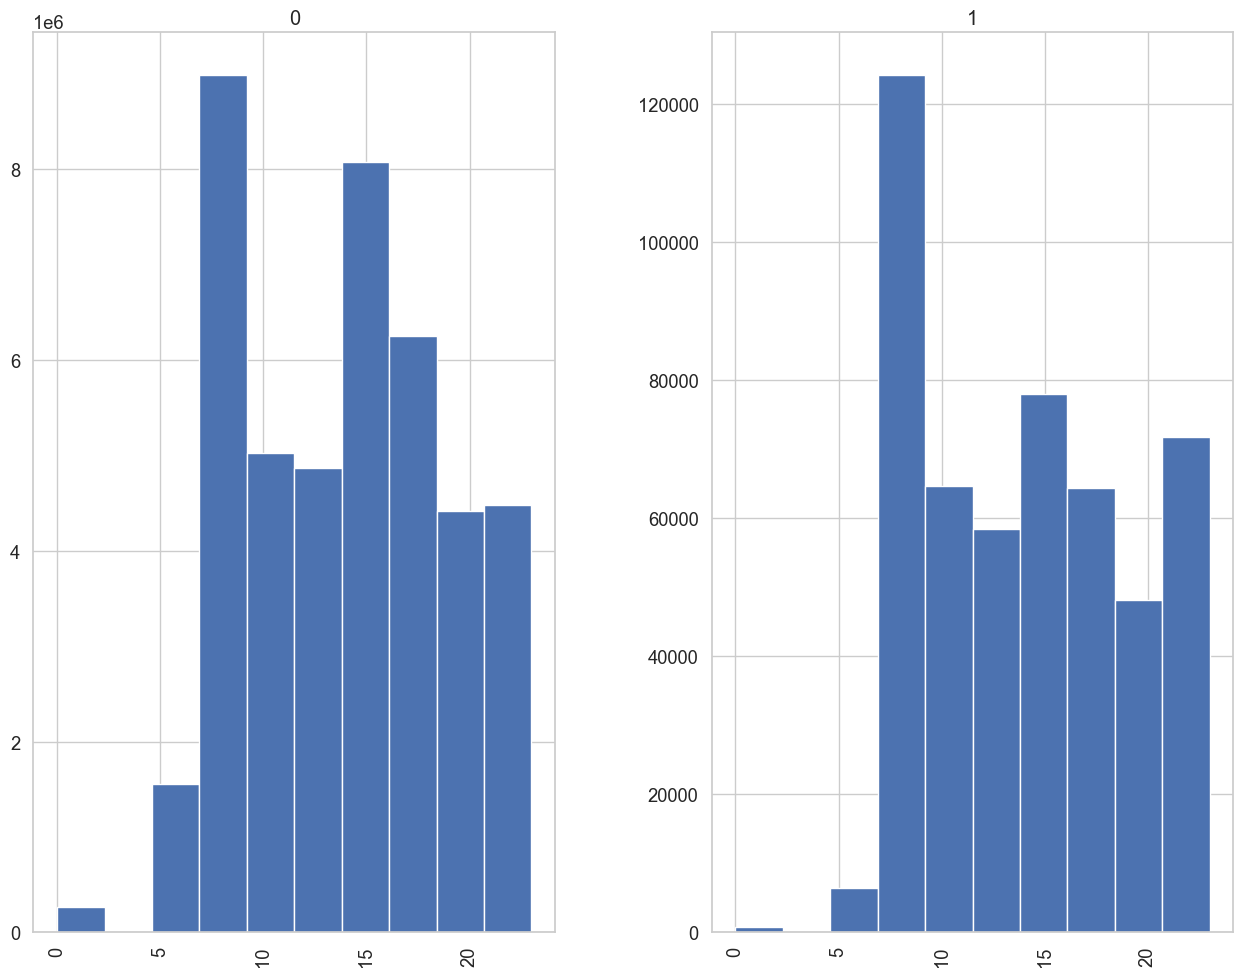

In [52]:

df.hist(by = 'Congestion', column= 'Hour', figsize=(15,12));


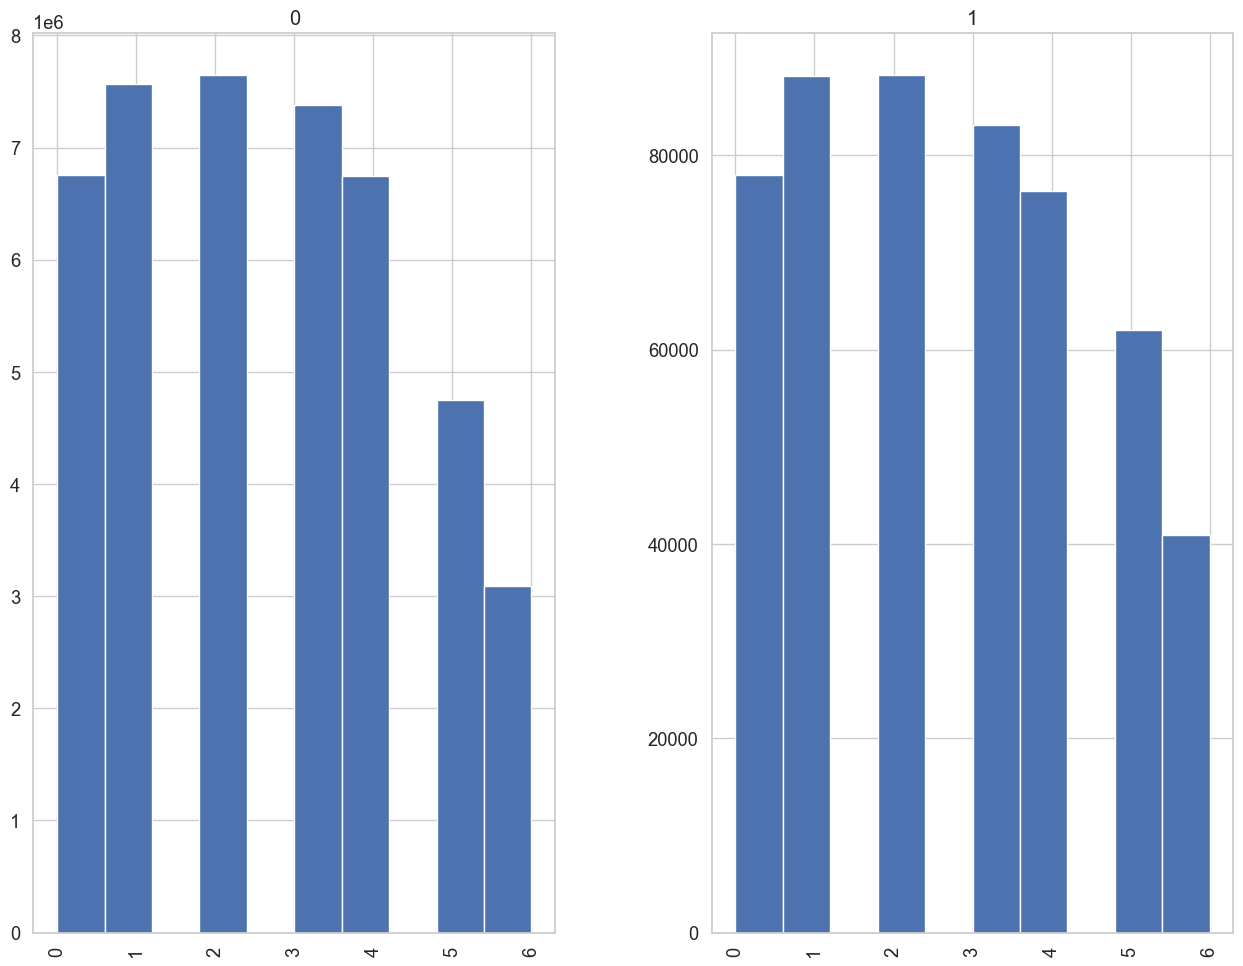

In [53]:

df.hist(by = 'Congestion', column= 'DayofWeek',figsize=(15,12));


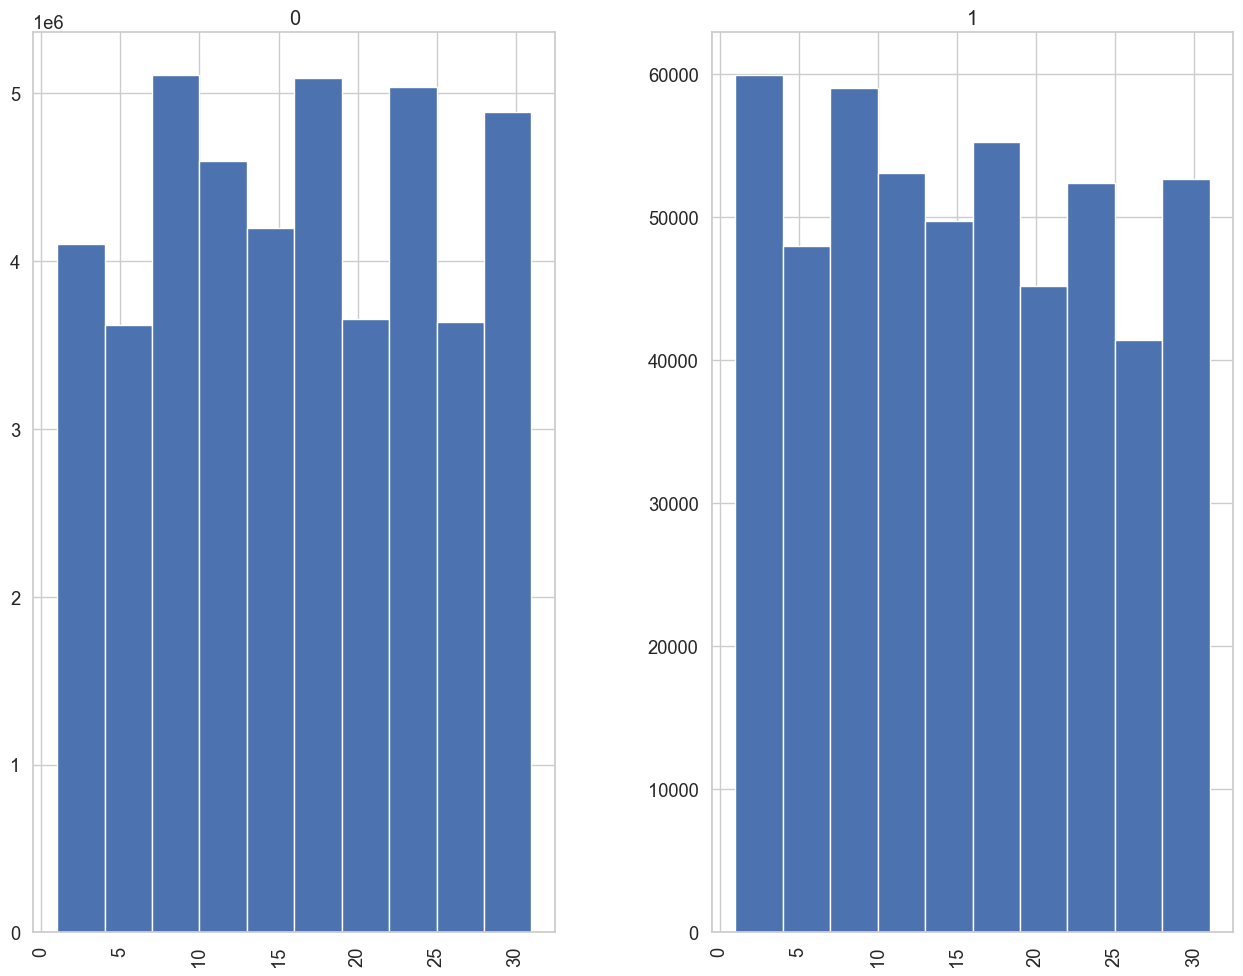

In [54]:
df.hist(by = 'Congestion', column= 'Day',figsize=(15,12));

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

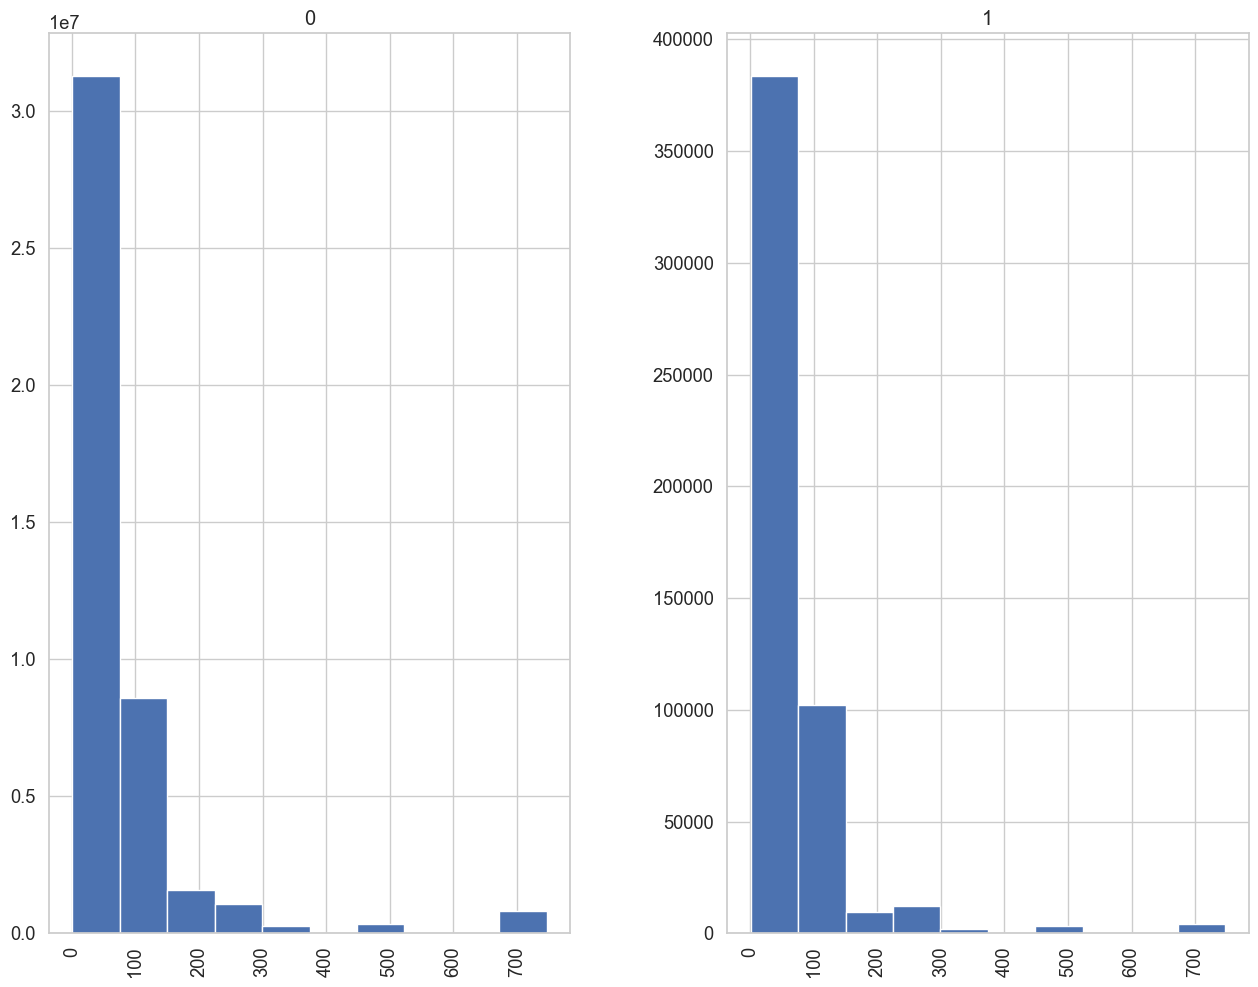

In [55]:
df.hist(by = 'Congestion', column= 'LineID',figsize=(15,12))

### Individual Bus Routes displayed

In [56]:


busRoutes = sorted(busRoutes)
w1_value = ''
w1 = None
w1 = widgets.Dropdown(
    options= busRoutes,
    value= busRoutes[0],
    description = 'Bus Route',
    )

i = interactive(custom_scatterplot, df1 =fixed(df), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)


# Download the weather station details https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv
## Download the weather stations csv file

In [57]:
df.to_parquet('./Data/CleanedBusData.parquet')
df.shape

(44447445, 22)

In [58]:
url = 'https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv'


### Load the weather statio details for Dublin
Get the information for the Dublin weather stations -done

In [59]:
weatherStations = pd.read_csv(url)
weatherStations = weatherStations[weatherStations['county'].str.contains('Dublin')]
weatherStations.head(10)

county  station name                              name  height(m)  \
575  Dublin         10323            STILLORGAN (FARMLEIGH)         67   
576  Dublin         10123       DUBLIN (FITZWILLIAM SQUARE)         16   
577  Dublin         10223  ROYAL BOTANIC GARDENS (GLASNEVIN         17   
578  Dublin          1223                    BELGARD CASTLE        125   
579  Dublin           632                         LUSK G.S.         23   
580  Dublin          1232           KINSALEY (AGR.RES.STN.)         19   
581  Dublin          2523                 DUBLIN (Ringsend)          7   
582  Dublin          2623                      HOWTH CASTLE         11   
583  Dublin          2723          STILLORGAN (VARTRY HSE.)         80   
584  Dublin          2732                         ARDGILLAN         62   

     easting  northing  latitude  longitude open year close year  
575   320514    227230  53.28194   -6.19389      1915       1935  
576   316404    233098  53.33556   -6.25333      1908       1937  
577   315083    237179  53.37250   -6.27167      1880       1925  
578   307400    229300  53.30278   -6.38889      1914       1963  
579   321700    254300  53.52500   -6.16528      1949       2012  
580   321500    242900  53.42222   -6.17222      1961       2004  
581   318900    233900  53.34167   -6.21389      1911     (null)  
582   327900    239000  53.38611   -6.07778      1913       1971  
583   320200    226800  53.27778   -6.19722      1915       1999  
584   321791    261102  53.58583   -6.16167      1894       1938

In [60]:
dublinStations = weatherStations[["station name", "name"]]



In [61]:
dublinStations.columns = [x.strip().replace(' ', '') for x in dublinStations.columns]


### Loop through this data and download the hourly weather data into Data/Weather folder - done

In [62]:
for rows in dublinStations.itertuples():
    # get hourly weather data
    url = "http://cli.fusio.net/cli/climate_data/webdata/hly" + str(rows.stationname) + ".zip"
    print(url)
    dest = './Zips/MetEirrean/hly' + str(rows.stationname) + ".zip"
    try:
        weatherFile = rq.urlretrieve(url, dest)
        continue
    except Exception:
        print('No file exists')  
    # # get the daily weather data - ONLY USING THE HOURLY DATA FOR NOW
    # url = "http://cli.fusio.net/cli/climate_data/webdata/dly" + str(rows.stationname) + ".zip"
    # print(url)
    # dest = './Zips/MetEirrean/dly' + str(rows.stationname) + ".zip"
    # try:
    #     weatherFile = rq.urlretrieve(url, dest)
    #     continue
    # except Exception:
    #     print('No file exists')  

http://cli.fusio.net/cli/climate_data/webdata/hly10323.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly10123.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly10223.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1223.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly632.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1232.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2523.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2623.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2723.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2732.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1323.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2823.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1332.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly

In [63]:
import zipfile as zip
    # Zip creates its own folders - no need to check for folder existence
files = os.listdir('./Zips/MetEirrean/')
WDfiles = [f for f in files if f.startswith('hly')]
for f in WDfiles:
    fp = './Zips/MetEirrean/' + f
    with zip.ZipFile(fp,  mode='r') as arc: 
        arc.extractall('./Data/MetEirrean/')



In [64]:
files = os.listdir('./Data/MetEirrean/')  
WDfiles = [f for f in files if f.endswith('.csv')] # need to remove the empty files

### Read the weather data and load in the hourly weather data between the min and max dates - done

In [65]:
Phoenix_wdf = pd.read_csv('./Data/MetEirrean/hly175.csv', delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, na_values='NAN')

Phoenix_wdf['datetime'] = pd.to_datetime(Phoenix_wdf['date'])
Phoenix_wdf['Year'] = Phoenix_wdf['datetime'].dt.year
Phoenix_wdf['Month'] = Phoenix_wdf['datetime'].dt.month
Phoenix_wdf['Day'] = Phoenix_wdf['datetime'].dt.day
Phoenix_wdf['Time'] = Phoenix_wdf['datetime'].dt.time
Phoenix_wdf['Hour'] = Phoenix_wdf['datetime'].dt.hour
Phoenix_wdf['Minute'] = Phoenix_wdf['datetime'].dt.minute
Phoenix_wdf['DayofWeek'] = Phoenix_wdf['datetime'].dt.day_of_week
#Filter the weather data to January 2013
Phoenix_wdf = Phoenix_wdf[Phoenix_wdf['Year'] == 2013]
Phoenix_wdf = Phoenix_wdf[Phoenix_wdf['Month'] == 1]
Phoenix_wdf = Phoenix_wdf.astype({"rain": float})
Phoenix_wdf = Phoenix_wdf.astype({"temp": float})
Phoenix_wdf = Phoenix_wdf.astype({"wetb": float})
Phoenix_wdf = Phoenix_wdf.astype({"dewpt": float})
Phoenix_wdf = Phoenix_wdf.astype({"vappr": float})
Phoenix_wdf = Phoenix_wdf.astype({"rhum": float})
Phoenix_wdf = Phoenix_wdf.astype({"msl": float})


Phoenix_wdf.dtypes

C:\Users\stehayes\AppData\Local\Temp\ipykernel_20864\652057656.py:1: DtypeWarning: Columns (2,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  Phoenix_wdf = pd.read_csv('./Data/MetEirrean/hly175.csv', delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, na_values='NAN')


date                 object
ind                   int64
rain                float64
ind.1                 int64
temp                float64
ind.2                 int64
wetb                float64
dewpt               float64
vappr               float64
rhum                float64
msl                 float64
datetime     datetime64[ns]
Year                  int64
Month                 int64
Day                   int64
Time                 object
Hour                  int64
Minute                int64
DayofWeek             int64
dtype: object

In [66]:
ColumnsToExclude = ('ind', 'ind.1', 'ind.2')
Phoenix_wdf = dropcols_func(Phoenix_wdf, ColumnsToExclude)
Phoenix_wdf.head()

date  rain  temp  wetb  dewpt  vappr  rhum     msl  \
82223  01-jan-2013 00:00   0.0   3.1   2.4    1.4    6.8  88.0  1000.2   
82224  01-jan-2013 01:00   0.0   3.3   2.5    1.2    6.6  85.0  1000.8   
82225  01-jan-2013 02:00   0.0   2.9   2.2    1.2    6.7  88.0  1001.2   
82226  01-jan-2013 03:00   0.0   2.7   2.1    1.1    6.6  89.0  1001.8   
82227  01-jan-2013 04:00   0.1   2.5   1.9    1.0    6.6  90.0  1002.5   

                 datetime  Year  Month  Day      Time  Hour  Minute  DayofWeek  
82223 2013-01-01 00:00:00  2013      1    1  00:00:00     0       0          1  
82224 2013-01-01 01:00:00  2013      1    1  01:00:00     1       0          1  
82225 2013-01-01 02:00:00  2013      1    1  02:00:00     2       0          1  
82226 2013-01-01 03:00:00  2013      1    1  03:00:00     3       0          1  
82227 2013-01-01 04:00:00  2013      1    1  04:00:00     4       0          1

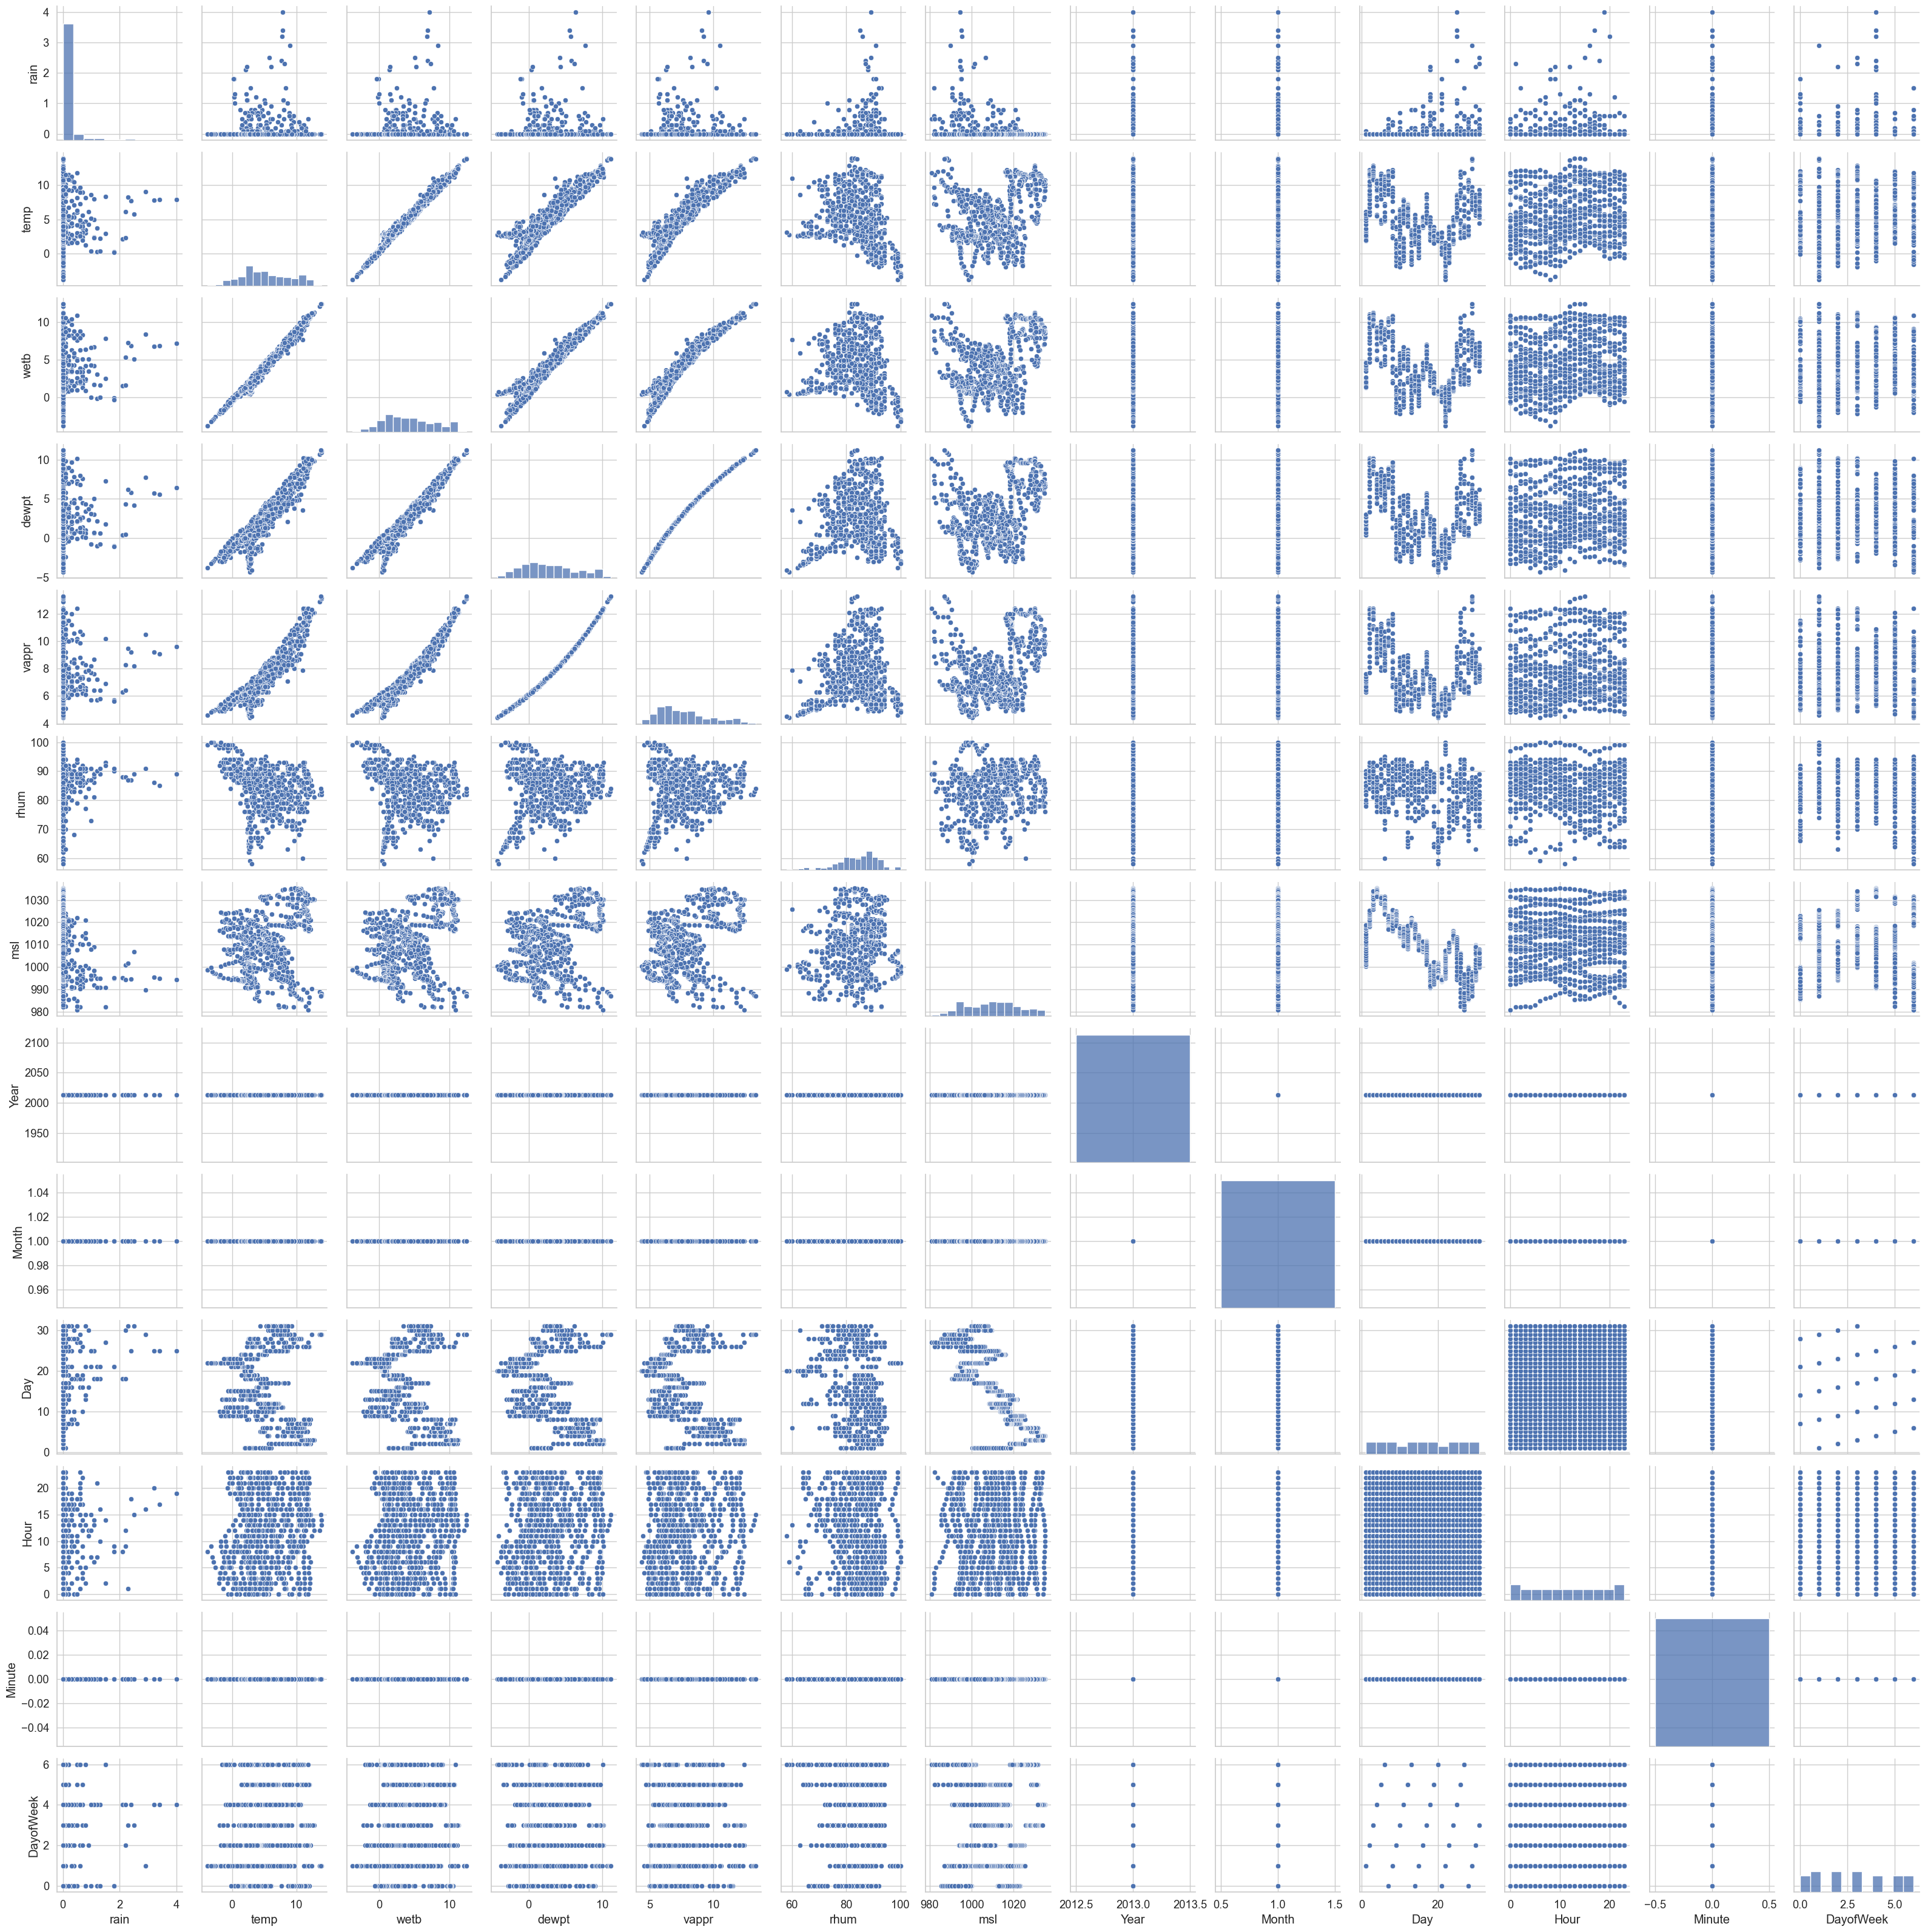

In [67]:
sns.pairplot(Phoenix_wdf)

In [68]:
c_wd = Phoenix_wdf.corr('pearson', numeric_only=True)

<AxesSubplot: >

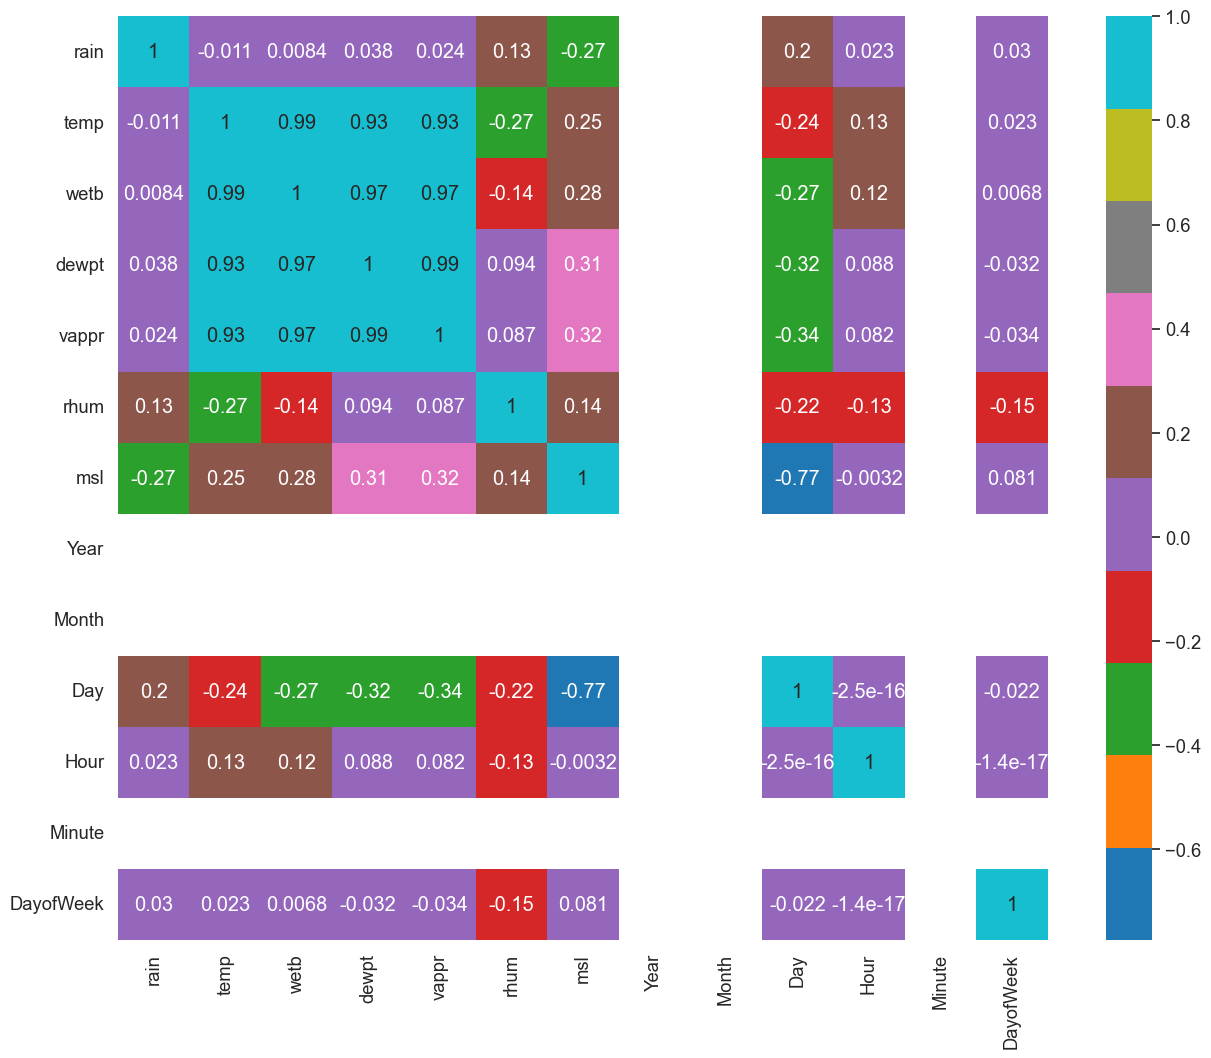

In [69]:
fig, ax = plt.subplots(figsize=(15,12))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_wd, cmap="tab10", annot=True)

In [70]:
#join weather and bus 
mdf = pd.merge(Phoenix_wdf, df)
mdf.head()

date  rain  temp  wetb  dewpt  vappr  rhum     msl  \
0  01-jan-2013 11:00   0.0   3.6   2.7    1.2    6.7  84.0  1009.0   
1  01-jan-2013 11:00   0.0   3.6   2.7    1.2    6.7  84.0  1009.0   
2  01-jan-2013 11:00   0.0   3.6   2.7    1.2    6.7  84.0  1009.0   
3  01-jan-2013 11:00   0.0   3.6   2.7    1.2    6.7  84.0  1009.0   
4  01-jan-2013 11:00   0.0   3.6   2.7    1.2    6.7  84.0  1009.0   

             datetime  Year  ...  Operator  Congestion  LonWGS84   LatWGS84  \
0 2013-01-01 11:00:00  2013  ...        HN           0 -6.116812  53.499493   
1 2013-01-01 11:00:00  2013  ...        RD           0 -6.212467  53.324749   
2 2013-01-01 11:00:00  2013  ...        CD           0 -6.451066  53.347698   
3 2013-01-01 11:00:00  2013  ...        PO           0 -6.394768  53.393051   
4 2013-01-01 11:00:00  2013  ...        CD           0 -6.373067  53.286098   

   Delay  BlockID  VehicleID  AtStop  Colour  Ontime  
0    -20   332001      33625       0  Yellow       1  
1      0     1001      33384       1  Yellow       1  
2      0    25003      33403       1  Yellow       1  
3   -333    39002      33585       0   Black       0  
4      0    76002      33409       1  Yellow       1  

[5 rows x 30 columns]

<AxesSubplot: >

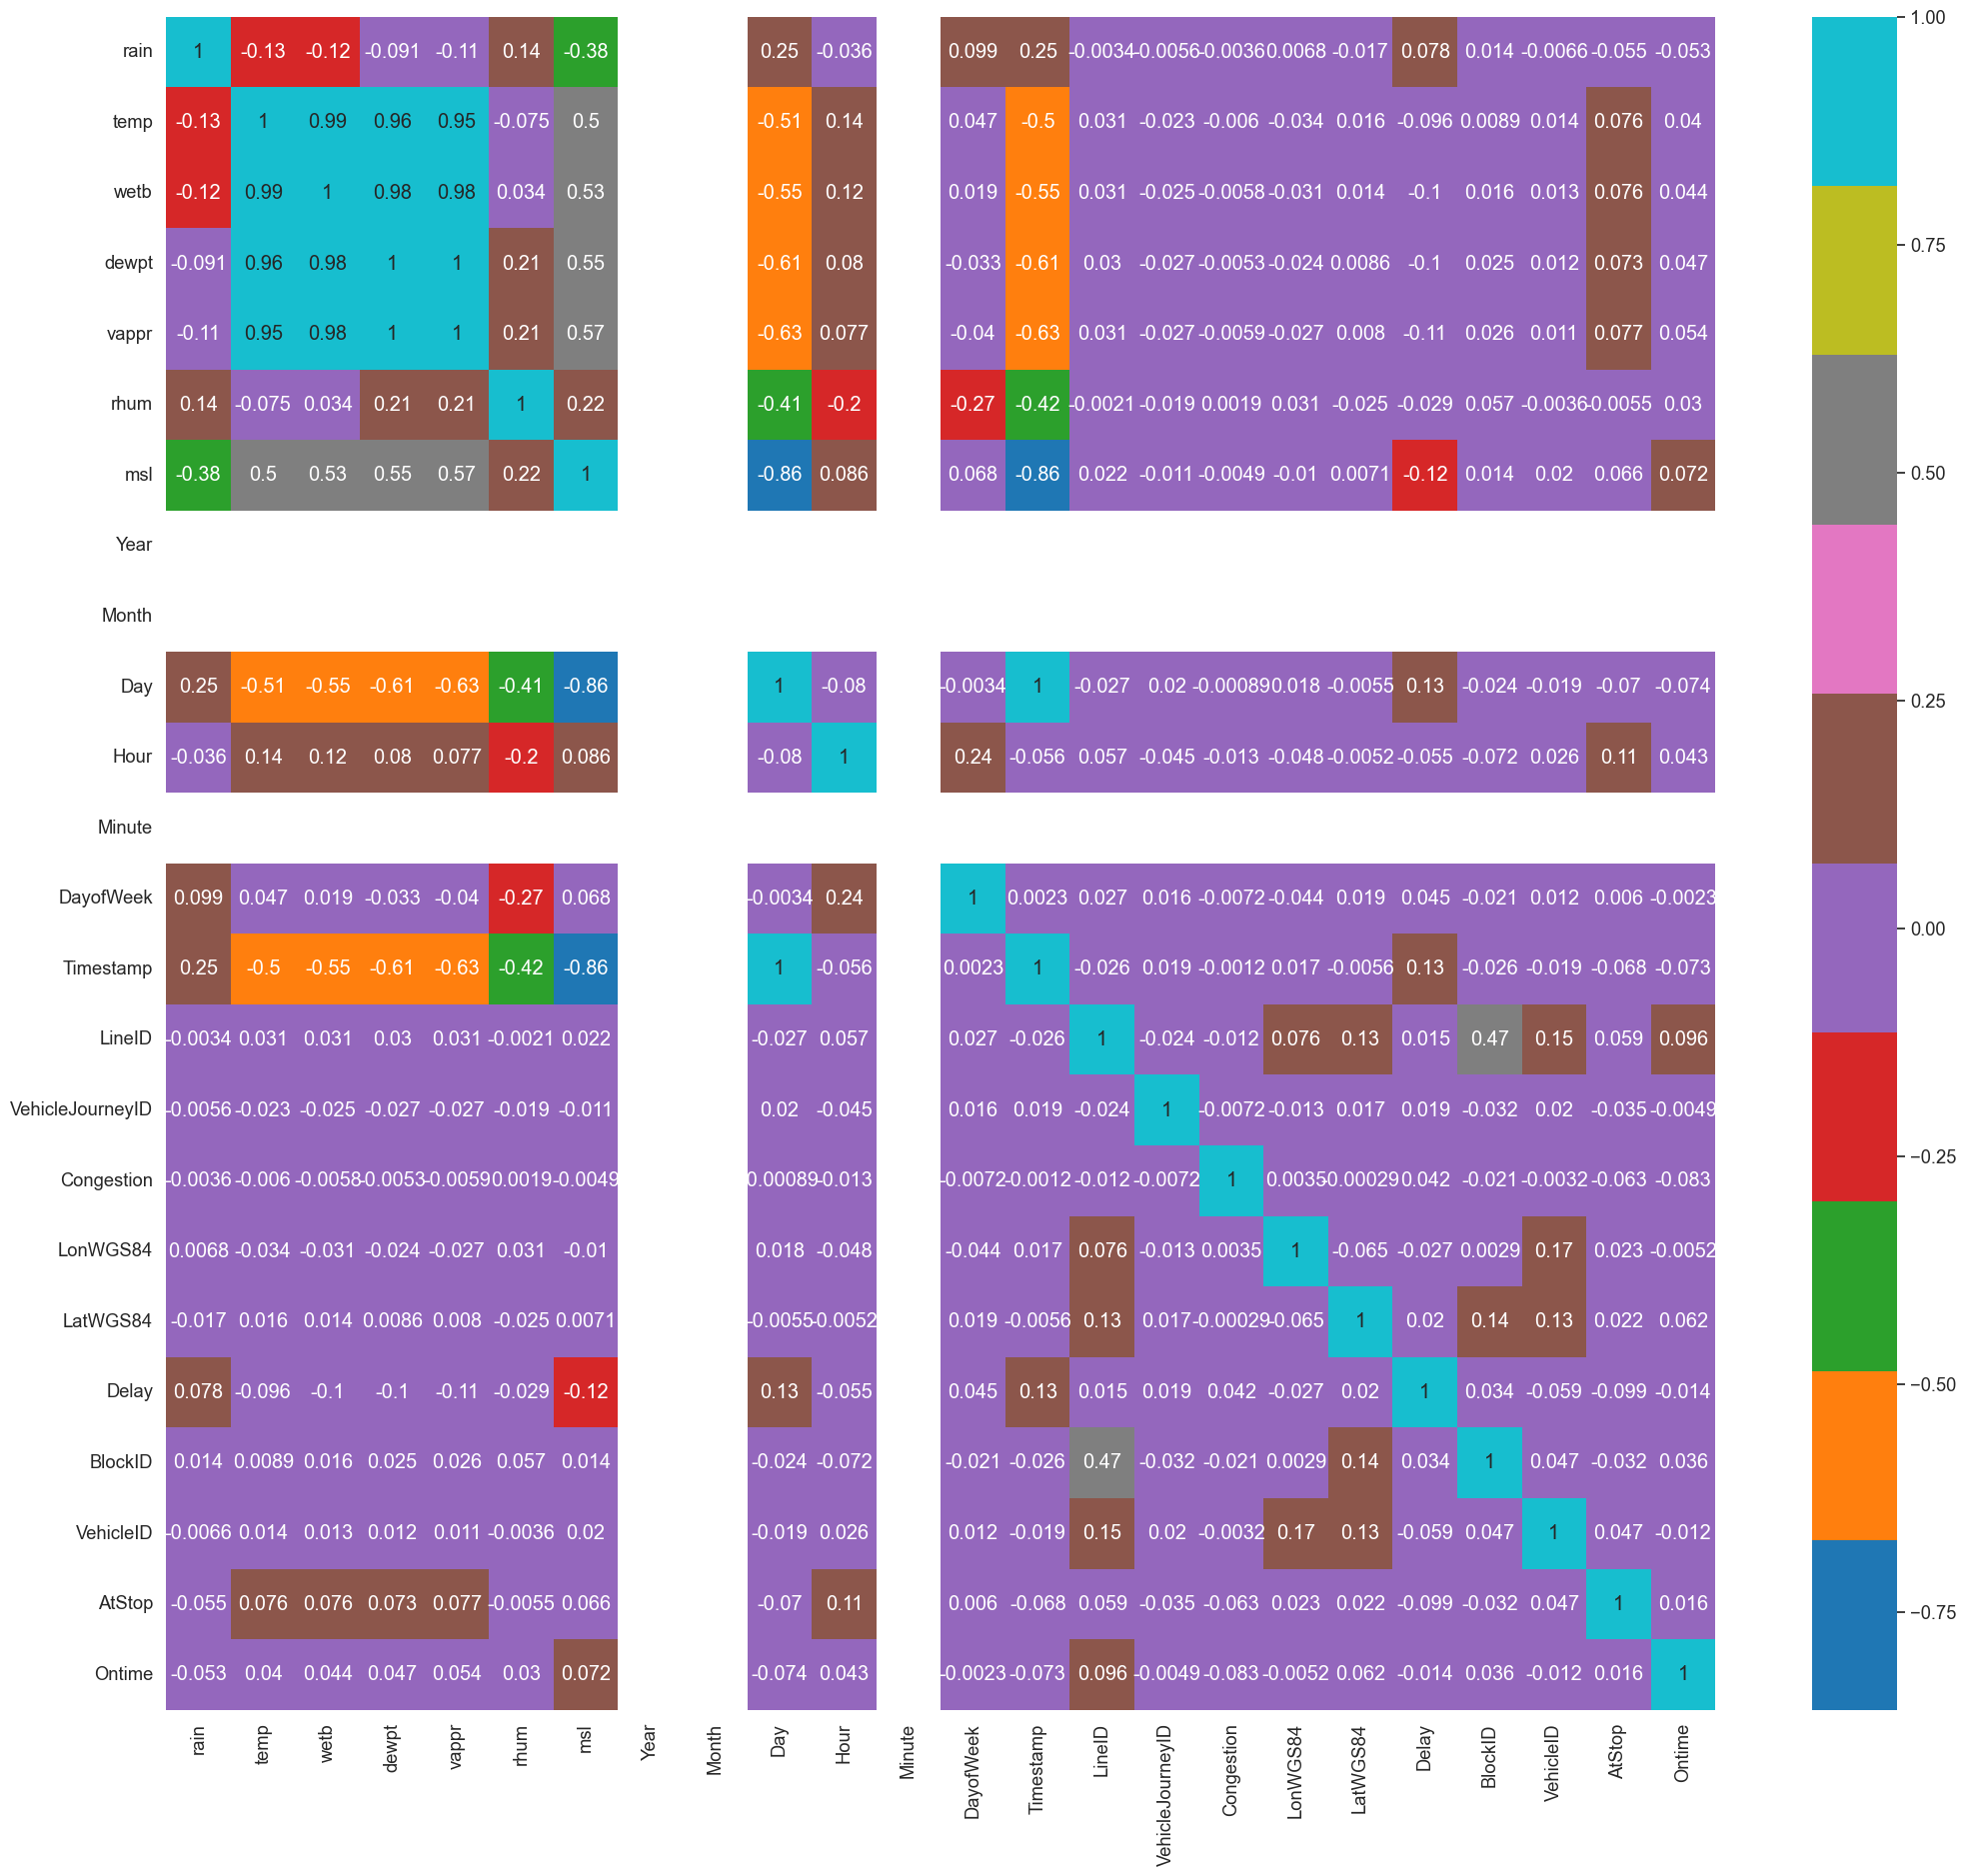

In [71]:
c_df = mdf.corr('pearson', numeric_only=True)
fig, ax = plt.subplots(figsize=(25,22))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_df, cmap="tab10", annot=True)

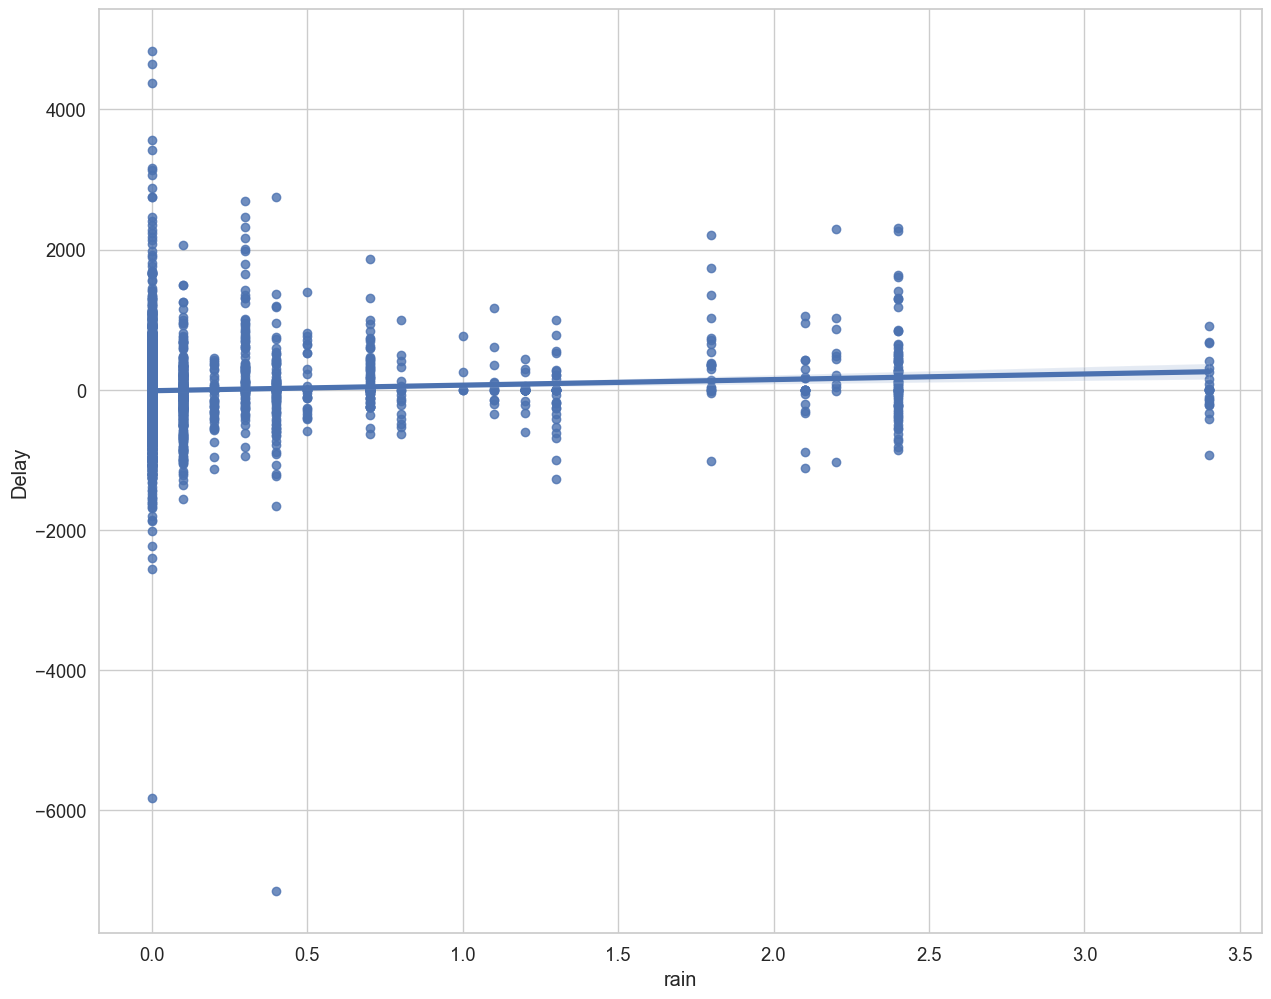

In [72]:

fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'rain' , y = 'Delay');


<AxesSubplot: xlabel='msl', ylabel='Delay'>

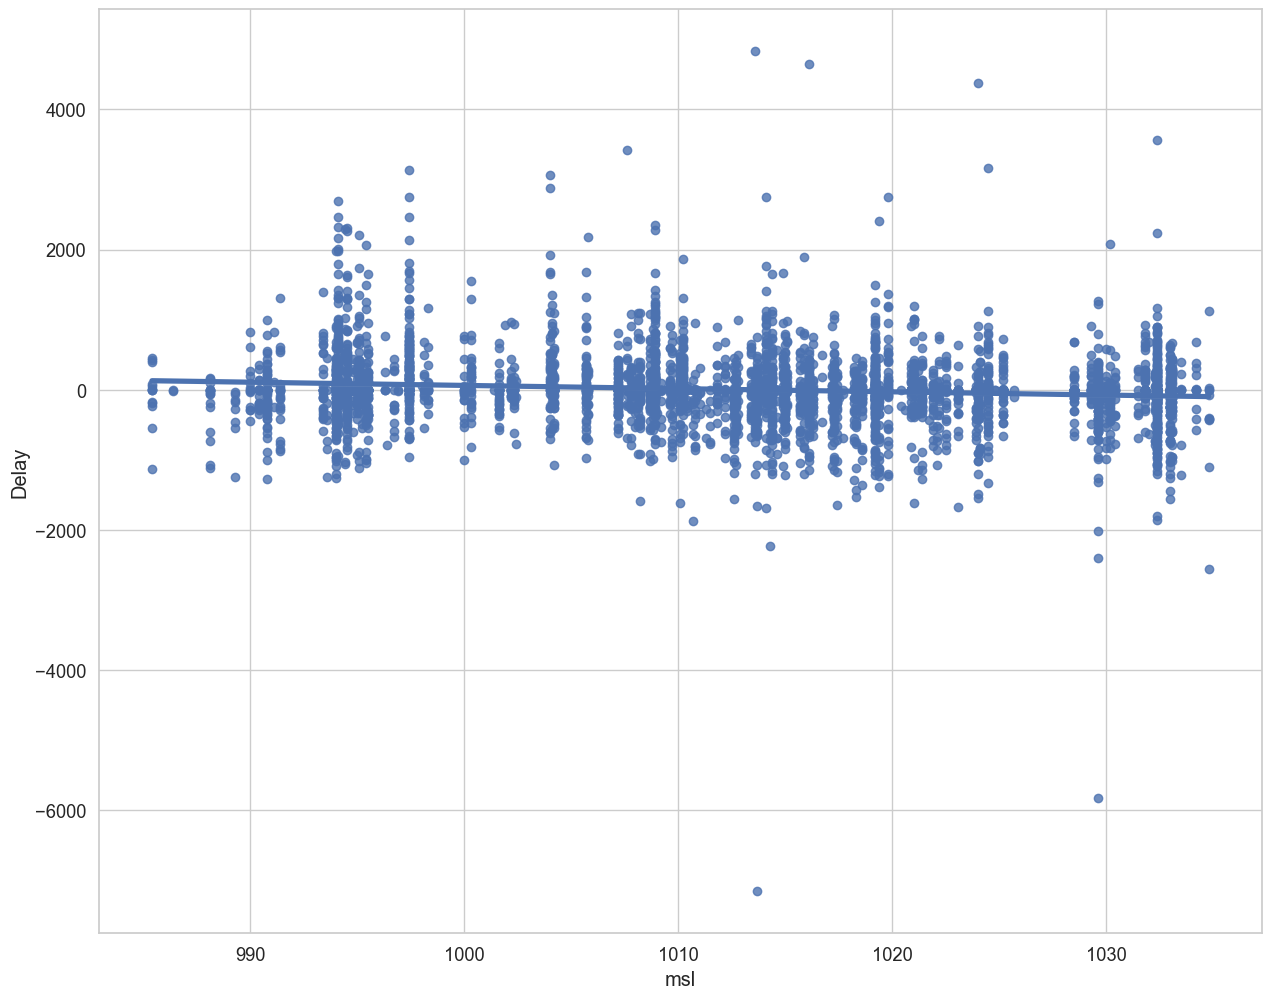

In [73]:
fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'msl' , y = 'Delay')


<AxesSubplot: xlabel='Day', ylabel='Delay'>

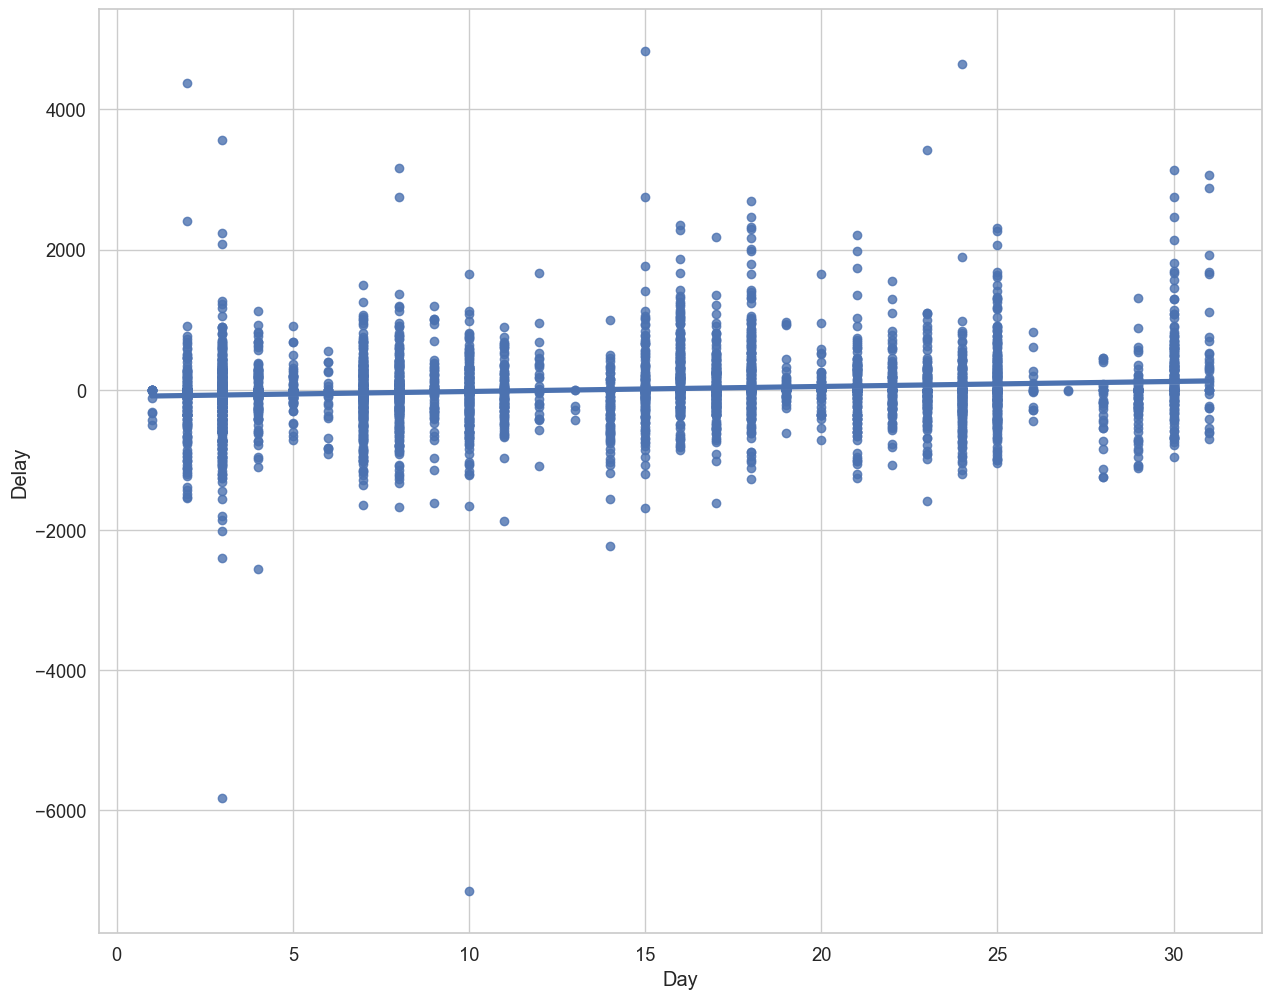

In [74]:
fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'Day' , y = 'Delay')

<AxesSubplot: xlabel='DayofWeek', ylabel='Delay'>

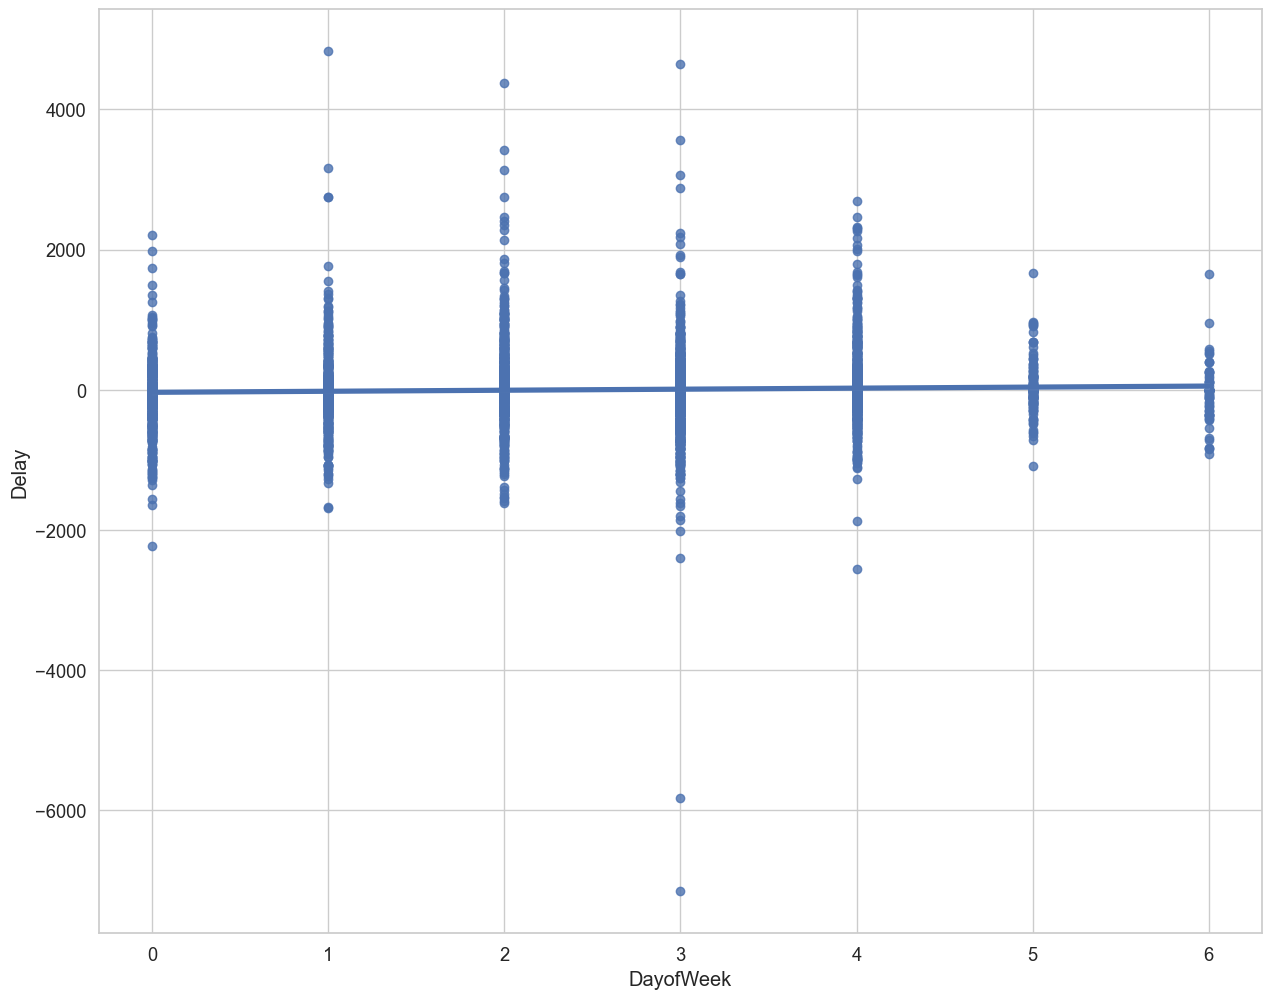

In [75]:
fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'DayofWeek' , y = 'Delay')

<AxesSubplot: xlabel='rain', ylabel='Ontime'>

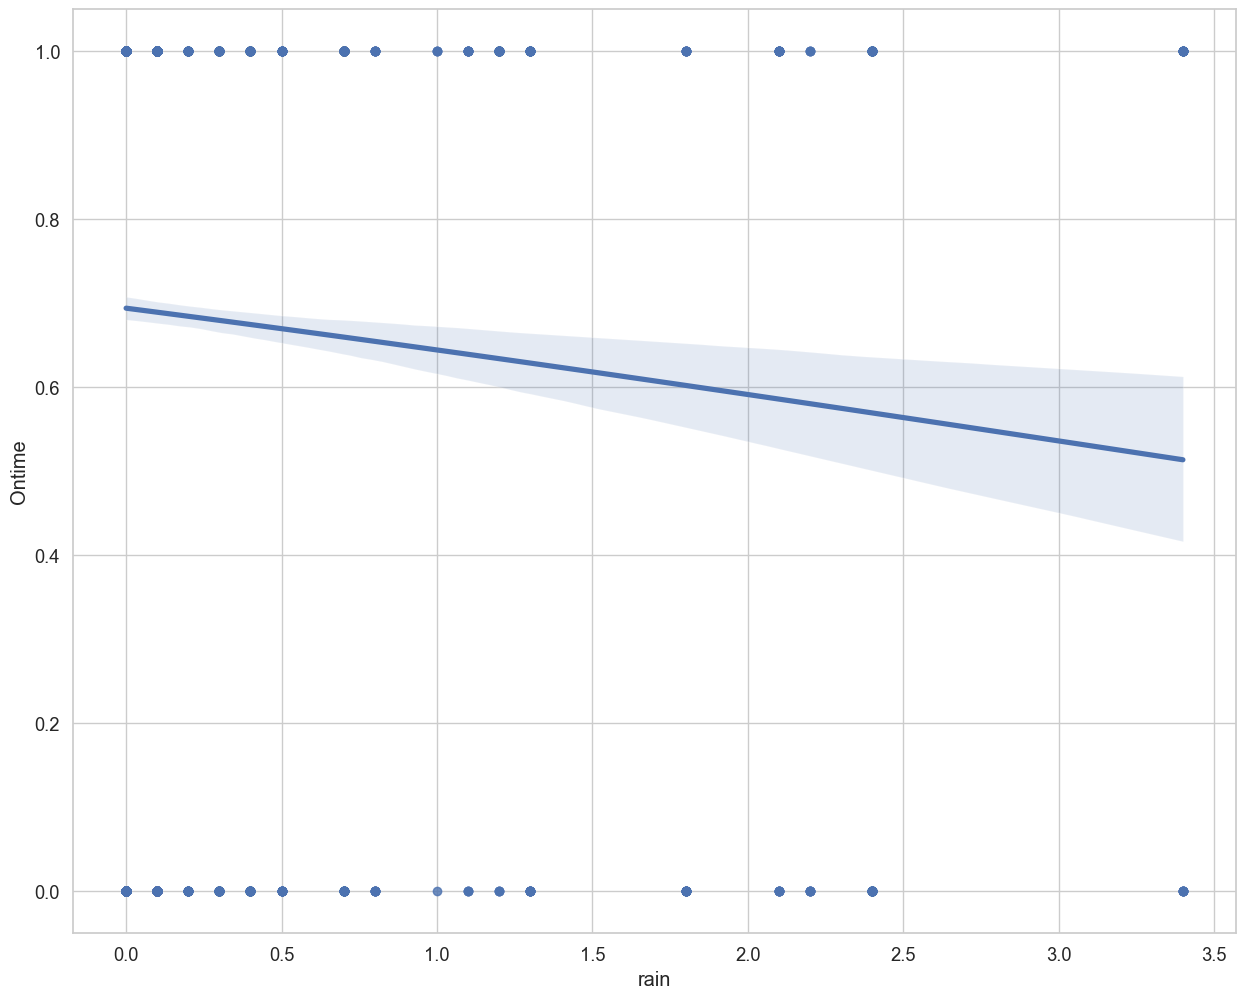

In [76]:
fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'rain', y = 'Ontime', logistic = True)

### display histogram of the new data set

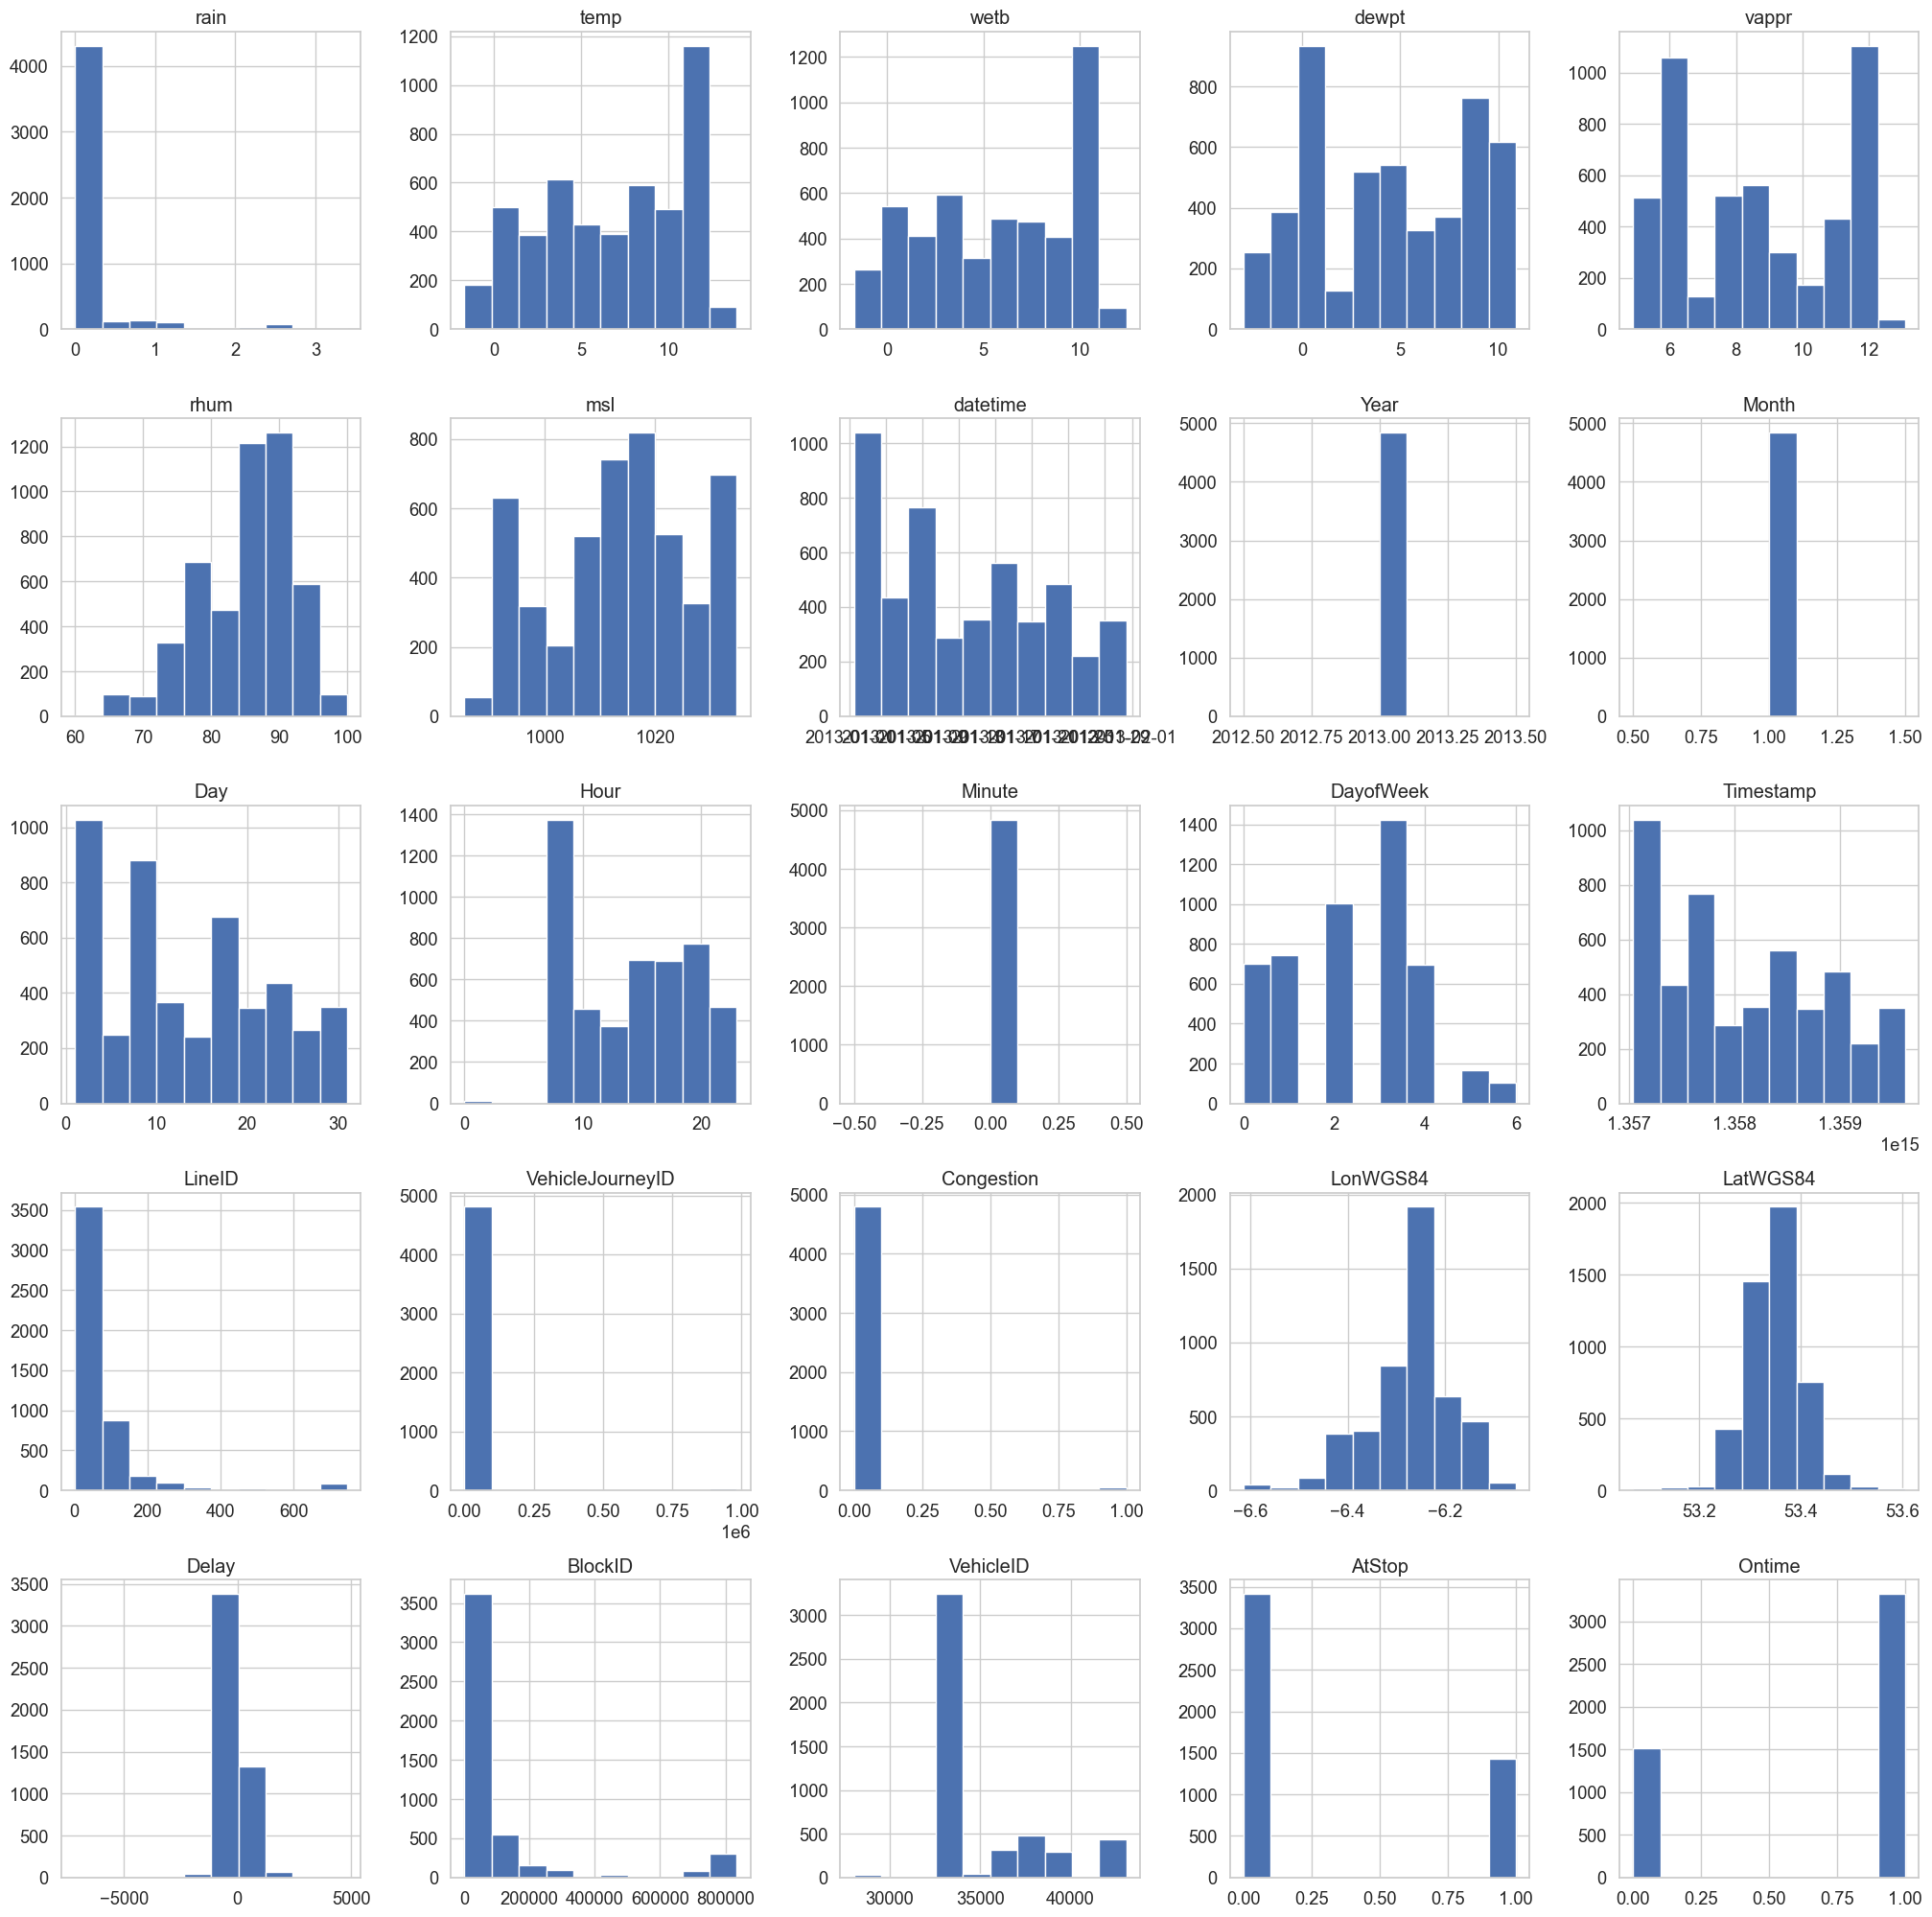

In [77]:
mdf.hist(figsize=(25,25));

In [78]:
busRoutes = mdf['LineID'].unique()
display(busRoutes)
busRoutes = sorted(busRoutes)
w1_value = ''
w1 = None
w1 = widgets.Dropdown(
    options= busRoutes,
    value= busRoutes[0],
    description = 'Bus Route',
    )

i = interactive(custom_scatterplot, df1 =fixed(df), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)

array([332.,   1.,  25.,  39.,  76., 171.,  83., 238., 151.,  13.,  41.,
        14.,  33.,  15.,  11., 145.,  32., 123.,  49.,  66.,   9.,   4.,
        27.,  67., 150.,  16., 102., 122.,  46., 120., 271.,  38.,  68.,
        54.,  31., 451.,  37., 114.,   7.,  40.,  42.,  84.,  29.,  17.,
       747.,  75.,  18.,  79.,  65.,  56., 130.,  59., 272., 140., 331.,
       220.,  51.,  63.,  44., 104., 111., 142.,  53., 116., 118.])

In [79]:
mdf.to_parquet('./Data/WeatherandBusData.parquet')

LineID
BlockID
Delay
LatWGS84
LonWGS84
VehicleJourneyID
VehicleID
AtStop
Timestamp


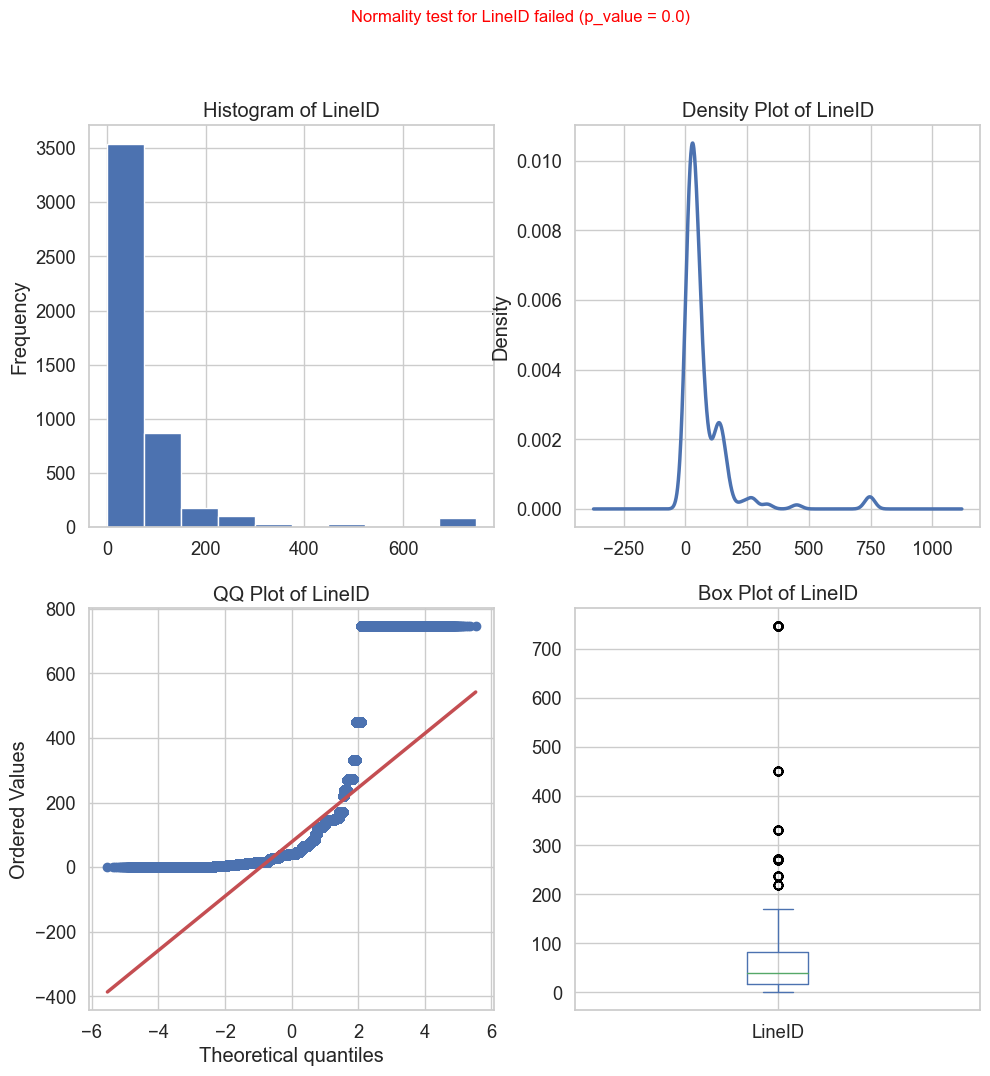

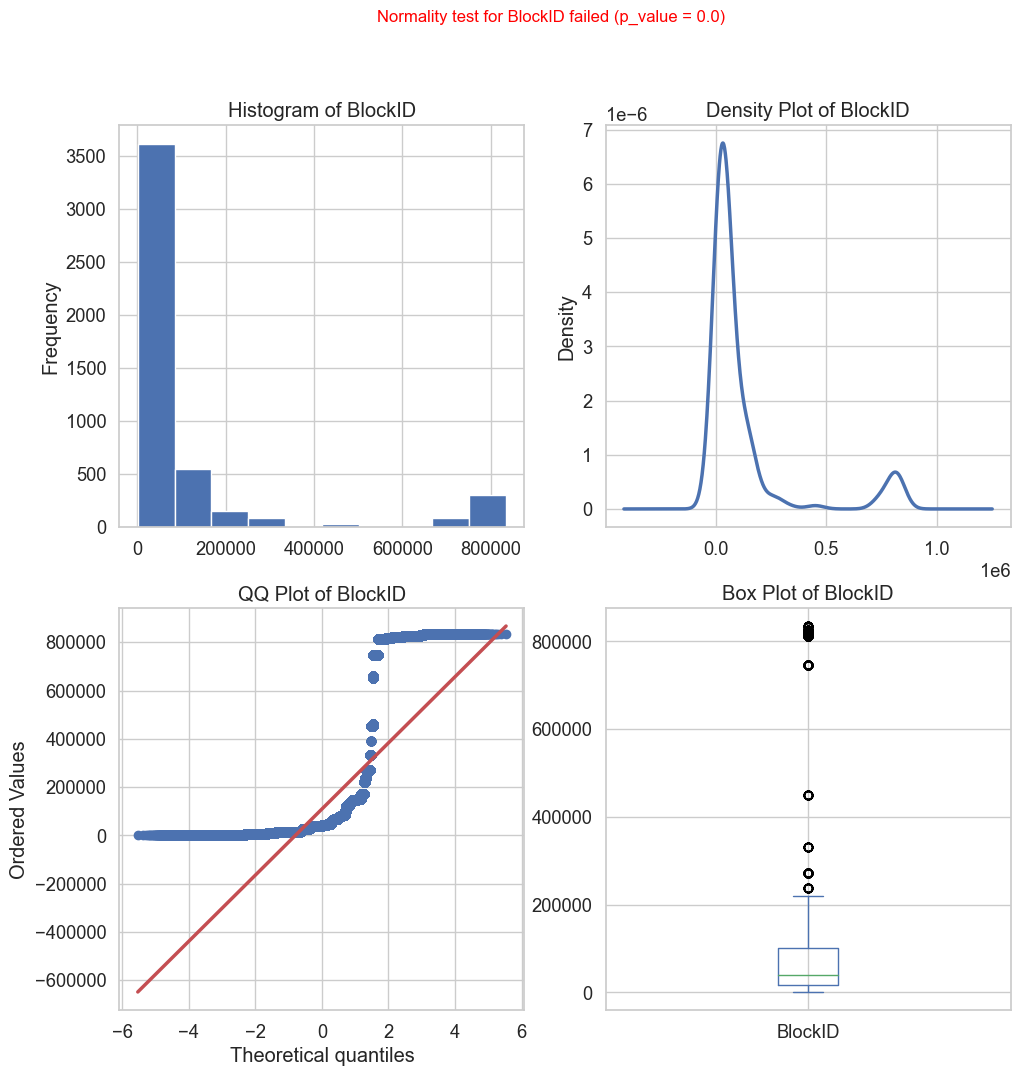

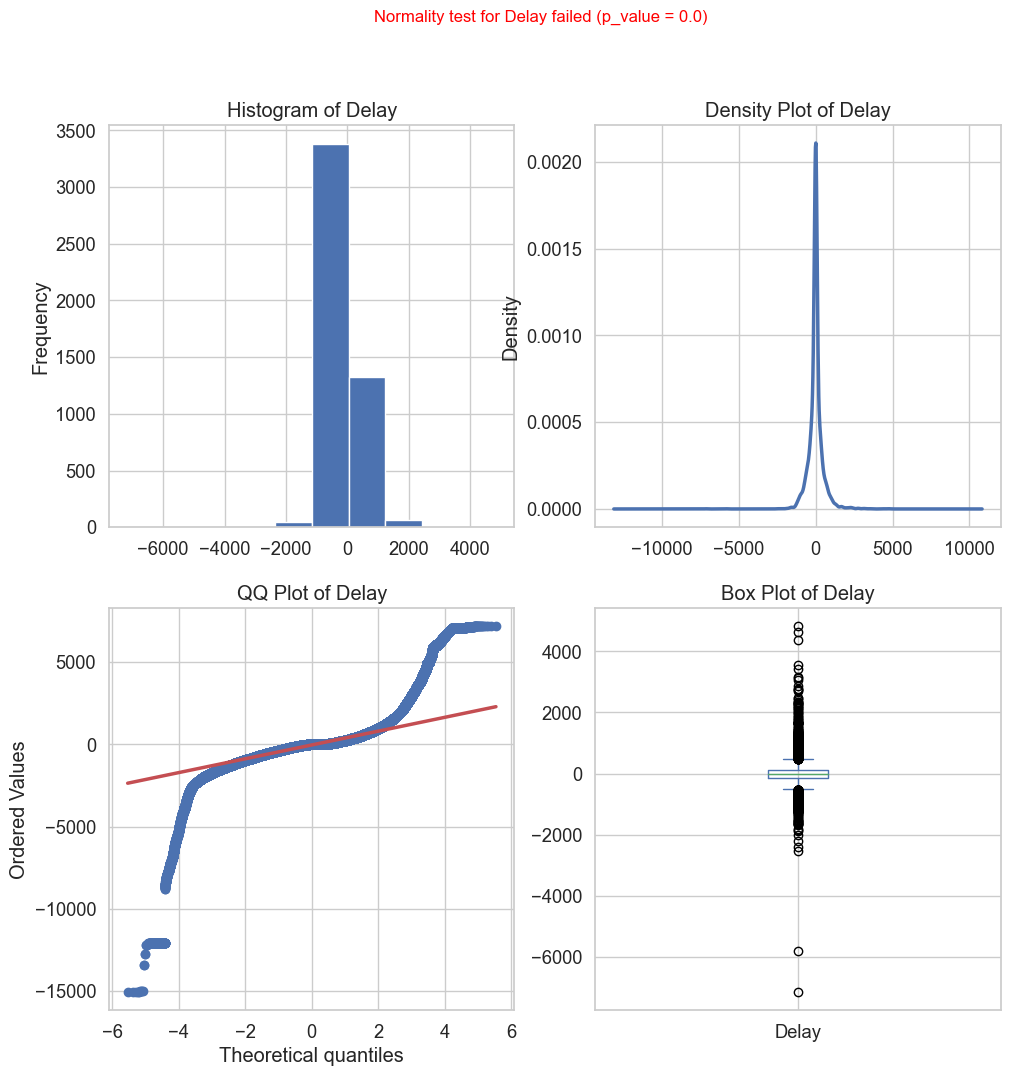

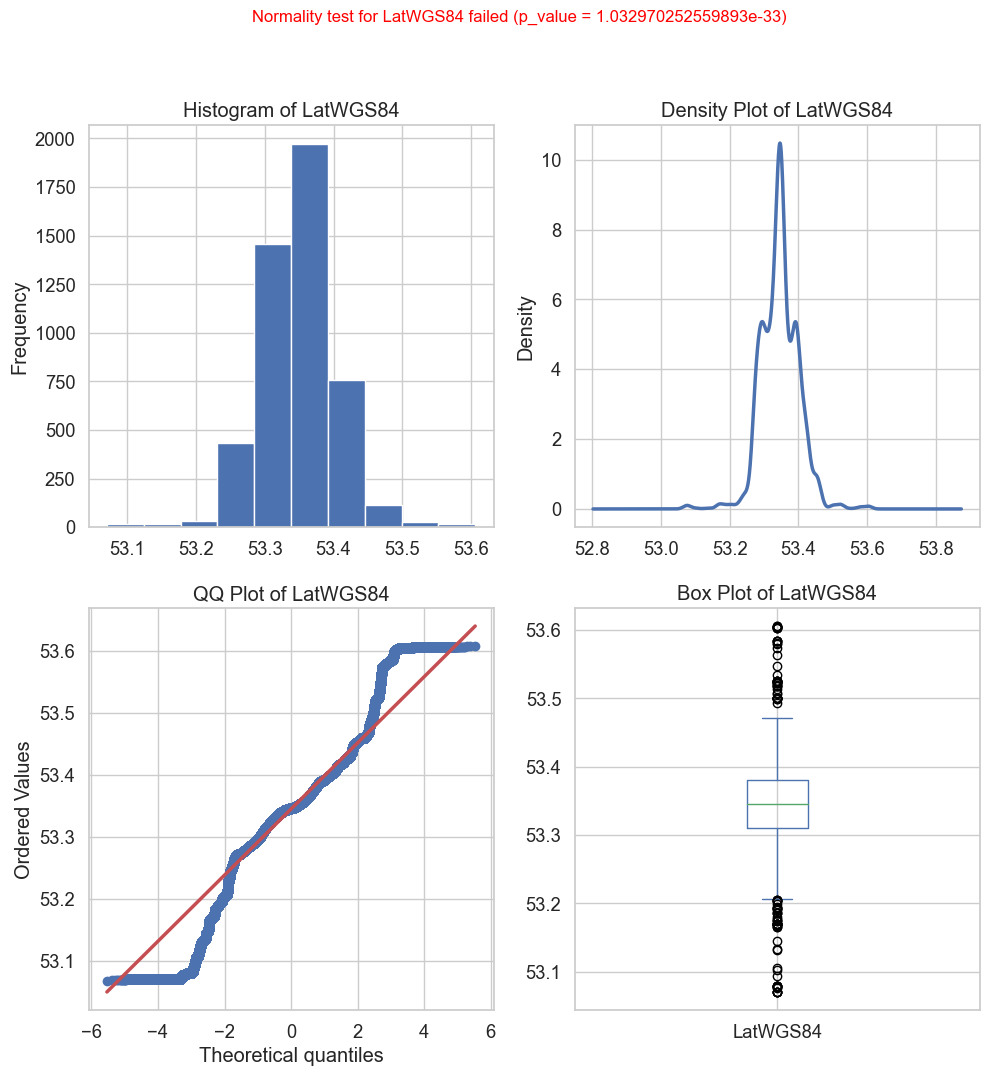

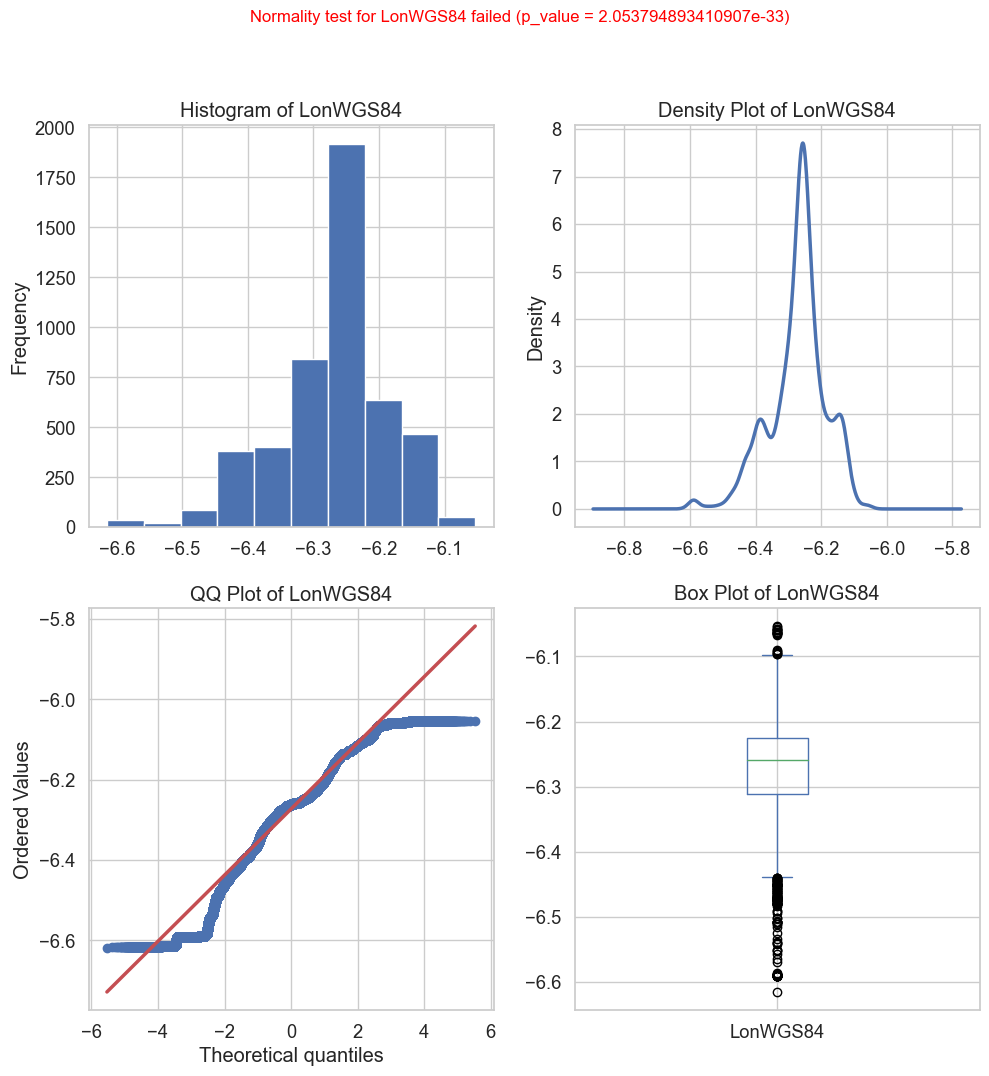

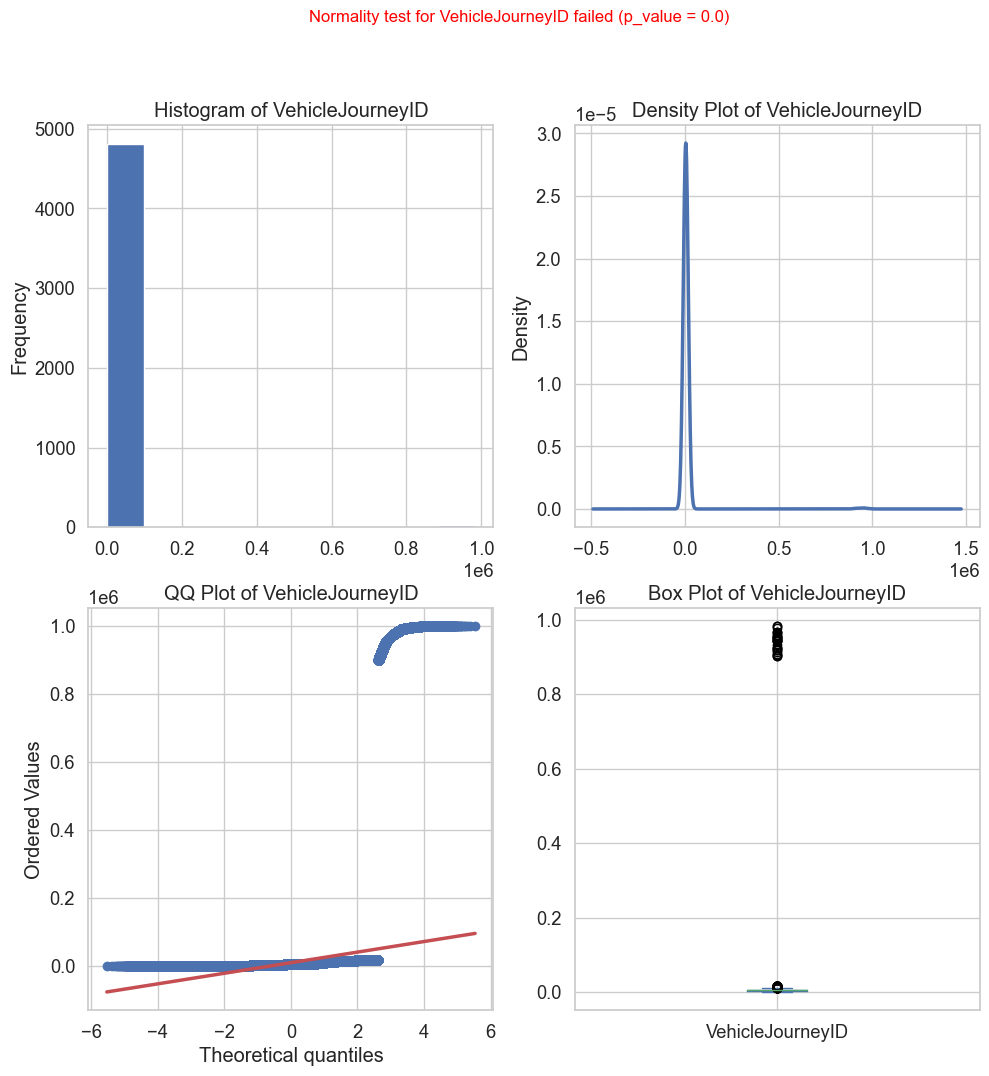

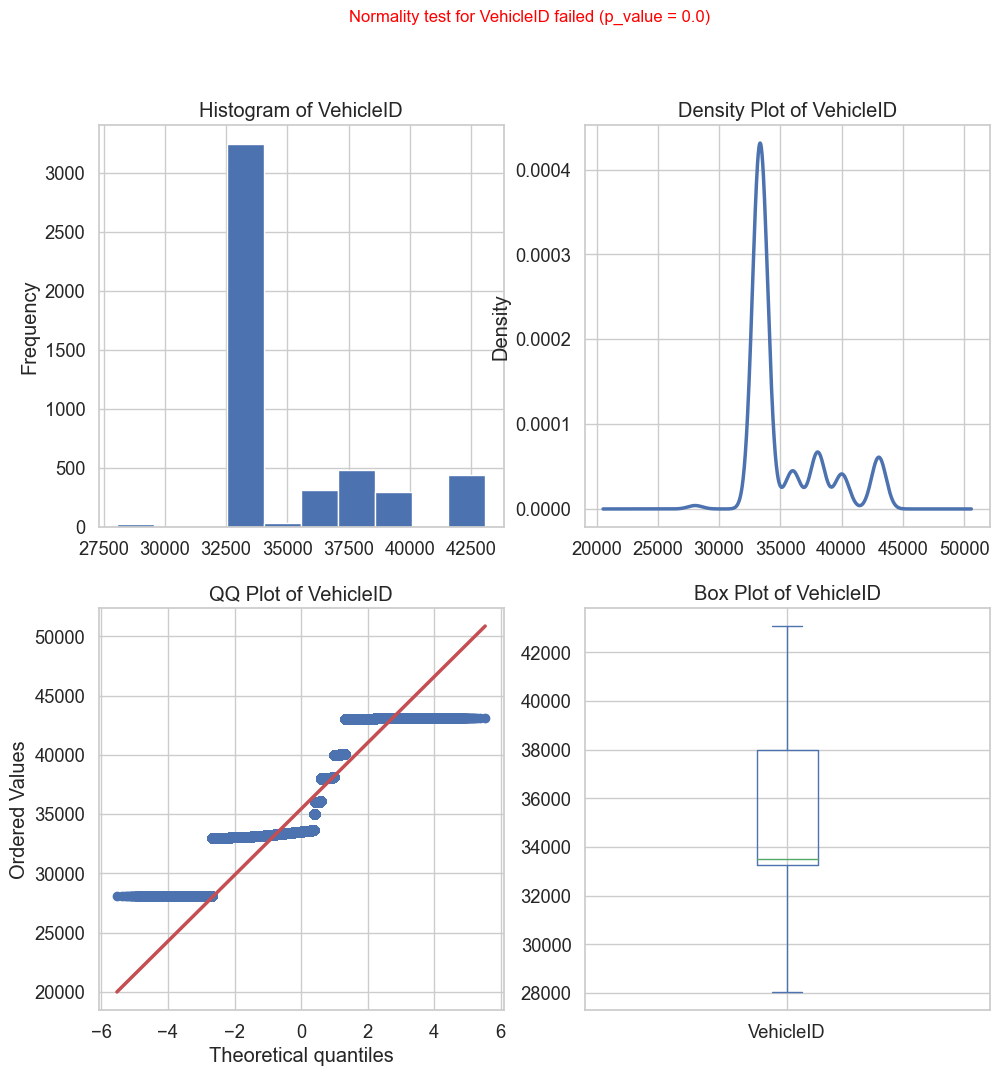

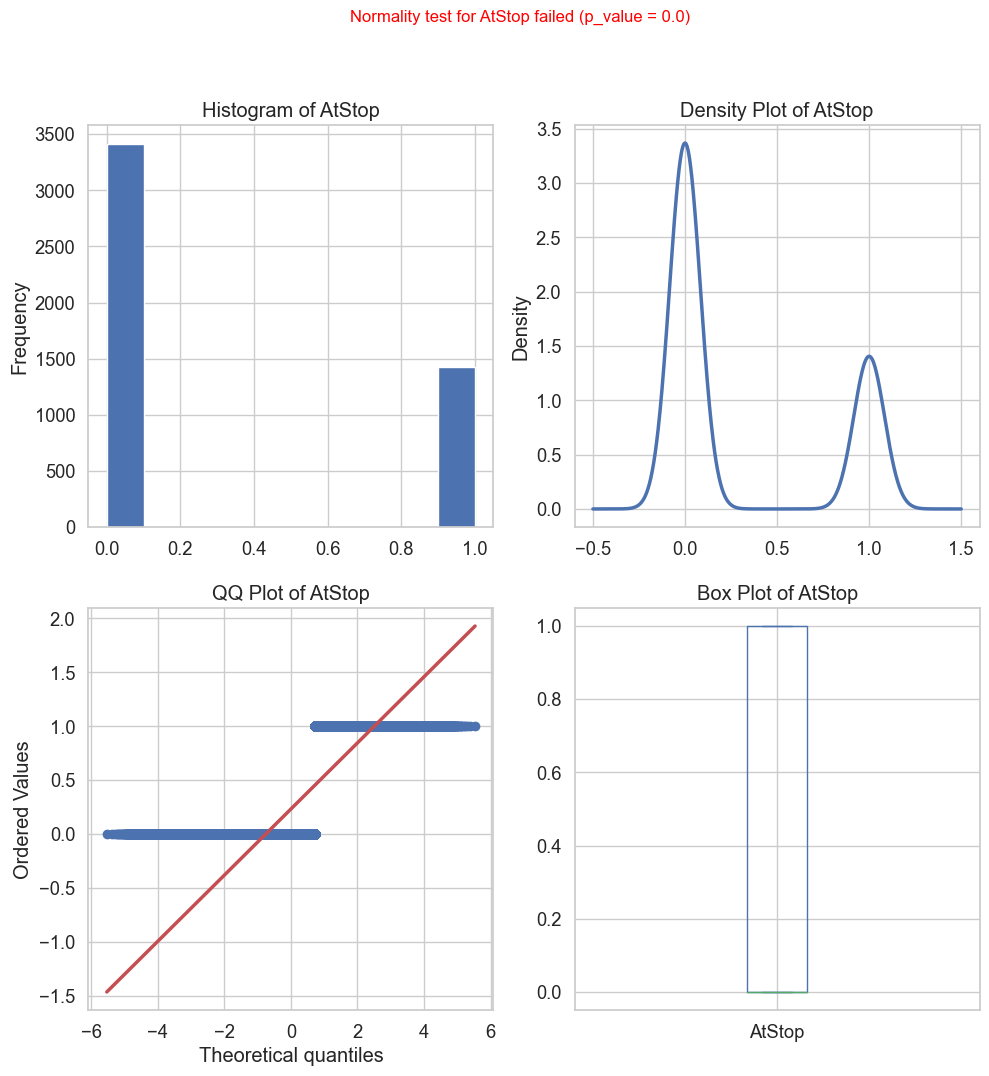

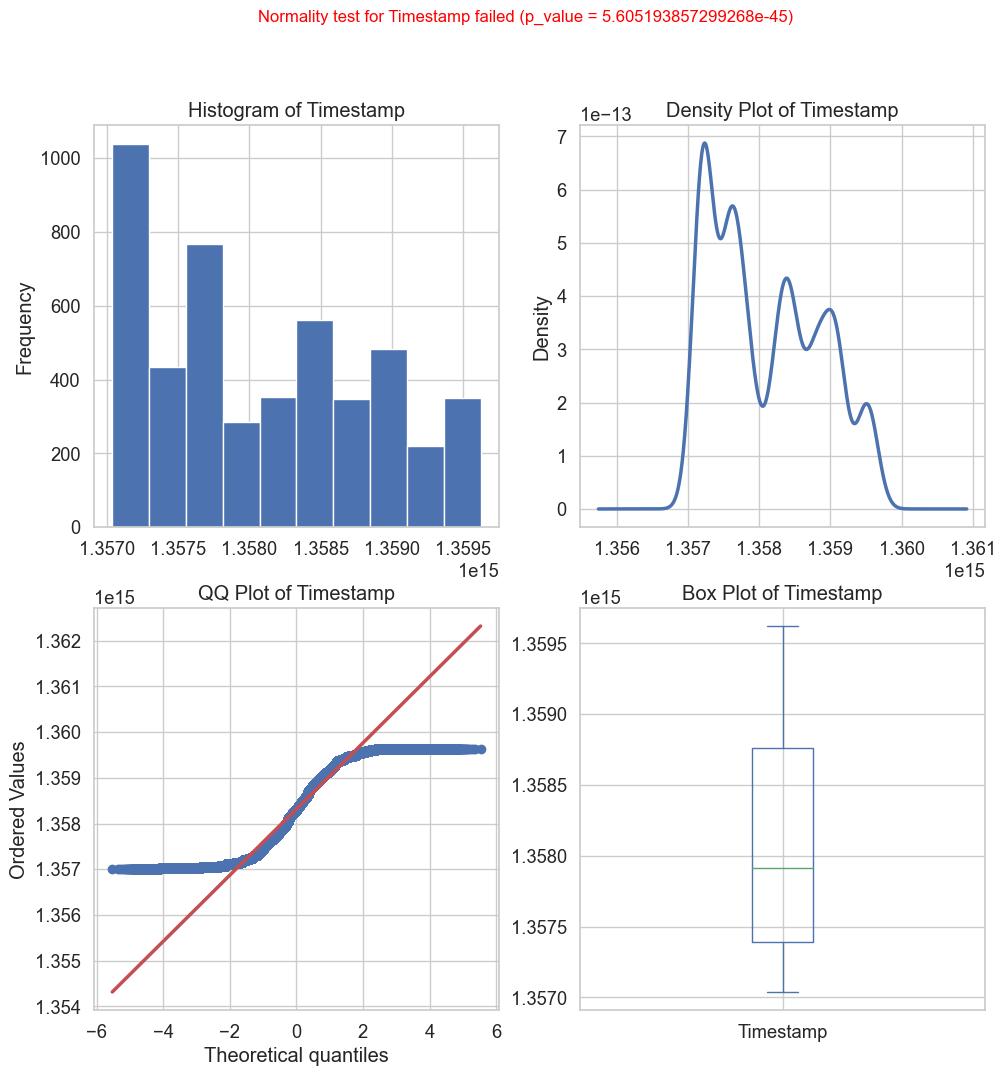

In [80]:
if len(mdf) > 5000: # limiting the amount of data that is being sent to the function because of memory issues 
    sampleSize = 5000
else:
    sampleSize = len(mdf)
for f in NumericalColumns:
    print(f)
    custom_barplot( df1=mdf.sample(sampleSize), col1=f)